# Multinomial Naïve Bayes


Ryan Timbrook (RTIMBROO)  
DATE: 10/27/2019
Topic: Naive Bayes Text Classification


## 1. Objective
_____________________________________________________________________________________________
Benoulli and Multinomial Naïve Bayes in Sci-kit Learn

For this assignment you will use the Benoulli and Multinomial Naïve Bayes algorithms in sklearn to repeat the customer review classification by sentiment and authenticity (same data from HW4). 

Remember that the Benoulli model takes Boolean vectors as input, and the Multinomial model takes frequency vectors as input. Use several vectorization options, such as removing stopwords, ngrams, etc. to create three Benoulli models and three Multinomial models. Explain the rationale for your vectorization choices, and compare the performance of these models using appropriate evaluation methods and metrics.

Build models to classify the customer reviews by (1) sentiment (positive or negative) (2) authenticity (true or fake, lie detection). (6 points)

For each of the two classification tasks, use MNB to build the models, and evaluate them using 10-fold cross validation methods. You can choose your own options for tokenization, and make sure to report if you change any default setting. 

For each model (lie detection and sentiment classification), report the 20 most indicative words that the models have learned. Based on these words, do you think the models have learned the concepts (lie or sentiment) that they are expected to learn?

Also, compare the difficulty level of sentiment classification vs. lie detection. Discuss whether you believe computers can detect fake reviews by the words.



## Findings / Recommendations
place findings and recommendations here  





...

___________________________________________________________________________________________
## FOR RUNNING IN GOOGLE COLAB ONLY ##

In [1]:
# toggle for working with colab
isColab = False

In [2]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [3]:
# import packages for analysis and modeling
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import os
import io
from os import path
import re
from itertools import product
from datetime import date
from datetime import time
from datetime import datetime

# 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
# get loggers
warnings.filterwarnings('ignore')

In [4]:
# custome python packages
import rtimbroo_utils_hw6 as br             # custome python helper functions

In [5]:
# get current date
now = datetime.utcnow().isoformat()
collection_date = re.findall('^[0-9]{4}-[0-9]{2}-[0-9]{2}',now)
collection_date

['2019-11-13']

In [6]:
# set global properties
notebook_file_name = 'hw6_mnb_bnb'
report_file_name = 'hw6_mnb_bnb'
app_name = 'hw6_mnb_bnb'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [7]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [8]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name+'_'+collection_date[0],level=log_level)

### Below section is for custom class definitions
##### -----------------------------------------------------------------------------------------------------------------

### Below section is for local custom functions
##### -----------------------------------------------------------------------------------------------------------------

## 2. OBTAIN the data   
________________________________________________________________________________________________
Import external datasets for evaluation

In [9]:
# datasets file names to load
deception_data = pd.read_csv(f'{dataDir}/deception_data_converted_final.tsv', delimiter='\t')
deception_data.head()
logger.info(f'deception_data shape: {deception_data.shape}')
logger.info(f'deception_data size: {deception_data.size}')
logger.info(f'deception_data len: {len(deception_data)}')
logger.info(f'deception_data.head: {deception_data.head()}')

deception_data shape: (92, 3)
deception_data size: 276
deception_data len: 92
deception_data.head:   lie sentiment                                             review
0   f         n  'Mike\'s Pizza High Point, NY Service was very...
1   f         n  'i really like this buffet restaurant in Marsh...
2   f         n  'After I went shopping with some of my friend,...
3   f         n  'Olive Oil Garden was very disappointing. I ex...
4   f         n  'The Seven Heaven restaurant was never known f...


In [10]:
# do resampling on original dataset to enhance model training
#deception_data_resampled = deception_data.sample(n=10000, frac=None, replace=True, weights=None, random_state=42, axis=None)

### Tokenize & Create Text Corpus

In [11]:
# separate data into two distinct sets
# run each through MNB 10-fold cross validation
lie_df = deception_data.drop(columns=['sentiment'])
sentiment_df = deception_data.drop(columns=['lie'])

# testing with resampling at 1000 records from original dataset
#lie_df = deception_data_resampled.drop(columns=['sentiment'])
#sentiment_df = deception_data_resampled.drop(columns=['lie'])

In [12]:
logger.info(f'lies dataset initial shape: {lie_df.shape}')
logger.info(f'lies dataset initial size: {lie_df.size}')
logger.info(f'sentiment dataset initial shape: {sentiment_df.shape}')
logger.info(f'sentiment dataset initial size: {sentiment_df.size}')

lies dataset initial shape: (92, 2)
lies dataset initial size: 184
sentiment dataset initial shape: (92, 2)
sentiment dataset initial size: 184


In [13]:
lie_df.drop(lie_df.loc[lie_df['review']=='?'].index,inplace=True)
sentiment_df.drop(sentiment_df.loc[sentiment_df['review']=='?'].index,inplace=True)
sentiment_df.tail(20)

sentiment                                             review
70         p  'i really like this one chicken wings restaura...
71         p  'Ruby Tuesday is my favorite America Style Res...
72         p  'Stronghearts cafe is the BEST! The owners hav...
73         p  'The best restaurant I have ever been was a sm...
74         p  'My best restaurant is Amer Palace Hotel in my...
75         p  'When you walk into TYU you may not have the h...
76         p  'I went to this awesome restaurant in San Fran...
77         p  'This cafe is located on the 2nd street from t...
78         p  'I went to cruise dinner in NYC with Spirit Cr...
79         p  'Halo\'s is home. I have been here numerous ti...
80         p  'The best restaurant I have gone to is when I ...
81         p  'The restaurant looked pretty good, the people...
84         p  'A big piano is in the middle of the lobby and...
85         p  'Can\'t say too much about it. Just, try it bu...
86         p  'Blue Monkey Cafe is my favorite Japanese rest...
87         p  'Pastablities is a locally owned restaurant in...
88         p  'I like the Pizza at Dominoes for their specia...
89         p  'It was a really amazing Japanese restaurant. ...
90         p  'How do I even pick a best experience at Joe\'...
91         p  'My sister and I ate at this restaurant called...

In [14]:
sentiment_df.shape

(90, 2)

In [15]:
# write each dataset to csv
save_as = f'{dataDir}/lie_deception_data.csv'
lie_df.to_csv(save_as,index=False)

save_as = f'{dataDir}/sentiment_deception_data.csv'
sentiment_df.to_csv(save_as,index=False)


### 2.1 SCRUB / CLEAN
Clean and perform initial transformations tokenization and vectorization steps

Perform vectorization tasks
>

Determin **what to count** and **how to count it**<br>

Basic text preparation pipeline:

* Load the raw text.
* Split into tokens.
* Convert to lowercase.
* Remove punctuation from each token.
* Filter out remaining tokens that are not alphabetic.
* Filter out tokens that are stop words.
* Perform stemming -> [nltk reference](https://pythonprogramming.net/stemming-nltk-tutorial/)

In [16]:
# perform scrubbing and cleaning techniques
# global variables
initial_words_count = 0
cleaned_words_count = 0
#feature_thres = 2
#rare_thres = 5

### Tokenize 

In [17]:
lie_df.head()

lie                                             review
0   f  'Mike\'s Pizza High Point, NY Service was very...
1   f  'i really like this buffet restaurant in Marsh...
2   f  'After I went shopping with some of my friend,...
3   f  'Olive Oil Garden was very disappointing. I ex...
4   f  'The Seven Heaven restaurant was never known f...

In [18]:
# tokenize lie df - use wordpunct_tokenize
from nltk.tokenize import wordpunct_tokenize

lie_tokens_bow = []
lie_true_tokens_bow = []
lie_false_tokens_bow = []
lie_tokens_index_map = {}
lie_label_index_map = {}
word_freq = {}
for i in range(0, len(lie_df)):
    #logger.info(lie_df.iloc[i]['lie'] )
    #logger.info(lie_df.iloc[i]['review'])
    
    # tokenize
    doc_token = wordpunct_tokenize(lie_df.iloc[i]['review'])
    logger.debug(f'LIE RAW TOKENS:\n{doc_token}')
    lie_tokens_index_map[i] = doc_token
    
    logger.debug(f'lie_tokens_index_map[{i}]:\n{lie_tokens_index_map[i]}')
    
    lie_label_index_map[i] = lie_df.iloc[i]['lie']
    #print(doc_token)
    for t in doc_token:
        # build bag of words list
        lie_tokens_bow.append(t)
        if lie_df.iloc[i]['lie'] == 't':
            lie_true_tokens_bow.append(t)
        else:
            lie_false_tokens_bow.append(t)
            
            
        #build word frequency dictionary
        if t not in word_freq.keys():
            word_freq[t] = 1
        else:
            word_freq[t] += 1
            
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index').reset_index()
word_freq_df.columns=('word','frequency')
word_freq_df = word_freq_df.sort_values(by=['frequency','word'], ascending=False)

logger.info(f'Initial Lie Review All Token Count: {len(lie_tokens_bow)}')
logger.info(f'Initial Lie Review True Token Count: {len(lie_true_tokens_bow)}')
logger.info(f'Initial Lie Review False Token Count: {len(lie_false_tokens_bow)}')
logger.info(f'Initial Lie Review label index map length: {len(lie_label_index_map)}')
logger.info(f'Initial Lie Review label token map length: {len(lie_tokens_index_map)}')

Initial Lie Review All Token Count: 8150
Initial Lie Review True Token Count: 3917
Initial Lie Review False Token Count: 4233
Initial Lie Review label index map length: 90
Initial Lie Review label token map length: 90


In [19]:
# top 10 true word frequencies
br.bow_word_frequency(lie_true_tokens_bow).head(10)

word  frequency
18    .        195
14  the        154
4     ,        121
22  and         98
65    I         93
31   to         85
98    a         80
81  was         77
13   is         71
6   The         64

In [20]:
# top 10 false word frequencies
br.bow_word_frequency(lie_false_tokens_bow).head(10)

word  frequency
17    .        208
14  the        173
13  and        134
7     ,        133
91    I        117
26   to        109
40    a         79
10  was         66
0     '         61
2    \'         54

### Perform Initial EDA on BoW for Lie Dataset

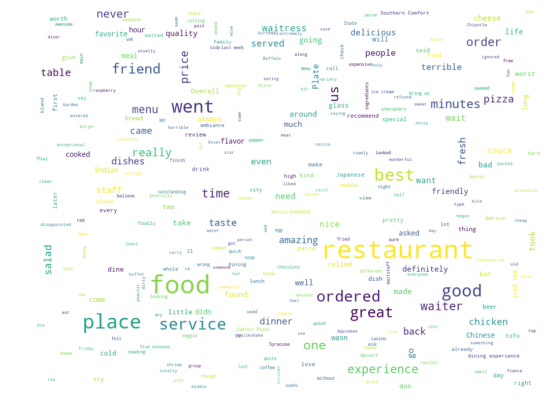

In [21]:
# initial word lie dataset - all
br.wordcloud_draw(lie_tokens_bow,color='white',max_words=300)

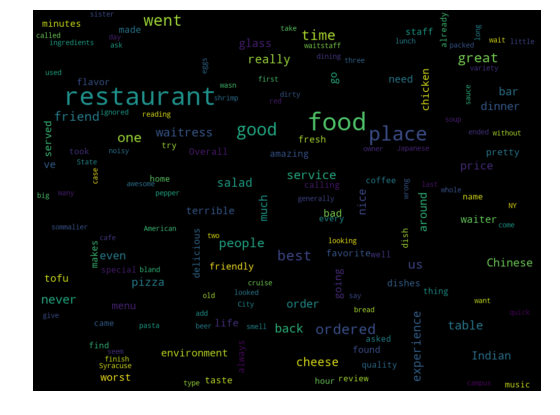

In [22]:
# initial word lie dataset - true
br.wordcloud_draw(lie_true_tokens_bow,color='black',max_words=150)

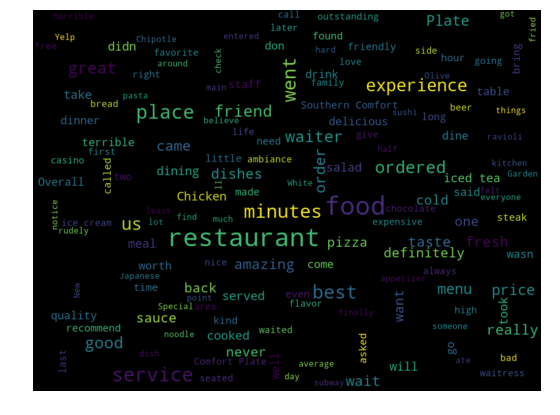

In [23]:
# initial word lie dataset - false
br.wordcloud_draw(lie_false_tokens_bow,color='black',max_words=150)

### Clean Lie dataset tokens

In [24]:
def clean_features(token_map,lower_case, stop_words, remove_punc, remove_non_alphabetic, stemming, logger=logger):
    
    kf = br.clean_text(logger, token_map,
                     custom_stop_words=[],
                     remove_pun=remove_punc,
                     remove_non_alphabetic=remove_non_alphabetic,
                     remove_stop_words=stop_words,
                     lower_case=lower_case,
                     stemming=stemming,)
    
    return kf
    

In [25]:
# keep track of version to test different combinations of cleaning parameters

#V = 1 # base line --> lower_case=False, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False
#V = 2 #           --> lower_case=True, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False
#V = 3 #           --> lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=False
#V = 4 # stemming  --> lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=True

lie_kept_features_v1 = clean_features(lie_tokens_index_map.copy(),lower_case=False, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False)
lie_kept_features_v2 = clean_features(lie_tokens_index_map.copy(),lower_case=True, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False)
lie_kept_features_v3 = clean_features(lie_tokens_index_map.copy(),lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=False)
lie_kept_features_v4 = clean_features(lie_tokens_index_map.copy(),lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=True)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rt310\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!

text: 0 | feature length prior to text cleaning steps: 55
Total Tokens Prior To Cleaning: 55
text: 0 | After non alphabetic removal: 46

text: 1 | feature length prior to text cleaning steps: 71
Total Tokens Prior To Cleaning: 126
text: 1 | After non alphabetic removal: 61

text: 2 | feature length prior to text cleaning steps: 28
Total Tokens Prior To Cleaning: 154
text: 2 | After non alphabetic removal: 24

text: 3 | feature length prior to text cleaning steps: 54
Total Tokens Prior To Cleaning: 208
text: 3 | After non alphabetic removal: 44

text: 4 | feature length prior to text cleaning steps: 76
Total Tokens Prior To Cleaning: 284
text: 4 | After non alphabetic removal: 66

text: 5 | feature length prior to text cleaning steps: 129
Total Tokens Prior To Cleaning: 413
text: 5 | After non alphabetic removal: 115

text: 6 | feature 

Total Tokens Prior To Cleaning: 5431
text: 57 | After non alphabetic removal: 55

text: 58 | feature length prior to text cleaning steps: 44
Total Tokens Prior To Cleaning: 5475
text: 58 | After non alphabetic removal: 38

text: 59 | feature length prior to text cleaning steps: 213
Total Tokens Prior To Cleaning: 5688
text: 59 | After non alphabetic removal: 181

text: 60 | feature length prior to text cleaning steps: 82
Total Tokens Prior To Cleaning: 5770
text: 60 | After non alphabetic removal: 70

text: 61 | feature length prior to text cleaning steps: 59
Total Tokens Prior To Cleaning: 5829
text: 61 | After non alphabetic removal: 53

text: 62 | feature length prior to text cleaning steps: 113
Total Tokens Prior To Cleaning: 5942
text: 62 | After non alphabetic removal: 90

text: 63 | feature length prior to text cleaning steps: 72
Total Tokens Prior To Cleaning: 6014
text: 63 | After non alphabetic removal: 65

text: 64 | feature length prior to text cleaning steps: 82
Total Toke

text: 19 | After lower case: 246

text: 20 | feature length prior to text cleaning steps: 118
Total Tokens Prior To Cleaning: 2182
text: 20 | After non alphabetic removal: 101
text: 20 | After lower case: 101

text: 21 | feature length prior to text cleaning steps: 131
Total Tokens Prior To Cleaning: 2313
text: 21 | After non alphabetic removal: 108
text: 21 | After lower case: 108

text: 22 | feature length prior to text cleaning steps: 165
Total Tokens Prior To Cleaning: 2478
text: 22 | After non alphabetic removal: 149
text: 22 | After lower case: 149

text: 23 | feature length prior to text cleaning steps: 45
Total Tokens Prior To Cleaning: 2523
text: 23 | After non alphabetic removal: 39
text: 23 | After lower case: 39

text: 24 | feature length prior to text cleaning steps: 45
Total Tokens Prior To Cleaning: 2568
text: 24 | After non alphabetic removal: 39
text: 24 | After lower case: 39

text: 25 | feature length prior to text cleaning steps: 29
Total Tokens Prior To Cleaning: 2


text: 67 | feature length prior to text cleaning steps: 151
Total Tokens Prior To Cleaning: 6498
text: 67 | After non alphabetic removal: 126
text: 67 | After lower case: 126

text: 68 | feature length prior to text cleaning steps: 72
Total Tokens Prior To Cleaning: 6570
text: 68 | After non alphabetic removal: 65
text: 68 | After lower case: 65

text: 69 | feature length prior to text cleaning steps: 59
Total Tokens Prior To Cleaning: 6629
text: 69 | After non alphabetic removal: 53
text: 69 | After lower case: 53

text: 70 | feature length prior to text cleaning steps: 49
Total Tokens Prior To Cleaning: 6678
text: 70 | After non alphabetic removal: 43
text: 70 | After lower case: 43

text: 71 | feature length prior to text cleaning steps: 31
Total Tokens Prior To Cleaning: 6709
text: 71 | After non alphabetic removal: 26
text: 71 | After lower case: 26

text: 72 | feature length prior to text cleaning steps: 94
Total Tokens Prior To Cleaning: 6803
text: 72 | After non alphabetic rem


text: 16 | feature length prior to text cleaning steps: 97
Total Tokens Prior To Cleaning: 1580
text: 16 | After punctuation removal: 97
text: 16 | After non alphabetic removal: 76
text: 16 | After lower case: 76
text: 16 | After stop word removal: 36

text: 17 | feature length prior to text cleaning steps: 96
Total Tokens Prior To Cleaning: 1676
text: 17 | After punctuation removal: 96
text: 17 | After non alphabetic removal: 88
text: 17 | After lower case: 88
text: 17 | After stop word removal: 41

text: 18 | feature length prior to text cleaning steps: 78
Total Tokens Prior To Cleaning: 1754
text: 18 | After punctuation removal: 78
text: 18 | After non alphabetic removal: 68
text: 18 | After lower case: 68
text: 18 | After stop word removal: 31

text: 19 | feature length prior to text cleaning steps: 310
Total Tokens Prior To Cleaning: 2064
text: 19 | After punctuation removal: 310
text: 19 | After non alphabetic removal: 246
text: 19 | After lower case: 246
text: 19 | After stop w

Total Tokens Prior To Cleaning: 4916
text: 48 | After punctuation removal: 31
text: 48 | After non alphabetic removal: 27
text: 48 | After lower case: 27
text: 48 | After stop word removal: 12

text: 49 | feature length prior to text cleaning steps: 46
Total Tokens Prior To Cleaning: 4962
text: 49 | After punctuation removal: 46
text: 49 | After non alphabetic removal: 38
text: 49 | After lower case: 38
text: 49 | After stop word removal: 25

text: 50 | feature length prior to text cleaning steps: 49
Total Tokens Prior To Cleaning: 5011
text: 50 | After punctuation removal: 49
text: 50 | After non alphabetic removal: 42
text: 50 | After lower case: 42
text: 50 | After stop word removal: 21

text: 51 | feature length prior to text cleaning steps: 73
Total Tokens Prior To Cleaning: 5084
text: 51 | After punctuation removal: 73
text: 51 | After non alphabetic removal: 65
text: 51 | After lower case: 65
text: 51 | After stop word removal: 37

text: 52 | feature length prior to text cleanin

text: 80 | After non alphabetic removal: 71
text: 80 | After lower case: 71
text: 80 | After stop word removal: 30

text: 81 | feature length prior to text cleaning steps: 41
Total Tokens Prior To Cleaning: 7517
text: 81 | After punctuation removal: 41
text: 81 | After non alphabetic removal: 36
text: 81 | After lower case: 36
text: 81 | After stop word removal: 19

text: 82 | feature length prior to text cleaning steps: 62
Total Tokens Prior To Cleaning: 7579
text: 82 | After punctuation removal: 62
text: 82 | After non alphabetic removal: 55
text: 82 | After lower case: 55
text: 82 | After stop word removal: 25

text: 83 | feature length prior to text cleaning steps: 26
Total Tokens Prior To Cleaning: 7605
text: 83 | After punctuation removal: 26
text: 83 | After non alphabetic removal: 18
text: 83 | After lower case: 18
text: 83 | After stop word removal: 5

text: 84 | feature length prior to text cleaning steps: 63
Total Tokens Prior To Cleaning: 7668
text: 84 | After punctuation r

text: 19 | After stemming: 107

text: 20 | feature length prior to text cleaning steps: 118
Total Tokens Prior To Cleaning: 2182
text: 20 | After punctuation removal: 118
text: 20 | After non alphabetic removal: 101
text: 20 | After lower case: 101
text: 20 | After stop word removal: 46
text: 20 | After stemming: 46

text: 21 | feature length prior to text cleaning steps: 131
Total Tokens Prior To Cleaning: 2313
text: 21 | After punctuation removal: 131
text: 21 | After non alphabetic removal: 108
text: 21 | After lower case: 108
text: 21 | After stop word removal: 46
text: 21 | After stemming: 46

text: 22 | feature length prior to text cleaning steps: 165
Total Tokens Prior To Cleaning: 2478
text: 22 | After punctuation removal: 165
text: 22 | After non alphabetic removal: 149
text: 22 | After lower case: 149
text: 22 | After stop word removal: 74
text: 22 | After stemming: 74

text: 23 | feature length prior to text cleaning steps: 45
Total Tokens Prior To Cleaning: 2523
text: 23 | 

text: 48 | After stop word removal: 12
text: 48 | After stemming: 12

text: 49 | feature length prior to text cleaning steps: 46
Total Tokens Prior To Cleaning: 4962
text: 49 | After punctuation removal: 46
text: 49 | After non alphabetic removal: 38
text: 49 | After lower case: 38
text: 49 | After stop word removal: 25
text: 49 | After stemming: 25

text: 50 | feature length prior to text cleaning steps: 49
Total Tokens Prior To Cleaning: 5011
text: 50 | After punctuation removal: 49
text: 50 | After non alphabetic removal: 42
text: 50 | After lower case: 42
text: 50 | After stop word removal: 21
text: 50 | After stemming: 21

text: 51 | feature length prior to text cleaning steps: 73
Total Tokens Prior To Cleaning: 5084
text: 51 | After punctuation removal: 73
text: 51 | After non alphabetic removal: 65
text: 51 | After lower case: 65
text: 51 | After stop word removal: 37
text: 51 | After stemming: 37

text: 52 | feature length prior to text cleaning steps: 64
Total Tokens Prior To 

text: 77 | After lower case: 53
text: 77 | After stop word removal: 22
text: 77 | After stemming: 22

text: 78 | feature length prior to text cleaning steps: 106
Total Tokens Prior To Cleaning: 7298
text: 78 | After punctuation removal: 106
text: 78 | After non alphabetic removal: 98
text: 78 | After lower case: 98
text: 78 | After stop word removal: 49
text: 78 | After stemming: 49

text: 79 | feature length prior to text cleaning steps: 97
Total Tokens Prior To Cleaning: 7395
text: 79 | After punctuation removal: 97
text: 79 | After non alphabetic removal: 81
text: 79 | After lower case: 81
text: 79 | After stop word removal: 37
text: 79 | After stemming: 37

text: 80 | feature length prior to text cleaning steps: 81
Total Tokens Prior To Cleaning: 7476
text: 80 | After punctuation removal: 81
text: 80 | After non alphabetic removal: 71
text: 80 | After lower case: 71
text: 80 | After stop word removal: 30
text: 80 | After stemming: 30

text: 81 | feature length prior to text cleanin

### Create a corpus of cleaned documents to be used in vectorization process


In [26]:
def create_lie_cleaned_corpus(kept_features,corpusDir,lie_label_index_map,V):
    # write cleaned tokens to corpus files - file name formate <_{index}_{label}_lie_doc.txt>
    cleaned_lie_true_bow = []
    cleaned_lie_false_bow = []
    cleaned_lie_true_bow_unique = set()
    cleaned_lie_false_bow_unique = set()

    cleanedLieCorpDir = f'{corpusDir}/deception/cleaned/lie/v{V}'
    if not os.path.exists(cleanedLieCorpDir): os.makedirs(cleanedLieCorpDir)

    for index,feats in kept_features.items():
        if lie_label_index_map[index] == 't':
            for f in feats:
                cleaned_lie_true_bow.append(f)
                cleaned_lie_true_bow_unique.add(f)
        else:
            for f in feats:
                cleaned_lie_false_bow.append(f)
                cleaned_lie_false_bow_unique.add(f)

        with io.open(f'{cleanedLieCorpDir}/_{index}_{lie_label_index_map[index]}_lie_doc.txt','w+',encoding='utf8') as f:
            f.write(' '.join([feat for feat in feats]))

    logger.info(f'version: {V} -- cleaned lie true feats length: {len(cleaned_lie_true_bow)}')
    logger.info(f'version: {V} -- cleaned lie true unique feature count: {len(cleaned_lie_true_bow_unique)}')
    logger.info(f'version: {V} -- cleaned lie false feats length: {len(cleaned_lie_false_bow)}')
    logger.info(f'version: {V} -- cleaned lie false unique feature count: {len(cleaned_lie_false_bow_unique)}')

    # cleaned word cloud lie dataset - true
    br.wordcloud_draw(cleaned_lie_true_bow,color='black',max_words=75)
    
    # cleaned word cloud lie dataset - false
    br.wordcloud_draw(cleaned_lie_false_bow,color='black',max_words=75)
    
    return cleaned_lie_true_bow, cleaned_lie_true_bow_unique, cleaned_lie_false_bow, cleaned_lie_false_bow_unique

version: 1 -- cleaned lie true feats length: 3362
version: 1 -- cleaned lie true unique feature count: 1021
version: 1 -- cleaned lie false feats length: 3629
version: 1 -- cleaned lie false unique feature count: 1035


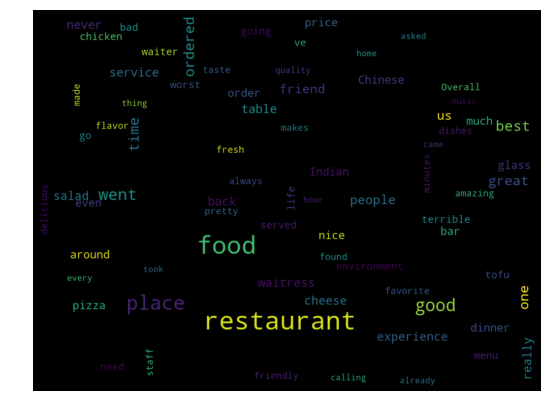

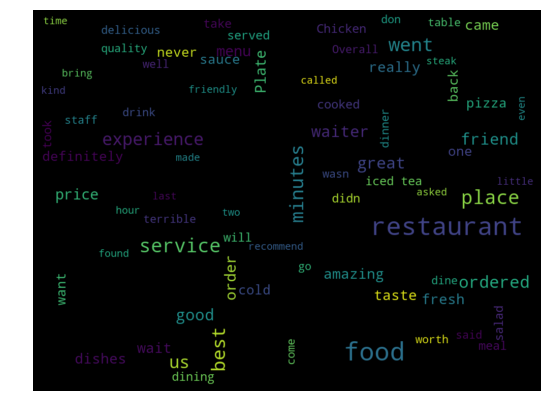

version: 2 -- cleaned lie true feats length: 3362
version: 2 -- cleaned lie true unique feature count: 950
version: 2 -- cleaned lie false feats length: 3629
version: 2 -- cleaned lie false unique feature count: 944


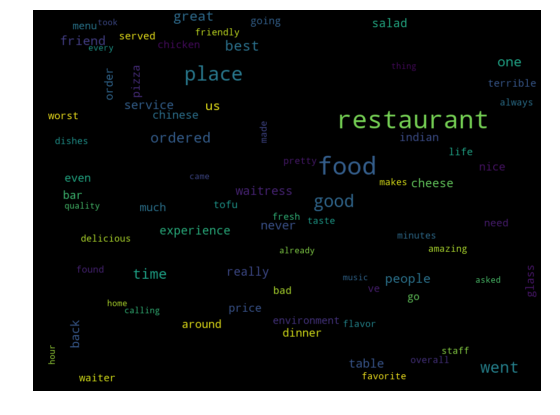

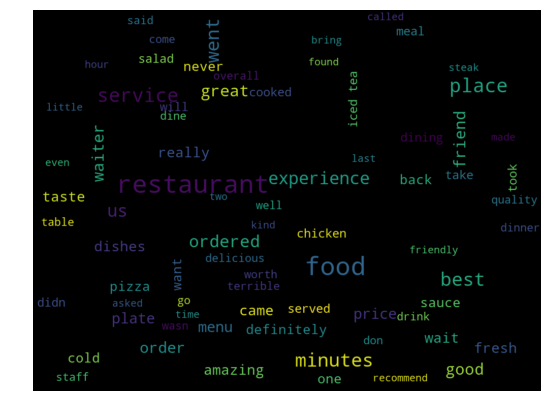

version: 3 -- cleaned lie true feats length: 1648
version: 3 -- cleaned lie true unique feature count: 832
version: 3 -- cleaned lie false feats length: 1789
version: 3 -- cleaned lie false unique feature count: 831


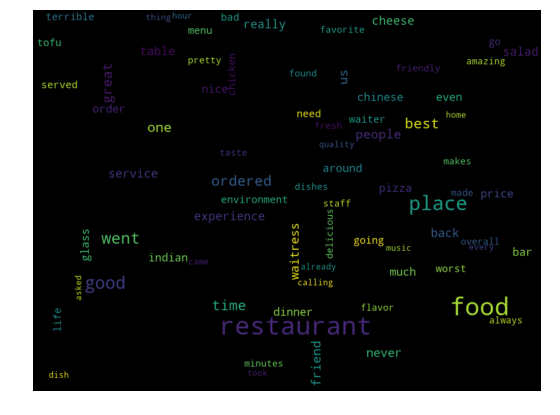

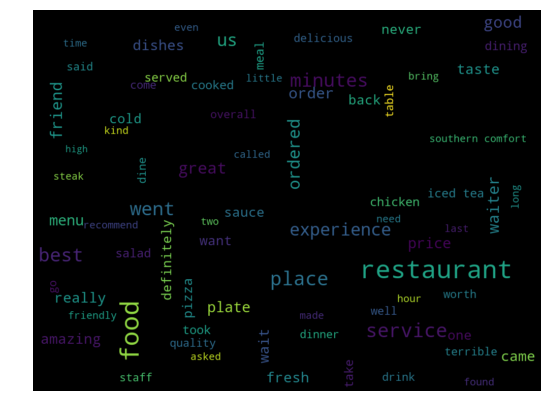

version: 4 -- cleaned lie true feats length: 1648
version: 4 -- cleaned lie true unique feature count: 733
version: 4 -- cleaned lie false feats length: 1789
version: 4 -- cleaned lie false unique feature count: 734


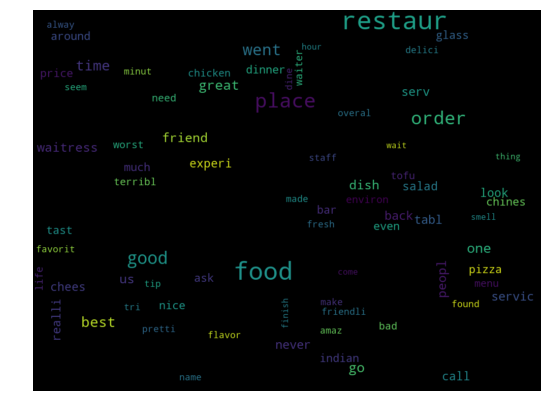

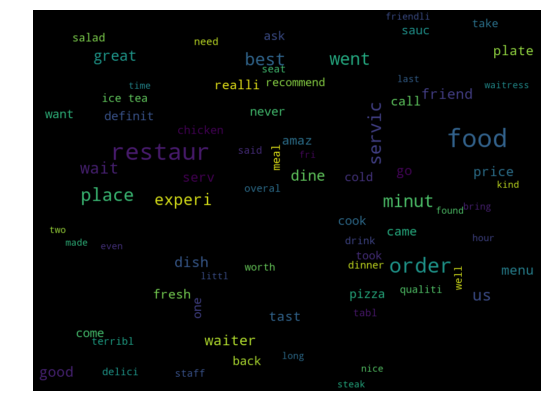

In [27]:
# create mulitple versions of a cleaned corpus for analysis

lie_cleaned_v1 = create_lie_cleaned_corpus(lie_kept_features_v1,corpusDir,lie_label_index_map,V=1)
lie_cleaned_v2 = create_lie_cleaned_corpus(lie_kept_features_v2,corpusDir,lie_label_index_map,V=2)
lie_cleaned_v3 = create_lie_cleaned_corpus(lie_kept_features_v3,corpusDir,lie_label_index_map,V=3)
lie_cleaned_v4 = create_lie_cleaned_corpus(lie_kept_features_v4,corpusDir,lie_label_index_map,V=4)


In [28]:
# top 10 true word frequencies
# Your code starts here
from IPython.display import HTML

HTML(br.bow_word_frequency(lie_cleaned_v1[0]).head(10).to_html(index=False))

In [29]:
HTML(br.bow_word_frequency(lie_cleaned_v1[2])[::-10].head(10).to_html(index=False))

## Sentiment EDA

In [30]:
# tokenize sentiment df - use wordpunct_tokenize
from nltk.tokenize import word_tokenize
sentiment_tokens_bow = []
sentiment_neg_tokens_bow = []
sentiment_pos_tokens_bow = []
sentiment_tokens_index_map = {}
sentiment_label_index_map = {}
for i in range(0, len(sentiment_df)):
    #logger.info(lie_df.iloc[i]['sentiment'] )
    #logger.info(lie_df.iloc[i]['review'])
    
    # tokenize
    doc_token = word_tokenize(sentiment_df.iloc[i]['review'])
    sentiment_tokens_index_map[i] = doc_token
    sentiment_label_index_map[i] = sentiment_df.iloc[i]['sentiment']
    #print(doc_token)
    for t in doc_token:
        sentiment_tokens_bow.append(t)
        if sentiment_df.iloc[i]['sentiment'] == 'p':
            sentiment_pos_tokens_bow.append(t)
        else:
            sentiment_neg_tokens_bow.append(t)
        
logger.info(f'Initial Sentiment Review Token Count: {len(sentiment_tokens_bow)}')
logger.info(f'Initial Sentiment Review Pos Token Count: {len(sentiment_pos_tokens_bow)}')
logger.info(f'Initial Sentiment Review Neg Token Count: {len(sentiment_neg_tokens_bow)}')

Initial Sentiment Review Token Count: 8077
Initial Sentiment Review Pos Token Count: 3350
Initial Sentiment Review Neg Token Count: 4727


### Perform Initial EDA on BoW for Sentiment Dataset

In [31]:
HTML(br.bow_word_frequency(sentiment_tokens_bow).head(10).to_html(index=False))

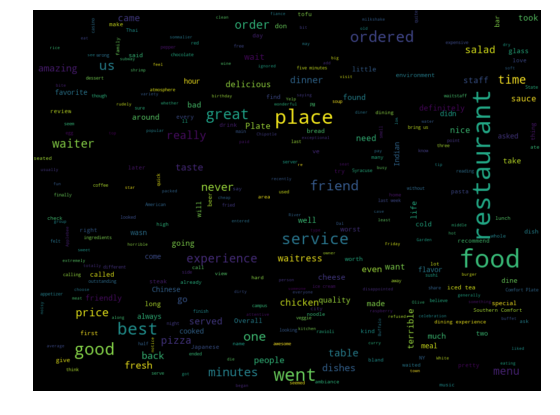

In [32]:
# initial word lie dataset - all
br.wordcloud_draw(sentiment_tokens_bow,color='black',max_words=300)

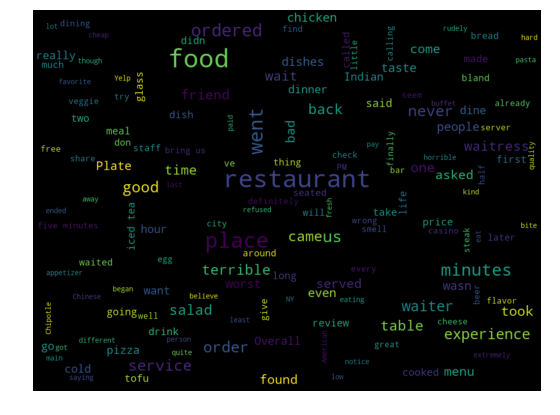

In [33]:
# initial word lie dataset - true
br.wordcloud_draw(sentiment_neg_tokens_bow,color='black',max_words=150)

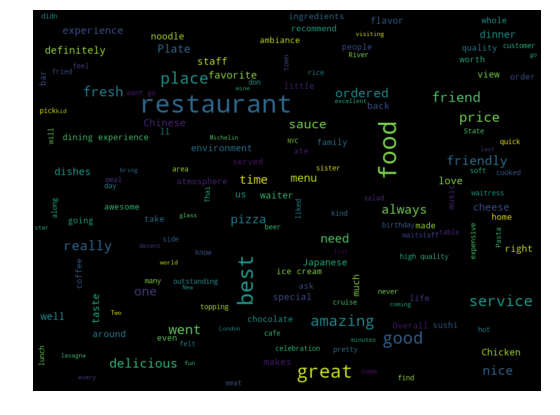

In [34]:
# initial word lie dataset - false
br.wordcloud_draw(sentiment_pos_tokens_bow,color='black',max_words=150)

### Clean Sentiment documents

In [35]:
def create_sent_cleaned_corpus(kept_features,corpusDir,sentiment_label_index_map,V):
    # write cleaned tokens to corpus files - file name formate <_{index}_{label}_lie_doc.txt>
    cleaned_pos_bow = []
    cleaned_neg_bow = []
    cleaned_pos_bow_unique = set()
    cleaned_neg_bow_unique = set()

    cleanedSentimentCorpDir = f'{corpusDir}/deception/cleaned/sentiment/v{V}'
    if not os.path.exists(cleanedSentimentCorpDir): os.makedirs(cleanedSentimentCorpDir)


    for index,feats in kept_features.items():
        if sentiment_label_index_map[index] == 'p':
            for f in feats:
                cleaned_pos_bow.append(f)
                cleaned_pos_bow_unique.add(f)
        else:
            for f in feats:
                cleaned_neg_bow.append(f)
                cleaned_neg_bow_unique.add(f)

        with io.open(f'{cleanedSentimentCorpDir}/_{index}_{sentiment_label_index_map[index]}_sentiment_doc.txt','w+',encoding='utf8') as f:
            f.write(' '.join([feat for feat in feats]))

    logger.info(f'version: {V} -- cleaned sentiment pos feats length: {len(cleaned_pos_bow)}')
    logger.info(f'version: {V} -- cleaned sentiment pos unique feature count: {len(cleaned_pos_bow_unique)}')
    logger.info(f'version: {V} -- cleaned sentiment neg feats length: {len(cleaned_neg_bow)}')
    logger.info(f'version: {V} -- cleaned sentiment neg unique feature count: {len(cleaned_neg_bow_unique)}')

    # cleaned word cloud lie dataset - true
    br.wordcloud_draw(cleaned_pos_bow,color='black',max_words=75)
    
    # cleaned word cloud lie dataset - false
    br.wordcloud_draw(cleaned_neg_bow,color='black',max_words=75)
    
    return cleaned_pos_bow, cleaned_pos_bow_unique, cleaned_neg_bow, cleaned_neg_bow_unique

### Create a corpus of cleaned documents to be used in vectorization process

In [36]:
# keep track of version to test different combinations of cleaning parameters

#V = 1 # base line --> lower_case=False, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False
#V = 2 #           --> lower_case=True, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False
#V = 3 #           --> lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=False
#V = 4 # stemming  --> lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=True

sent_kept_features_v1 = clean_features(sentiment_tokens_index_map.copy(),lower_case=False, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False)
sent_kept_features_v2 = clean_features(sentiment_tokens_index_map.copy(),lower_case=True, stop_words=False, remove_punc=False, remove_non_alphabetic=True, stemming=False)
sent_kept_features_v3 = clean_features(sentiment_tokens_index_map.copy(),lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=False)
sent_kept_features_v4 = clean_features(sentiment_tokens_index_map.copy(),lower_case=True, stop_words=True, remove_punc=True, remove_non_alphabetic=True, stemming=True)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rt310\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!

text: 0 | feature length prior to text cleaning steps: 52
Total Tokens Prior To Cleaning: 52
text: 0 | After non alphabetic removal: 42

text: 1 | feature length prior to text cleaning steps: 72
Total Tokens Prior To Cleaning: 124
text: 1 | After non alphabetic removal: 61

text: 2 | feature length prior to text cleaning steps: 28
Total Tokens Prior To Cleaning: 152
text: 2 | After non alphabetic removal: 23

text: 3 | feature length prior to text cleaning steps: 53
Total Tokens Prior To Cleaning: 205
text: 3 | After non alphabetic removal: 41

text: 4 | feature length prior to text cleaning steps: 75
Total Tokens Prior To Cleaning: 280
text: 4 | After non alphabetic removal: 65

text: 5 | feature length prior to text cleaning steps: 127
Total Tokens Prior To Cleaning: 407
text: 5 | After non alphabetic removal: 113

text: 6 | feature 

Total Tokens Prior To Cleaning: 5336
text: 57 | After non alphabetic removal: 54

text: 58 | feature length prior to text cleaning steps: 44
Total Tokens Prior To Cleaning: 5380
text: 58 | After non alphabetic removal: 38

text: 59 | feature length prior to text cleaning steps: 206
Total Tokens Prior To Cleaning: 5586
text: 59 | After non alphabetic removal: 172

text: 60 | feature length prior to text cleaning steps: 81
Total Tokens Prior To Cleaning: 5667
text: 60 | After non alphabetic removal: 69

text: 61 | feature length prior to text cleaning steps: 59
Total Tokens Prior To Cleaning: 5726
text: 61 | After non alphabetic removal: 52

text: 62 | feature length prior to text cleaning steps: 110
Total Tokens Prior To Cleaning: 5836
text: 62 | After non alphabetic removal: 85

text: 63 | feature length prior to text cleaning steps: 71
Total Tokens Prior To Cleaning: 5907
text: 63 | After non alphabetic removal: 64

text: 64 | feature length prior to text cleaning steps: 82
Total Toke

text: 19 | After lower case: 229

text: 20 | feature length prior to text cleaning steps: 116
Total Tokens Prior To Cleaning: 2149
text: 20 | After non alphabetic removal: 97
text: 20 | After lower case: 97

text: 21 | feature length prior to text cleaning steps: 125
Total Tokens Prior To Cleaning: 2274
text: 21 | After non alphabetic removal: 97
text: 21 | After lower case: 97

text: 22 | feature length prior to text cleaning steps: 165
Total Tokens Prior To Cleaning: 2439
text: 22 | After non alphabetic removal: 149
text: 22 | After lower case: 149

text: 23 | feature length prior to text cleaning steps: 45
Total Tokens Prior To Cleaning: 2484
text: 23 | After non alphabetic removal: 38
text: 23 | After lower case: 38

text: 24 | feature length prior to text cleaning steps: 43
Total Tokens Prior To Cleaning: 2527
text: 24 | After non alphabetic removal: 36
text: 24 | After lower case: 36

text: 25 | feature length prior to text cleaning steps: 29
Total Tokens Prior To Cleaning: 2556


Total Tokens Prior To Cleaning: 6374
text: 67 | After non alphabetic removal: 114
text: 67 | After lower case: 114

text: 68 | feature length prior to text cleaning steps: 73
Total Tokens Prior To Cleaning: 6447
text: 68 | After non alphabetic removal: 65
text: 68 | After lower case: 65

text: 69 | feature length prior to text cleaning steps: 59
Total Tokens Prior To Cleaning: 6506
text: 69 | After non alphabetic removal: 52
text: 69 | After lower case: 52

text: 70 | feature length prior to text cleaning steps: 50
Total Tokens Prior To Cleaning: 6556
text: 70 | After non alphabetic removal: 43
text: 70 | After lower case: 43

text: 71 | feature length prior to text cleaning steps: 31
Total Tokens Prior To Cleaning: 6587
text: 71 | After non alphabetic removal: 25
text: 71 | After lower case: 25

text: 72 | feature length prior to text cleaning steps: 94
Total Tokens Prior To Cleaning: 6681
text: 72 | After non alphabetic removal: 75
text: 72 | After lower case: 75

text: 73 | feature 

Total Tokens Prior To Cleaning: 1568
text: 16 | After punctuation removal: 93
text: 16 | After non alphabetic removal: 74
text: 16 | After lower case: 74
text: 16 | After stop word removal: 38

text: 17 | feature length prior to text cleaning steps: 96
Total Tokens Prior To Cleaning: 1664
text: 17 | After punctuation removal: 96
text: 17 | After non alphabetic removal: 88
text: 17 | After lower case: 88
text: 17 | After stop word removal: 41

text: 18 | feature length prior to text cleaning steps: 86
Total Tokens Prior To Cleaning: 1750
text: 18 | After punctuation removal: 86
text: 18 | After non alphabetic removal: 68
text: 18 | After lower case: 68
text: 18 | After stop word removal: 31

text: 19 | feature length prior to text cleaning steps: 283
Total Tokens Prior To Cleaning: 2033
text: 19 | After punctuation removal: 283
text: 19 | After non alphabetic removal: 239
text: 19 | After lower case: 239
text: 19 | After stop word removal: 114

text: 20 | feature length prior to text cl

text: 48 | After non alphabetic removal: 27
text: 48 | After lower case: 27
text: 48 | After stop word removal: 12

text: 49 | feature length prior to text cleaning steps: 44
Total Tokens Prior To Cleaning: 4873
text: 49 | After punctuation removal: 44
text: 49 | After non alphabetic removal: 37
text: 49 | After lower case: 37
text: 49 | After stop word removal: 24

text: 50 | feature length prior to text cleaning steps: 48
Total Tokens Prior To Cleaning: 4921
text: 50 | After punctuation removal: 48
text: 50 | After non alphabetic removal: 42
text: 50 | After lower case: 42
text: 50 | After stop word removal: 21

text: 51 | feature length prior to text cleaning steps: 71
Total Tokens Prior To Cleaning: 4992
text: 51 | After punctuation removal: 71
text: 51 | After non alphabetic removal: 64
text: 51 | After lower case: 64
text: 51 | After stop word removal: 36

text: 52 | feature length prior to text cleaning steps: 63
Total Tokens Prior To Cleaning: 5055
text: 52 | After punctuation 


text: 81 | feature length prior to text cleaning steps: 40
Total Tokens Prior To Cleaning: 7387
text: 81 | After punctuation removal: 40
text: 81 | After non alphabetic removal: 36
text: 81 | After lower case: 36
text: 81 | After stop word removal: 19

text: 82 | feature length prior to text cleaning steps: 64
Total Tokens Prior To Cleaning: 7451
text: 82 | After punctuation removal: 64
text: 82 | After non alphabetic removal: 56
text: 82 | After lower case: 56
text: 82 | After stop word removal: 24

text: 83 | feature length prior to text cleaning steps: 102
Total Tokens Prior To Cleaning: 7553
text: 83 | After punctuation removal: 102
text: 83 | After non alphabetic removal: 16
text: 83 | After lower case: 16
text: 83 | After stop word removal: 7

text: 84 | feature length prior to text cleaning steps: 63
Total Tokens Prior To Cleaning: 7616
text: 84 | After punctuation removal: 63
text: 84 | After non alphabetic removal: 58
text: 84 | After lower case: 58
text: 84 | After stop word

text: 20 | After punctuation removal: 116
text: 20 | After non alphabetic removal: 101
text: 20 | After lower case: 101
text: 20 | After stop word removal: 46
text: 20 | After stemming: 46

text: 21 | feature length prior to text cleaning steps: 125
Total Tokens Prior To Cleaning: 2274
text: 21 | After punctuation removal: 125
text: 21 | After non alphabetic removal: 105
text: 21 | After lower case: 105
text: 21 | After stop word removal: 47
text: 21 | After stemming: 47

text: 22 | feature length prior to text cleaning steps: 165
Total Tokens Prior To Cleaning: 2439
text: 22 | After punctuation removal: 165
text: 22 | After non alphabetic removal: 149
text: 22 | After lower case: 149
text: 22 | After stop word removal: 74
text: 22 | After stemming: 74

text: 23 | feature length prior to text cleaning steps: 45
Total Tokens Prior To Cleaning: 2484
text: 23 | After punctuation removal: 45
text: 23 | After non alphabetic removal: 39
text: 23 | After lower case: 39
text: 23 | After stop w

Total Tokens Prior To Cleaning: 4873
text: 49 | After punctuation removal: 44
text: 49 | After non alphabetic removal: 37
text: 49 | After lower case: 37
text: 49 | After stop word removal: 24
text: 49 | After stemming: 24

text: 50 | feature length prior to text cleaning steps: 48
Total Tokens Prior To Cleaning: 4921
text: 50 | After punctuation removal: 48
text: 50 | After non alphabetic removal: 42
text: 50 | After lower case: 42
text: 50 | After stop word removal: 21
text: 50 | After stemming: 21

text: 51 | feature length prior to text cleaning steps: 71
Total Tokens Prior To Cleaning: 4992
text: 51 | After punctuation removal: 71
text: 51 | After non alphabetic removal: 64
text: 51 | After lower case: 64
text: 51 | After stop word removal: 36
text: 51 | After stemming: 36

text: 52 | feature length prior to text cleaning steps: 63
Total Tokens Prior To Cleaning: 5055
text: 52 | After punctuation removal: 63
text: 52 | After non alphabetic removal: 55
text: 52 | After lower case: 

Total Tokens Prior To Cleaning: 7173
text: 78 | After punctuation removal: 107
text: 78 | After non alphabetic removal: 98
text: 78 | After lower case: 98
text: 78 | After stop word removal: 49
text: 78 | After stemming: 49

text: 79 | feature length prior to text cleaning steps: 92
Total Tokens Prior To Cleaning: 7265
text: 79 | After punctuation removal: 92
text: 79 | After non alphabetic removal: 80
text: 79 | After lower case: 80
text: 79 | After stop word removal: 36
text: 79 | After stemming: 36

text: 80 | feature length prior to text cleaning steps: 82
Total Tokens Prior To Cleaning: 7347
text: 80 | After punctuation removal: 82
text: 80 | After non alphabetic removal: 71
text: 80 | After lower case: 71
text: 80 | After stop word removal: 30
text: 80 | After stemming: 30

text: 81 | feature length prior to text cleaning steps: 40
Total Tokens Prior To Cleaning: 7387
text: 81 | After punctuation removal: 40
text: 81 | After non alphabetic removal: 36
text: 81 | After lower case:

version: 1 -- cleaned sentiment pos feats length: 2749
version: 1 -- cleaned sentiment pos unique feature count: 850
version: 1 -- cleaned sentiment neg feats length: 3941
version: 1 -- cleaned sentiment neg unique feature count: 1050


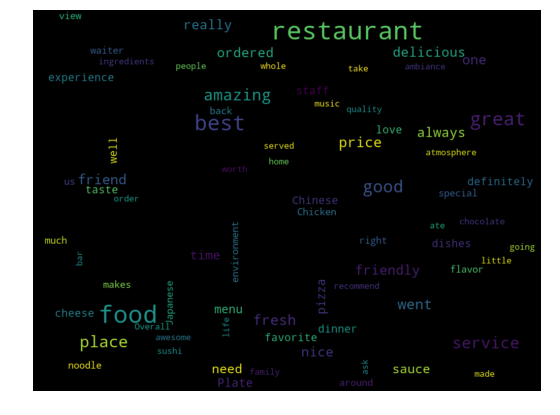

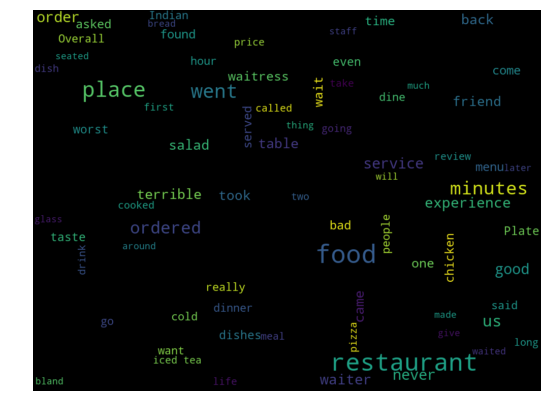

version: 2 -- cleaned sentiment pos feats length: 2749
version: 2 -- cleaned sentiment pos unique feature count: 789
version: 2 -- cleaned sentiment neg feats length: 3941
version: 2 -- cleaned sentiment neg unique feature count: 966


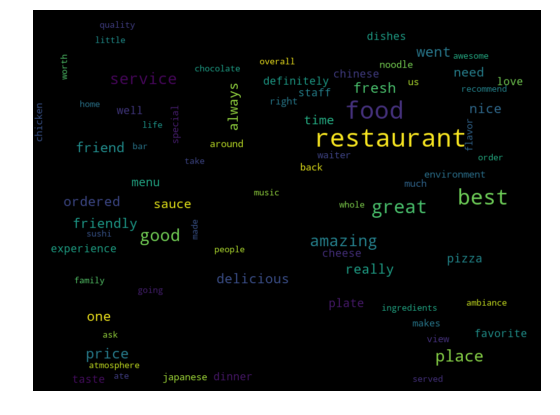

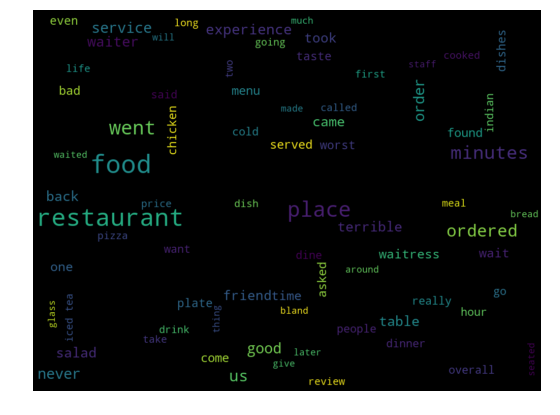

version: 3 -- cleaned sentiment pos feats length: 1468
version: 3 -- cleaned sentiment pos unique feature count: 724
version: 3 -- cleaned sentiment neg feats length: 1993
version: 3 -- cleaned sentiment neg unique feature count: 896


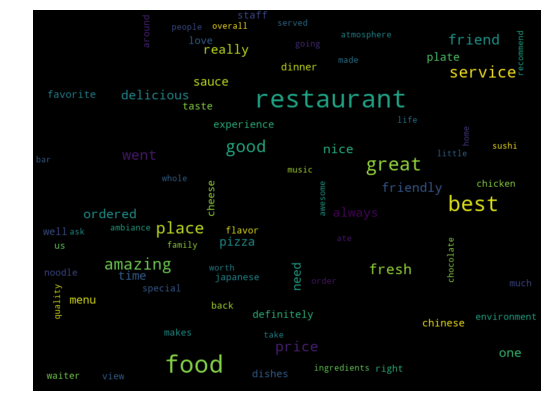

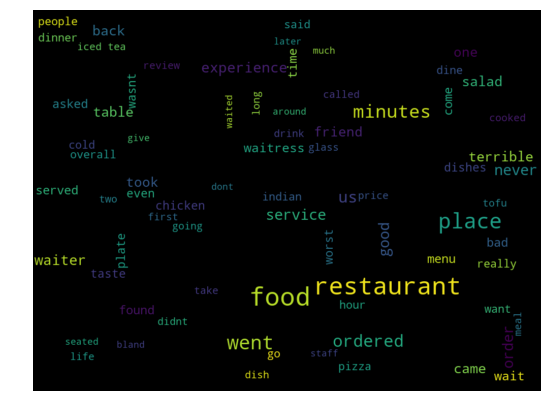

version: 4 -- cleaned sentiment pos feats length: 1468
version: 4 -- cleaned sentiment pos unique feature count: 644
version: 4 -- cleaned sentiment neg feats length: 1993
version: 4 -- cleaned sentiment neg unique feature count: 799


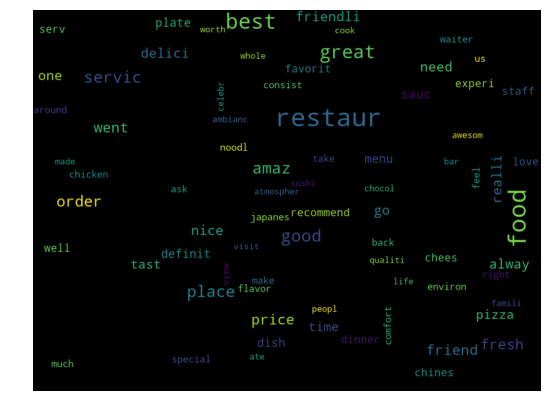

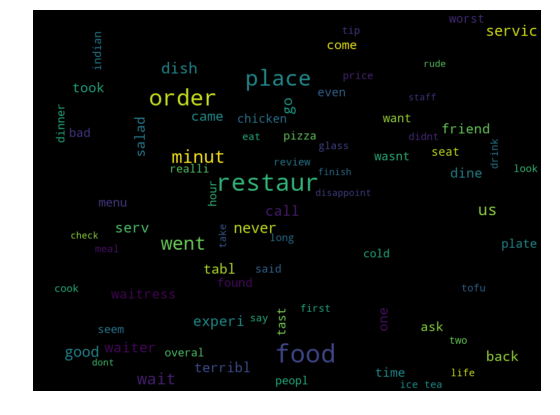

In [37]:
# create mulitple versions of a cleaned corpus for analysis

sent_cleaned_v1 = create_sent_cleaned_corpus(sent_kept_features_v1,corpusDir,sentiment_label_index_map,V=1)
sent_cleaned_v2 = create_sent_cleaned_corpus(sent_kept_features_v2,corpusDir,sentiment_label_index_map,V=2)
sent_cleaned_v3 = create_sent_cleaned_corpus(sent_kept_features_v3,corpusDir,sentiment_label_index_map,V=3)
sent_cleaned_v4 = create_sent_cleaned_corpus(sent_kept_features_v4,corpusDir,sentiment_label_index_map,V=4)


In [38]:
# top 10 true word frequencies
# Your code starts here
from IPython.display import HTML

HTML(br.bow_word_frequency(sent_cleaned_v1[0]).head(10).to_html(index=False))

In [39]:
# positive version 2
HTML(br.bow_word_frequency(sent_cleaned_v2[0]).head(10).to_html(index=False))

In [40]:
# positive version 3
HTML(br.bow_word_frequency(sent_cleaned_v3[0]).head(10).to_html(index=False))

In [41]:
# positive version 4 - stemming
HTML(br.bow_word_frequency(sent_cleaned_v4[0]).head(10).to_html(index=False))

In [42]:
# top negative
HTML(br.bow_word_frequency(sent_cleaned_v1[2]).head(10).to_html(index=False))

In [43]:
# top negative
HTML(br.bow_word_frequency(sent_cleaned_v2[2]).head(10).to_html(index=False))

In [44]:
# top negative
HTML(br.bow_word_frequency(sent_cleaned_v3[2]).head(10).to_html(index=False))

In [45]:
# top negative
HTML(br.bow_word_frequency(sent_cleaned_v4[2]).head(10).to_html(index=False))

## 3. MODEL
_________________________________________________________________________________________________
Create models

### 3.1 Model Analysis
perform model creation and validation techniques

In [46]:
# function to get the directory path location of corpus files to vectorize
def get_cleaned_corpus_by_version(path,category,version):
    _files = []
    _filenames = {}
    path = f'{path}/v{version}'
    
    for dirpath, dirs, files in os.walk(path):
        #print(dirpath)
        #print(dirs)
        #print(files)
        for i,f in enumerate(files):
            _files.append(dirpath+'/'+f)
            file_tokens = f.split('_')
            doc_index =  file_tokens[1]
            #print(doc_index)
            #break

            _filenames[int(doc_index)] = f

    logger.info(f'corpus:{category}, version:{version}, _files collected: {len(_files)}')
    logger.info(f'corpus:{category}, version:{version} _filenames collected: {len(_filenames)}')
    
    return _files, _filenames
    

In [47]:
def save_feature_vectors_by_version(save_as_file,version,vectorizer,filenames,id_map):
    
    outputDirVersion = f'{outputDir}/v{version}'
    if not os.path.exists(outputDirVersion): os.makedirs(outputDirVersion)
    
    save_as = f'{outputDirVersion}/{save_as_file}'
    logger.debug(f'save_feature_vectors_by_version: features:\n{vectorizer[2]}')
    logger.debug(f'save_feature_vectors_by_version: vectorizer:\n{vectorizer[1]}')
    logger.debug(f'save_feature_vectors_by_version: filenames:\n{filenames}')
    logger.debug(f'save_feature_vectors_by_version: id_map:\n{id_map}')
    
    br.output_feature_vector(logger,save_as,vectorizer[2],vectorizer[1],filenames,id_map)
    #output_feature_vector(logger,save_as,vectorizer[2],vectorizer[1],filenames,id_map)

In [48]:
# get directory and files for all test versions of corpus to be vectorized

path_lie = f'{corpusDir}/deception/cleaned/lie'
path_sent = f'{corpusDir}/deception/cleaned/sentiment'

# get lie cleanded corpuses by version
clean_corp_lie_v1 = get_cleaned_corpus_by_version(path_lie,'lie',version=1)
clean_corp_lie_v2 = get_cleaned_corpus_by_version(path_lie,'lie',version=2)
clean_corp_lie_v3 = get_cleaned_corpus_by_version(path_lie,'lie',version=3)
clean_corp_lie_v4 = get_cleaned_corpus_by_version(path_lie,'lie',version=4)

# get sentiment cleaned corpuses by version
clean_corp_sent_v1 = get_cleaned_corpus_by_version(path_sent,'sentiment',version=1)
clean_corp_sent_v2 = get_cleaned_corpus_by_version(path_sent,'sentiment',version=2)
clean_corp_sent_v3 = get_cleaned_corpus_by_version(path_sent,'sentiment',version=3)
clean_corp_sent_v4 = get_cleaned_corpus_by_version(path_sent,'sentiment',version=4)


corpus:lie, version:1, _files collected: 90
corpus:lie, version:1 _filenames collected: 90
corpus:lie, version:2, _files collected: 90
corpus:lie, version:2 _filenames collected: 90
corpus:lie, version:3, _files collected: 90
corpus:lie, version:3 _filenames collected: 90
corpus:lie, version:4, _files collected: 90
corpus:lie, version:4 _filenames collected: 90
corpus:sentiment, version:1, _files collected: 90
corpus:sentiment, version:1 _filenames collected: 90
corpus:sentiment, version:2, _files collected: 90
corpus:sentiment, version:2 _filenames collected: 90
corpus:sentiment, version:3, _files collected: 90
corpus:sentiment, version:3 _filenames collected: 90
corpus:sentiment, version:4, _files collected: 90
corpus:sentiment, version:4 _filenames collected: 90


### 3.2 Model Exploration
Benoulli and Multinomial Naïve Bayes

In [49]:
# create vectors for Benoulli and Multinomial Naïve Bayes
# initialize a CountVectorizer object:
# Initialize a unigram vector object
count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2)
count_vec_unigram_bool = br.inst_vectorizer('unigram','count',binary=True,min_df=2)

tfidf_vec_unigram = br.inst_vectorizer('unigram','tfidf',min_df=2)
tfidf_vec_unigram_bool = br.inst_vectorizer('unigram','tfidf',binary=True,min_df=2)
#-------------------------------------------------------#
# Initialize a bigram vector object
count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2)
count_vec_bigram_bool = br.inst_vectorizer('bigram','count',binary=True,min_df=2)

tfidf_vec_bigram = br.inst_vectorizer('bigram','tfidf',min_df=2)
tfidf_vec_bigram_bool = br.inst_vectorizer('bigram','tfidf',binary=True,min_df=2)
#-------------------------------------------------------#

# Initialize a trigram vector object
count_vec_trigram = br.inst_vectorizer('trigram','count',min_df=2)
count_vec_trigram_bool = br.inst_vectorizer('trigram','count',min_df=2,binary=True)

tfidf_vec_trigram = br.inst_vectorizer('trigram','tfidf',min_df=2)
tfidf_vec_trigram_bool = br.inst_vectorizer('trigram','tfidf',min_df=2,binary=True)
#-------------------------------------------------------#

### Train Vectorizers vectors

In [50]:
lie_mnb_feature_vec_files = []
lie_bnb_feature_vec_files = []
sent_mnb_feature_vec_files = []
sent_bnb_feature_vec_files = []

def train_vectors_by_corp_version(save_name, vectorizer, corp_version, category=None, v_type='count', version=1):
    vec = br.train_vector(logger, vectorizer, corp_version[0], category=category, v_type=v_type, version=version)
    vec_id_map = br.compress_text_representation(logger, vec[0])
    
    # save feature vectors to file
    save_feature_vectors_by_version(f'{save_name}_v{version}.txt',version=version,
                                vectorizer=vec,
                                filenames=corp_version[1],
                                id_map=vec_id_map[0])
    
    if category == 'lie' and 'bool' in save_name:
        lie_bnb_feature_vec_files.append(f'{save_name}_v{version}.txt')
    elif category == 'lie' and not 'bool' in save_name:
        lie_mnb_feature_vec_files.append(f'{save_name}_v{version}.txt')
    elif category == 'sent' and 'bool' in save_name:
        sent_bnb_feature_vec_files.append(f'{save_name}_v{version}.txt')
    elif category == 'sent' and not 'bool' in save_name:
        sent_mnb_feature_vec_files.append(f'{save_name}_v{version}.txt')
    else:
        logger.warn(f'**WARNING** save_name:[{save_name}] | category:[{category}] ---> UNKNOWN')
    
    return vec, vec_id_map

In [51]:
# train vector - returns tuple as (fit, transform, features, voc_df)

#----Train Lie Vectorizers-----------#
##----CountVectorizers--------------##
###----Corpus Version 1------------###
####----UNIGRAM-------------------####
lie_cnt_vec_unigram_v1 = train_vectors_by_corp_version('lie_cnt_vec_unigram',count_vec_unigram,clean_corp_lie_v1,category='lie', v_type='count', version=1)
lie_cnt_vec_unigram_v2 = train_vectors_by_corp_version('lie_cnt_vec_unigram',count_vec_unigram,clean_corp_lie_v2,category='lie', v_type='count', version=2)
lie_cnt_vec_unigram_v3 = train_vectors_by_corp_version('lie_cnt_vec_unigram',count_vec_unigram,clean_corp_lie_v3,category='lie', v_type='count', version=3)
lie_cnt_vec_unigram_v4 = train_vectors_by_corp_version('lie_cnt_vec_unigram',count_vec_unigram,clean_corp_lie_v4,category='lie', v_type='count', version=4)

# boolean binary vectorizer for Benoulli Modeling
lie_cnt_vec_unigram_bool_v1 = train_vectors_by_corp_version('lie_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_lie_v1,category='lie', v_type='count', version=1)
lie_cnt_vec_unigram_bool_v2 = train_vectors_by_corp_version('lie_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_lie_v2,category='lie', v_type='count', version=2)
lie_cnt_vec_unigram_bool_v3 = train_vectors_by_corp_version('lie_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_lie_v3,category='lie', v_type='count', version=3)
lie_cnt_vec_unigram_bool_v4 = train_vectors_by_corp_version('lie_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_lie_v4,category='lie', v_type='count', version=4)

####----BIGRAM-------------------####
lie_cnt_vec_bigram_v1 = train_vectors_by_corp_version('lie_cnt_vec_bigram',count_vec_bigram,clean_corp_lie_v1,category='lie', v_type='count', version=1)
lie_cnt_vec_bigram_v2 = train_vectors_by_corp_version('lie_cnt_vec_bigram',count_vec_bigram,clean_corp_lie_v2,category='lie', v_type='count', version=2)
lie_cnt_vec_bigram_v3 = train_vectors_by_corp_version('lie_cnt_vec_bigram',count_vec_bigram,clean_corp_lie_v3,category='lie', v_type='count', version=3)
lie_cnt_vec_bigram_v4 = train_vectors_by_corp_version('lie_cnt_vec_bigram',count_vec_bigram,clean_corp_lie_v4,category='lie', v_type='count', version=4)

# boolean binary vectorizer for Benoulli Modeling
lie_cnt_vec_bigram_bool_v1 = train_vectors_by_corp_version('lie_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_lie_v1,category='lie', v_type='count', version=1)
lie_cnt_vec_bigram_bool_v2 = train_vectors_by_corp_version('lie_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_lie_v2,category='lie', v_type='count', version=2)
lie_cnt_vec_bigram_bool_v3 = train_vectors_by_corp_version('lie_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_lie_v3,category='lie', v_type='count', version=3)
lie_cnt_vec_bigram_bool_v4 = train_vectors_by_corp_version('lie_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_lie_v4,category='lie', v_type='count', version=4)


##----TfidfVectorizers--------------##
####----UNIGRAM-------------------####
lie_tfidf_vec_unigram_v1 = train_vectors_by_corp_version('lie_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_lie_v1,category='lie', v_type='tfidf', version=1)
lie_tfidf_vec_unigram_v2 = train_vectors_by_corp_version('lie_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_lie_v2,category='lie', v_type='tfidf', version=2)
lie_tfidf_vec_unigram_v3 = train_vectors_by_corp_version('lie_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_lie_v3,category='lie', v_type='tfidf', version=3)
lie_tfidf_vec_unigram_v4 = train_vectors_by_corp_version('lie_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_lie_v4,category='lie', v_type='tfidf', version=4)

# boolean binary vectorizer for Benoulli Modeling
lie_tfidf_vec_unigram_bool_v1 = train_vectors_by_corp_version('lie_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_lie_v1,category='lie', v_type='tfidf', version=1)
lie_tfidf_vec_unigram_bool_v2 = train_vectors_by_corp_version('lie_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_lie_v2,category='lie', v_type='tfidf', version=2)
lie_tfidf_vec_unigram_bool_v3 = train_vectors_by_corp_version('lie_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_lie_v3,category='lie', v_type='tfidf', version=3)
lie_tfidf_vec_unigram_bool_v4 = train_vectors_by_corp_version('lie_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_lie_v4,category='lie', v_type='tfidf', version=4)

####----BIGRAM-------------------####
lie_tfidf_vec_bigram_v1 = train_vectors_by_corp_version('lie_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_lie_v1,category='lie', v_type='tfidf', version=1)
lie_tfidf_vec_bigram_v2 = train_vectors_by_corp_version('lie_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_lie_v2,category='lie', v_type='tfidf', version=2)
lie_tfidf_vec_bigram_v3 = train_vectors_by_corp_version('lie_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_lie_v3,category='lie', v_type='tfidf', version=3)
lie_tfidf_vec_bigram_v4 = train_vectors_by_corp_version('lie_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_lie_v4,category='lie', v_type='tfidf', version=4)

# boolean binary vectorizer for Benoulli Modeling
lie_tfidf_vec_bigram_bool_v1 = train_vectors_by_corp_version('lie_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_lie_v1,category='lie', v_type='tfidf', version=1)
lie_tfidf_vec_bigram_bool_v2 = train_vectors_by_corp_version('lie_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_lie_v2,category='lie', v_type='tfidf', version=2)
lie_tfidf_vec_bigram_bool_v3 = train_vectors_by_corp_version('lie_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_lie_v3,category='lie', v_type='tfidf', version=3)
lie_tfidf_vec_bigram_bool_v4 = train_vectors_by_corp_version('lie_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_lie_v4,category='lie', v_type='tfidf', version=4)



Vectorizer[count], category[lie], version[1] --> transformed shape: (90, 590)
Vectorizer[count], category[lie], version[1] --> transformed size: 3803
Vectorizer[count], category[lie], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[lie], version[1] --> vocabulary size: 590
Vector Top 20 Head:
        feature  feature_index
107   yourself            589
455       your            588
12         you            587
333       york            586
326       yelp            585
581       yeah            584
393        xyz            583
405      wrong            582
341      write            581
13       would            580
208      worth            579
139      worst            578
85       worse            577
531      world            576
558      words            575
469  wonderful            574
415    without            573
92        with            572
487       wine            571
90        will            570
Vectorizer[count], categ

Vectorizer[count], category[lie], version[2] --> transformed shape: (90, 1240)
Vectorizer[count], category[lie], version[2] --> transformed size: 5907
Vectorizer[count], category[lie], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[lie], version[2] --> vocabulary size: 1240
Vector Top 20 Head:
              feature  feature_index
1192    yourself and           1239
148         yourself           1238
913             your           1237
38         you would           1236
639           you to           1235
1209          you re           1234
1234          you ll           1233
957         you have           1232
1191         you don           1231
586          you are           1230
12               you           1229
643        york city           1228
626             york           1227
619             yelp           1226
1217            yeah           1225
799   xyz restaurant           1224
790              xyz           1223
813 

Vectorizer[tfidf], category[lie], version[2] --> transformed shape: (90, 590)
Vectorizer[tfidf], category[lie], version[2] --> transformed size: 3803
Vectorizer[tfidf], category[lie], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[lie], version[2] --> vocabulary size: 590
Vector Top 20 Head:
        feature  feature_index
107   yourself            589
455       your            588
12         you            587
333       york            586
326       yelp            585
581       yeah            584
393        xyz            583
405      wrong            582
341      write            581
13       would            580
208      worth            579
139      worst            578
85       worse            577
531      world            576
558      words            575
469  wonderful            574
415    without            573
92        with            572
487       wine            571
90        will            570
Vectorizer[tfidf], categ

Vectorizer[tfidf], category[lie], version[3] --> transformed shape: (90, 646)
Vectorizer[tfidf], category[lie], version[3] --> transformed size: 2519
Vectorizer[tfidf], category[lie], version[3] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[lie], version[3] --> vocabulary size: 646
Vector Top 20 Head:
               feature  feature_index
316         york city            645
309              york            644
304              yelp            643
631              yeah            642
396    xyz restaurant            641
387               xyz            640
403             wrong            639
317             write            638
624     would totally            637
352   would recommend            636
40        would never            635
555  would definitely            634
8               would            633
167             worth            632
422       worst thing            631
378  worst restaurant            630
100             worst    

In [52]:
#----Train sent Vectorizers-----------#
##----CountVectorizers--------------##
###----Corpus Version 1------------###
####----UNIGRAM-------------------####
sent_cnt_vec_unigram_v1 = train_vectors_by_corp_version('sent_cnt_vec_unigram',count_vec_unigram,clean_corp_sent_v1,category='sent', v_type='count', version=1)
sent_cnt_vec_unigram_v2 = train_vectors_by_corp_version('sent_cnt_vec_unigram',count_vec_unigram,clean_corp_sent_v2,category='sent', v_type='count', version=2)
sent_cnt_vec_unigram_v3 = train_vectors_by_corp_version('sent_cnt_vec_unigram',count_vec_unigram,clean_corp_sent_v3,category='sent', v_type='count', version=3)
sent_cnt_vec_unigram_v4 = train_vectors_by_corp_version('sent_cnt_vec_unigram',count_vec_unigram,clean_corp_sent_v4,category='sent', v_type='count', version=4)

# boolean binary vectorizer for Benoulli Modeling
sent_cnt_vec_unigram_bool_v1 = train_vectors_by_corp_version('sent_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_sent_v1,category='sent', v_type='count', version=1)
sent_cnt_vec_unigram_bool_v2 = train_vectors_by_corp_version('sent_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_sent_v2,category='sent', v_type='count', version=2)
sent_cnt_vec_unigram_bool_v3 = train_vectors_by_corp_version('sent_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_sent_v3,category='sent', v_type='count', version=3)
sent_cnt_vec_unigram_bool_v4 = train_vectors_by_corp_version('sent_cnt_vec_unigram_bool',count_vec_unigram_bool,clean_corp_sent_v4,category='sent', v_type='count', version=4)

####----BIGRAM-------------------####
sent_cnt_vec_bigram_v1 = train_vectors_by_corp_version('sent_cnt_vec_bigram',count_vec_bigram,clean_corp_sent_v1,category='sent', v_type='count', version=1)
sent_cnt_vec_bigram_v2 = train_vectors_by_corp_version('sent_cnt_vec_bigram',count_vec_bigram,clean_corp_sent_v2,category='sent', v_type='count', version=2)
sent_cnt_vec_bigram_v3 = train_vectors_by_corp_version('sent_cnt_vec_bigram',count_vec_bigram,clean_corp_sent_v3,category='sent', v_type='count', version=3)
sent_cnt_vec_bigram_v4 = train_vectors_by_corp_version('sent_cnt_vec_bigram',count_vec_bigram,clean_corp_sent_v4,category='sent', v_type='count', version=4)

# boolean binary vectorizer for Benoulli Modeling
sent_cnt_vec_bigram_bool_v1 = train_vectors_by_corp_version('sent_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_sent_v1,category='sent', v_type='count', version=1)
sent_cnt_vec_bigram_bool_v2 = train_vectors_by_corp_version('sent_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_sent_v2,category='sent', v_type='count', version=2)
sent_cnt_vec_bigram_bool_v3 = train_vectors_by_corp_version('sent_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_sent_v3,category='sent', v_type='count', version=3)
sent_cnt_vec_bigram_bool_v4 = train_vectors_by_corp_version('sent_cnt_vec_bigram_bool',count_vec_bigram_bool,clean_corp_sent_v4,category='sent', v_type='count', version=4)


####----TRIGRAM-------------------####
#sent_cnt_vec_trigram = br.train_vector(logger, count_vec_trigram, _files_sents)
#sent_cnt_vec_trigram_id_map = br.compress_text_representation(logger, sent_cnt_vec_trigram[0])                                     
###----Corpus Version 2------------###



##----TfidfVectorizers--------------##
####----UNIGRAM-------------------####
sent_tfidf_vec_unigram_v1 = train_vectors_by_corp_version('sent_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_sent_v1,category='sent', v_type='tfidf', version=1)
sent_tfidf_vec_unigram_v2 = train_vectors_by_corp_version('sent_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_sent_v2,category='sent', v_type='tfidf', version=2)
sent_tfidf_vec_unigram_v3 = train_vectors_by_corp_version('sent_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_sent_v3,category='sent', v_type='tfidf', version=3)
sent_tfidf_vec_unigram_v4 = train_vectors_by_corp_version('sent_tfidf_vec_unigram',tfidf_vec_unigram,clean_corp_sent_v4,category='sent', v_type='tfidf', version=4)

# boolean binary vectorizer for Benoulli Modeling
sent_tfidf_vec_unigram_bool_v1 = train_vectors_by_corp_version('sent_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_sent_v1,category='sent', v_type='tfidf', version=1)
sent_tfidf_vec_unigram_bool_v2 = train_vectors_by_corp_version('sent_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_sent_v2,category='sent', v_type='tfidf', version=2)
sent_tfidf_vec_unigram_bool_v3 = train_vectors_by_corp_version('sent_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_sent_v3,category='sent', v_type='tfidf', version=3)
sent_tfidf_vec_unigram_bool_v4 = train_vectors_by_corp_version('sent_tfidf_vec_unigram_bool',tfidf_vec_unigram_bool,clean_corp_sent_v4,category='sent', v_type='tfidf', version=4)

####----BIGRAM-------------------####
sent_tfidf_vec_bigram_v1 = train_vectors_by_corp_version('sent_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_sent_v1,category='sent', v_type='tfidf', version=1)
sent_tfidf_vec_bigram_v2 = train_vectors_by_corp_version('sent_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_sent_v2,category='sent', v_type='tfidf', version=2)
sent_tfidf_vec_bigram_v3 = train_vectors_by_corp_version('sent_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_sent_v3,category='sent', v_type='tfidf', version=3)
sent_tfidf_vec_bigram_v4 = train_vectors_by_corp_version('sent_tfidf_vec_bigram',tfidf_vec_bigram,clean_corp_sent_v4,category='sent', v_type='tfidf', version=4)

# boolean binary vectorizer for Benoulli Modeling
sent_tfidf_vec_bigram_bool_v1 = train_vectors_by_corp_version('sent_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_sent_v1,category='sent', v_type='tfidf', version=1)
sent_tfidf_vec_bigram_bool_v2 = train_vectors_by_corp_version('sent_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_sent_v2,category='sent', v_type='tfidf', version=2)
sent_tfidf_vec_bigram_bool_v3 = train_vectors_by_corp_version('sent_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_sent_v3,category='sent', v_type='tfidf', version=3)
sent_tfidf_vec_bigram_bool_v4 = train_vectors_by_corp_version('sent_tfidf_vec_bigram_bool',tfidf_vec_bigram_bool,clean_corp_sent_v4,category='sent', v_type='tfidf', version=4)


####----TRIGRAM-------------------####
#sent_tfidf_vec_trigram = br.train_vector(logger, tfidf_vec_trigram, _files_sents)
#sent_tfidf_vec_trigram_id_map = br.compress_text_representation(logger, sent_tfidf_vec_trigram[0])

Vectorizer[count], category[sent], version[1] --> transformed shape: (90, 574)
Vectorizer[count], category[sent], version[1] --> transformed size: 3702
Vectorizer[count], category[sent], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[sent], version[1] --> vocabulary size: 574
Vector Top 20 Head:
        feature  feature_index
103   yourself            573
442       your            572
12         you            571
323       york            570
317       yelp            569
380        xyz            568
392      wrong            567
332      write            566
13       would            565
204      worth            564
134      worst            563
81       worse            562
517      world            561
544      words            560
456  wonderful            559
403    without            558
88        with            557
475       wine            556
86        will            555
379        why            554
Vectorizer[count], c

Vectorizer[count], category[sent], version[2] --> transformed shape: (90, 1208)
Vectorizer[count], category[sent], version[2] --> transformed size: 5741
Vectorizer[count], category[sent], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[sent], version[2] --> vocabulary size: 1208
Vector Top 20 Head:
                feature  feature_index
1166      yourself and           1207
143           yourself           1206
898               your           1205
37           you would           1204
629             you to           1203
577            you are           1202
12                 you           1201
633          york city           1200
615               york           1199
609               yelp           1198
786     xyz restaurant           1197
777                xyz           1196
800              wrong           1195
649              write           1194
1177     would totally           1193
705          would not           1192
77

Vector Top 20 Head:
        feature  feature_index
103   yourself            573
442       your            572
12         you            571
323       york            570
317       yelp            569
380        xyz            568
392      wrong            567
332      write            566
13       would            565
204      worth            564
134      worst            563
81       worse            562
517      world            561
544      words            560
456  wonderful            559
403    without            558
88        with            557
475       wine            556
86        will            555
379        why            554
Vectorizer[tfidf], category[sent], version[2] --> transformed shape: (90, 574)
Vectorizer[tfidf], category[sent], version[2] --> transformed size: 3702
Vectorizer[tfidf], category[sent], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[sent], version[2] --> vocabulary size: 574
Vector Top 20 Head:


Vectorizer[tfidf], category[sent], version[2] --> transformed shape: (90, 1208)
Vectorizer[tfidf], category[sent], version[2] --> transformed size: 5741
Vectorizer[tfidf], category[sent], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[sent], version[2] --> vocabulary size: 1208
Vector Top 20 Head:
                feature  feature_index
1166      yourself and           1207
143           yourself           1206
898               your           1205
37           you would           1204
629             you to           1203
577            you are           1202
12                 you           1201
633          york city           1200
615               york           1199
609               yelp           1198
786     xyz restaurant           1197
777                xyz           1196
800              wrong           1195
649              write           1194
1177     would totally           1193
705          would not           1192
77

### Setup vectorized datasets for train/test splits

In [53]:
# one hot encoding for dataset labels

lie_labels = [l for l in lie_label_index_map.values()] 
sent_labels = [l for l in sentiment_label_index_map.values()]
lbe = LabelEncoder()
y_lie = lbe.fit_transform(lie_labels)
y_sent = lbe.fit_transform(sent_labels)
logger.info(f'y_lie encoded length: {len(y_lie)}')
logger.info(f'y_sent encoded length: {len(y_sent)}')

y_lie encoded length: 90
y_sent encoded length: 90


### LIE ----> Unigrams - CountVectorizers and TfidfVectorizers

In [54]:
X_train_lie_dfs_mnb = {}
X_train_lie_dfs_bnb = {}
X_train_sent_dfs_mnb = {}
X_train_sent_dfs_bnb = {}

In [55]:
#----------------------LIE------------------------------#
# unigrams -- CountVectorizers
X_lie_cnt_unigram_v1 = pd.DataFrame(lie_cnt_vec_unigram_v1[0][1].toarray(),columns=lie_cnt_vec_unigram_v1[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_unigram_v1'] = X_lie_cnt_unigram_v1

X_lie_cnt_unigram_v2 = pd.DataFrame(lie_cnt_vec_unigram_v2[0][1].toarray(),columns=lie_cnt_vec_unigram_v2[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_unigram_v2'] = X_lie_cnt_unigram_v2

X_lie_cnt_unigram_v3 = pd.DataFrame(lie_cnt_vec_unigram_v3[0][1].toarray(),columns=lie_cnt_vec_unigram_v3[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_unigram_v3'] = X_lie_cnt_unigram_v3

X_lie_cnt_unigram_v4 = pd.DataFrame(lie_cnt_vec_unigram_v4[0][1].toarray(),columns=lie_cnt_vec_unigram_v4[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_unigram_v4'] = X_lie_cnt_unigram_v4

## -- binary - NBN
X_lie_cnt_unigram_bool_v1 = pd.DataFrame(lie_cnt_vec_unigram_bool_v1[0][1].toarray(),columns=lie_cnt_vec_unigram_bool_v1[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_unigram_bool_v1'] = X_lie_cnt_unigram_bool_v1

X_lie_cnt_unigram_bool_v2 = pd.DataFrame(lie_cnt_vec_unigram_bool_v2[0][1].toarray(),columns=lie_cnt_vec_unigram_bool_v2[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_unigram_bool_v2'] = X_lie_cnt_unigram_bool_v2

X_lie_cnt_unigram_bool_v3 = pd.DataFrame(lie_cnt_vec_unigram_bool_v3[0][1].toarray(),columns=lie_cnt_vec_unigram_bool_v3[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_unigram_bool_v3'] = X_lie_cnt_unigram_bool_v3

X_lie_cnt_unigram_bool_v4 = pd.DataFrame(lie_cnt_vec_unigram_bool_v4[0][1].toarray(),columns=lie_cnt_vec_unigram_bool_v4[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_unigram_bool_v4'] = X_lie_cnt_unigram_bool_v4

# unigrams -- TfidfVectorizers
X_lie_tfidf_unigram_v1 = pd.DataFrame(lie_tfidf_vec_unigram_v1[0][1].toarray(),columns=lie_tfidf_vec_unigram_v1[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_unigram_v1'] = X_lie_tfidf_unigram_v1

X_lie_tfidf_unigram_v2 = pd.DataFrame(lie_tfidf_vec_unigram_v2[0][1].toarray(),columns=lie_tfidf_vec_unigram_v2[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_unigram_v2'] = X_lie_tfidf_unigram_v2

X_lie_tfidf_unigram_v3 = pd.DataFrame(lie_tfidf_vec_unigram_v3[0][1].toarray(),columns=lie_tfidf_vec_unigram_v3[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_unigram_v3'] = X_lie_tfidf_unigram_v3

X_lie_tfidf_unigram_v4 = pd.DataFrame(lie_tfidf_vec_unigram_v4[0][1].toarray(),columns=lie_tfidf_vec_unigram_v4[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_unigram_v4'] = X_lie_tfidf_unigram_v4

## -- binary - NBN
X_lie_tfidf_unigram_bool_v1 = pd.DataFrame(lie_tfidf_vec_unigram_bool_v1[0][1].toarray(),columns=lie_tfidf_vec_unigram_bool_v1[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_unigram_bool_v1'] = X_lie_tfidf_unigram_bool_v1

X_lie_tfidf_unigram_bool_v2 = pd.DataFrame(lie_tfidf_vec_unigram_bool_v2[0][1].toarray(),columns=lie_tfidf_vec_unigram_bool_v2[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_unigram_bool_v2'] = X_lie_tfidf_unigram_bool_v2

X_lie_tfidf_unigram_bool_v3 = pd.DataFrame(lie_tfidf_vec_unigram_bool_v3[0][1].toarray(),columns=lie_tfidf_vec_unigram_bool_v3[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_unigram_bool_v3'] = X_lie_tfidf_unigram_bool_v3

X_lie_tfidf_unigram_bool_v4 = pd.DataFrame(lie_tfidf_vec_unigram_bool_v4[0][1].toarray(),columns=lie_tfidf_vec_unigram_bool_v4[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_unigram_bool_v4'] = X_lie_tfidf_unigram_bool_v4


### LIE ---> BIGRAMS - CountVectorizers and TfidfVectorizers

In [56]:
#----------------------LIE------------------------------#
# bigrams -- CountVectorizers
X_lie_cnt_bigram_v1 = pd.DataFrame(lie_cnt_vec_bigram_v1[0][1].toarray(),columns=lie_cnt_vec_bigram_v1[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_bigram_v1'] = X_lie_cnt_bigram_v1

X_lie_cnt_bigram_v2 = pd.DataFrame(lie_cnt_vec_bigram_v2[0][1].toarray(),columns=lie_cnt_vec_bigram_v2[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_bigram_v2'] = X_lie_cnt_bigram_v2

X_lie_cnt_bigram_v3 = pd.DataFrame(lie_cnt_vec_bigram_v3[0][1].toarray(),columns=lie_cnt_vec_bigram_v3[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_bigram_v3'] = X_lie_cnt_bigram_v3

X_lie_cnt_bigram_v4 = pd.DataFrame(lie_cnt_vec_bigram_v4[0][1].toarray(),columns=lie_cnt_vec_bigram_v4[0][2])
X_train_lie_dfs_mnb['lie_cnt_vec_bigram_v4'] = X_lie_cnt_bigram_v4

## -- binary - NBN
X_lie_cnt_bigram_bool_v1 = pd.DataFrame(lie_cnt_vec_bigram_bool_v1[0][1].toarray(),columns=lie_cnt_vec_bigram_bool_v1[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_bigram_bool_v1'] = X_lie_cnt_bigram_bool_v1

X_lie_cnt_bigram_bool_v2 = pd.DataFrame(lie_cnt_vec_bigram_bool_v2[0][1].toarray(),columns=lie_cnt_vec_bigram_bool_v2[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_bigram_bool_v2'] = X_lie_cnt_bigram_bool_v2

X_lie_cnt_bigram_bool_v3 = pd.DataFrame(lie_cnt_vec_bigram_bool_v3[0][1].toarray(),columns=lie_cnt_vec_bigram_bool_v3[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_bigram_bool_v3'] = X_lie_cnt_bigram_bool_v3

X_lie_cnt_bigram_bool_v4 = pd.DataFrame(lie_cnt_vec_bigram_bool_v4[0][1].toarray(),columns=lie_cnt_vec_bigram_bool_v4[0][2])
X_train_lie_dfs_bnb['lie_cnt_vec_bigram_bool_v4'] = X_lie_cnt_bigram_bool_v4

# bigrams -- TfidfVectorizers
X_lie_tfidf_bigram_v1 = pd.DataFrame(lie_tfidf_vec_bigram_v1[0][1].toarray(),columns=lie_tfidf_vec_bigram_v1[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_bigram_v1'] = X_lie_tfidf_bigram_v1

X_lie_tfidf_bigram_v2 = pd.DataFrame(lie_tfidf_vec_bigram_v2[0][1].toarray(),columns=lie_tfidf_vec_bigram_v2[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_bigram_v2'] = X_lie_tfidf_bigram_v2

X_lie_tfidf_bigram_v3 = pd.DataFrame(lie_tfidf_vec_bigram_v3[0][1].toarray(),columns=lie_tfidf_vec_bigram_v3[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_bigram_v3'] = X_lie_tfidf_bigram_v3

X_lie_tfidf_bigram_v4 = pd.DataFrame(lie_tfidf_vec_bigram_v4[0][1].toarray(),columns=lie_tfidf_vec_bigram_v4[0][2])
X_train_lie_dfs_mnb['lie_tfidf_vec_bigram_v4'] = X_lie_tfidf_bigram_v4

## -- binary - NBN
X_lie_tfidf_bigram_bool_v1 = pd.DataFrame(lie_tfidf_vec_bigram_bool_v1[0][1].toarray(),columns=lie_tfidf_vec_bigram_bool_v1[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_bigram_bool_v1'] = X_lie_tfidf_bigram_bool_v1

X_lie_tfidf_bigram_bool_v2 = pd.DataFrame(lie_tfidf_vec_bigram_bool_v2[0][1].toarray(),columns=lie_tfidf_vec_bigram_bool_v2[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_bigram_bool_v2'] = X_lie_tfidf_bigram_bool_v2

X_lie_tfidf_bigram_bool_v3 = pd.DataFrame(lie_tfidf_vec_bigram_bool_v3[0][1].toarray(),columns=lie_tfidf_vec_bigram_bool_v3[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_bigram_bool_v3'] = X_lie_tfidf_bigram_bool_v3

X_lie_tfidf_bigram_bool_v4 = pd.DataFrame(lie_tfidf_vec_bigram_bool_v4[0][1].toarray(),columns=lie_tfidf_vec_bigram_bool_v4[0][2])
X_train_lie_dfs_bnb['lie_tfidf_vec_bigram_bool_v4'] = X_lie_tfidf_bigram_bool_v4

### SENTIMENT ----> Unigrams - CountVectorizers and TfidfVectorizers

In [57]:
#----------------------sent------------------------------#
# unigrams -- CountVectorizers
X_sent_cnt_unigram_v1 = pd.DataFrame(sent_cnt_vec_unigram_v1[0][1].toarray(),columns=sent_cnt_vec_unigram_v1[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_unigram_v1'] = X_sent_cnt_unigram_v1

X_sent_cnt_unigram_v2 = pd.DataFrame(sent_cnt_vec_unigram_v2[0][1].toarray(),columns=sent_cnt_vec_unigram_v2[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_unigram_v2'] = X_sent_cnt_unigram_v2

X_sent_cnt_unigram_v3 = pd.DataFrame(sent_cnt_vec_unigram_v3[0][1].toarray(),columns=sent_cnt_vec_unigram_v3[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_unigram_v3'] = X_sent_cnt_unigram_v3

X_sent_cnt_unigram_v4 = pd.DataFrame(sent_cnt_vec_unigram_v4[0][1].toarray(),columns=sent_cnt_vec_unigram_v4[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_unigram_v4'] = X_sent_cnt_unigram_v4

## -- binary - NBN
X_sent_cnt_unigram_bool_v1 = pd.DataFrame(sent_cnt_vec_unigram_bool_v1[0][1].toarray(),columns=sent_cnt_vec_unigram_bool_v1[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_unigram_bool_v1'] = X_sent_cnt_unigram_bool_v1

X_sent_cnt_unigram_bool_v2 = pd.DataFrame(sent_cnt_vec_unigram_bool_v2[0][1].toarray(),columns=sent_cnt_vec_unigram_bool_v2[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_unigram_bool_v2'] = X_sent_cnt_unigram_bool_v2

X_sent_cnt_unigram_bool_v3 = pd.DataFrame(sent_cnt_vec_unigram_bool_v3[0][1].toarray(),columns=sent_cnt_vec_unigram_bool_v3[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_unigram_bool_v3'] = X_sent_cnt_unigram_bool_v3

X_sent_cnt_unigram_bool_v4 = pd.DataFrame(sent_cnt_vec_unigram_bool_v4[0][1].toarray(),columns=sent_cnt_vec_unigram_bool_v4[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_unigram_bool_v4'] = X_sent_cnt_unigram_bool_v4

# unigrams -- TfidfVectorizers
X_sent_tfidf_unigram_v1 = pd.DataFrame(sent_tfidf_vec_unigram_v1[0][1].toarray(),columns=sent_tfidf_vec_unigram_v1[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_unigram_v1'] = X_sent_tfidf_unigram_v1

X_sent_tfidf_unigram_v2 = pd.DataFrame(sent_tfidf_vec_unigram_v2[0][1].toarray(),columns=sent_tfidf_vec_unigram_v2[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_unigram_v2'] = X_sent_tfidf_unigram_v2

X_sent_tfidf_unigram_v3 = pd.DataFrame(sent_tfidf_vec_unigram_v3[0][1].toarray(),columns=sent_tfidf_vec_unigram_v3[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_unigram_v3'] = X_sent_tfidf_unigram_v3

X_sent_tfidf_unigram_v4 = pd.DataFrame(sent_tfidf_vec_unigram_v4[0][1].toarray(),columns=sent_tfidf_vec_unigram_v4[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_unigram_v4'] = X_sent_tfidf_unigram_v4

## -- binary - NBN
X_sent_tfidf_unigram_bool_v1 = pd.DataFrame(sent_tfidf_vec_unigram_bool_v1[0][1].toarray(),columns=sent_tfidf_vec_unigram_bool_v1[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_unigram_bool_v1'] = X_sent_tfidf_unigram_bool_v1

X_sent_tfidf_unigram_bool_v2 = pd.DataFrame(sent_tfidf_vec_unigram_bool_v2[0][1].toarray(),columns=sent_tfidf_vec_unigram_bool_v2[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_unigram_bool_v2'] = X_sent_tfidf_unigram_bool_v2

X_sent_tfidf_unigram_bool_v3 = pd.DataFrame(sent_tfidf_vec_unigram_bool_v3[0][1].toarray(),columns=sent_tfidf_vec_unigram_bool_v3[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_unigram_bool_v3'] = X_sent_tfidf_unigram_bool_v3

X_sent_tfidf_unigram_bool_v4 = pd.DataFrame(sent_tfidf_vec_unigram_bool_v4[0][1].toarray(),columns=sent_tfidf_vec_unigram_bool_v4[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_unigram_bool_v4'] = X_sent_tfidf_unigram_bool_v4


### SENTIMENT ----> Bigrams - CountVectorizers and TfidfVectorizers

In [58]:
#----------------------sent------------------------------#
# bigrams -- CountVectorizers
X_sent_cnt_bigram_v1 = pd.DataFrame(sent_cnt_vec_bigram_v1[0][1].toarray(),columns=sent_cnt_vec_bigram_v1[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_bigram_v1'] = X_sent_cnt_bigram_v1

X_sent_cnt_bigram_v2 = pd.DataFrame(sent_cnt_vec_bigram_v2[0][1].toarray(),columns=sent_cnt_vec_bigram_v2[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_bigram_v2'] = X_sent_cnt_bigram_v2

X_sent_cnt_bigram_v3 = pd.DataFrame(sent_cnt_vec_bigram_v3[0][1].toarray(),columns=sent_cnt_vec_bigram_v3[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_bigram_v3'] = X_sent_cnt_bigram_v3

X_sent_cnt_bigram_v4 = pd.DataFrame(sent_cnt_vec_bigram_v4[0][1].toarray(),columns=sent_cnt_vec_bigram_v4[0][2])
X_train_sent_dfs_mnb['sent_cnt_vec_bigram_v4'] = X_sent_cnt_bigram_v4

## -- binary - NBN
X_sent_cnt_bigram_bool_v1 = pd.DataFrame(sent_cnt_vec_bigram_bool_v1[0][1].toarray(),columns=sent_cnt_vec_bigram_bool_v1[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_bigram_bool_v1'] = X_sent_cnt_bigram_bool_v1

X_sent_cnt_bigram_bool_v2 = pd.DataFrame(sent_cnt_vec_bigram_bool_v2[0][1].toarray(),columns=sent_cnt_vec_bigram_bool_v2[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_bigram_bool_v2'] = X_sent_cnt_bigram_bool_v2

X_sent_cnt_bigram_bool_v3 = pd.DataFrame(sent_cnt_vec_bigram_bool_v3[0][1].toarray(),columns=sent_cnt_vec_bigram_bool_v3[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_bigram_bool_v3'] = X_sent_cnt_bigram_bool_v3

X_sent_cnt_bigram_bool_v4 = pd.DataFrame(sent_cnt_vec_bigram_bool_v4[0][1].toarray(),columns=sent_cnt_vec_bigram_bool_v4[0][2])
X_train_sent_dfs_bnb['sent_cnt_vec_bigram_bool_v4'] = X_sent_cnt_bigram_bool_v4

# bigrams -- TfidfVectorizers
X_sent_tfidf_bigram_v1 = pd.DataFrame(sent_tfidf_vec_bigram_v1[0][1].toarray(),columns=sent_tfidf_vec_bigram_v1[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_bigram_v1'] = X_sent_tfidf_bigram_v1

X_sent_tfidf_bigram_v2 = pd.DataFrame(sent_tfidf_vec_bigram_v2[0][1].toarray(),columns=sent_tfidf_vec_bigram_v2[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_bigram_v2'] = X_sent_tfidf_bigram_v2

X_sent_tfidf_bigram_v3 = pd.DataFrame(sent_tfidf_vec_bigram_v3[0][1].toarray(),columns=sent_tfidf_vec_bigram_v3[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_bigram_v3'] = X_sent_tfidf_bigram_v3

X_sent_tfidf_bigram_v4 = pd.DataFrame(sent_tfidf_vec_bigram_v4[0][1].toarray(),columns=sent_tfidf_vec_bigram_v4[0][2])
X_train_sent_dfs_mnb['sent_tfidf_vec_bigram_v4'] = X_sent_tfidf_bigram_v4

## -- binary - NBN
X_sent_tfidf_bigram_bool_v1 = pd.DataFrame(sent_tfidf_vec_bigram_bool_v1[0][1].toarray(),columns=sent_tfidf_vec_bigram_bool_v1[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_bigram_bool_v1'] = X_sent_tfidf_bigram_bool_v1

X_sent_tfidf_bigram_bool_v2 = pd.DataFrame(sent_tfidf_vec_bigram_bool_v2[0][1].toarray(),columns=sent_tfidf_vec_bigram_bool_v2[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_bigram_bool_v2'] = X_sent_tfidf_bigram_bool_v2

X_sent_tfidf_bigram_bool_v3 = pd.DataFrame(sent_tfidf_vec_bigram_bool_v3[0][1].toarray(),columns=sent_tfidf_vec_bigram_bool_v3[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_bigram_bool_v3'] = X_sent_tfidf_bigram_bool_v3

X_sent_tfidf_bigram_bool_v4 = pd.DataFrame(sent_tfidf_vec_bigram_bool_v4[0][1].toarray(),columns=sent_tfidf_vec_bigram_bool_v4[0][2])
X_train_sent_dfs_bnb['sent_tfidf_vec_bigram_bool_v4'] = X_sent_tfidf_bigram_bool_v4

### 3.3 Model Build

### 2.2.2 Create Model with CV
Python Package: [SciKit-Learn model_selection cross_validate](https://scikit-learn.org/stable/modules/cross_validation.html)   
See also [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more details.  

A risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.  

Cross-Validate at 10 folds...

### Create Training and Test Splits
Using the full data set, create training and test splits   

In [59]:
# summary report containers
model_types = []
categories = []
vectorizers = []
ngrams = []
exp_model_names = []
dataset_versions = []
cross_folds = []
prediction_accuracys = []
total_prediction_points = []
test_recall_score_avgs = []
test_precision_score_avgs = []
train_recall_score_avgs = []
train_precision_score_avgs = []
total_build_times = []
total_predict_time = []
confusion_matrixs = []

In [60]:
def build_test_validate_models(logger,mtype,model,m_name,X,y,reportPath,outputDir,feature_vec_file,cv=10,test_size=0.3):
    model_names = []
    
    #------------------SUMMARY REPORT DATA ----------------------------#
    cross_folds.append(cv) # summary report
    exp_model_names.append(m_name) # summary report
    
    # get model type
    if mtype == 'mnb':
        model_types.append('Multinomial Naive Bayes')
    elif mtype == 'bnb':
        model_types.append('Benoulli Naive Bayes')
    else:
        model_types.append('UNKNOWN')
    
    # get category
    if 'sent' in m_name:
        categories.append('sentiment')
    elif 'lie' in m_name:
        categories.append('lie')
    else:
        categories.append('UNKNOWN')
    
    # get vectorizer type
    if 'cnt' in m_name:
        vectorizers.append('count')
    elif 'tfidf' in m_name:
        vectorizers.append('tfidf')
    else:
        vectorizers.append('UNKNOW')
    
    # get ngram type
    if 'unigram' in m_name:
        ngrams.append('unigram')
    elif 'bigram' in m_name:
        ngrams.append('bigram')
    else:
        ngrams.append('UNKNOWN')
    
    # get dataset version
    dataset_versions.append(f'v{m_name[-1:]}')
    
    
    #------------------------------------------------------------------------#
    
    
    # create training test splits
    # hold out part of the available data as a test set X_test, y_test
    with open(f'{reportPath}', 'a') as f:
        logger.info(f'Model Name:             {m_name}')
        f.write('{0:-<40} {1}\n'.format('Model Name:',m_name))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        # plot training validating label split
        br.plot_train_test_label_split(y_train, y_test, 2)
        
        #-------------------Build Cross Validate Model----------------------------#
        cv = 10
        scoring = ['precision_macro', 'recall_macro']
        #mnb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
        t = 0.0
        with br.elapsed_timer() as elapsed:
            model_scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, 
                                        return_train_score=True, return_estimator=True) 
            t = elapsed()
            logger.info(f' Build Time: [{t}]')
            f.write('{0:-<40} {1}\n'.format('Build Time: ',[t]))
            total_build_times.append(round(t, 4))
        
        #--------------------------------------------------------------------------#
        
        logger.debug(f'Fit Time:               {model_scores["fit_time"]} | Fit Time Avg: {np.mean(model_scores["fit_time"])}')
        logger.debug(f'Score Time:             {model_scores["score_time"]} | Score Time Avg: {np.mean(model_scores["score_time"])}')
        logger.debug(f'Test Recall Scores:     {model_scores["test_recall_macro"]} | Test Recall Avg: {np.mean(model_scores["test_recall_macro"])}')
        logger.debug(f'Test Precision Scores:  {model_scores["test_precision_macro"]} | Test Precision Avg: {np.mean(model_scores["test_precision_macro"])}')
        logger.debug(f'Train Recall Scores:    {model_scores["train_recall_macro"]} | Train Recall Avg: {np.mean(model_scores["train_recall_macro"])}')
        logger.debug(f'Train Precision Scores: {model_scores["train_precision_macro"]} | Train Precision Avg: {np.mean(model_scores["train_precision_macro"])}')
                    
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Fit Time:',[model_scores["fit_time"]],[np.mean(model_scores["fit_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Score Time:',[model_scores["score_time"]],[np.mean(model_scores["score_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Recall Scores:',[model_scores["test_recall_macro"]],[np.mean(model_scores["test_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Precision Scores:',[model_scores["test_precision_macro"]],[np.mean(model_scores["test_precision_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Recall Scores:',[model_scores["train_recall_macro"]],[np.mean(model_scores["train_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Precision Scores:',[model_scores["train_precision_macro"]],[np.mean(model_scores["train_precision_macro"])]))
        
        # update report value
        test_recall_score_avgs.append(round(np.mean(model_scores["test_recall_macro"]),4)) # summary report 
        test_precision_score_avgs.append(round(np.mean(model_scores["test_precision_macro"]),4)) # summary report 
        train_recall_score_avgs.append(round(np.mean(model_scores["train_recall_macro"]),4)) # summary report 
        train_precision_score_avgs.append(round(np.mean(model_scores["train_precision_macro"]),4))  # summary report            
                     
                     
        #---------------------BEST FIT ESTIMATOR-----------------------------------#
        # best fit estimator
        bestFit = model_scores["test_precision_macro"].argmax()
        model_scores_est = model_scores['estimator'][bestFit]

        # predict on unseen data
        t = 0.0
        with br.elapsed_timer() as elapsed:
            model_pred = model_scores_est.predict(X_test)
            t = elapsed()
            logger.info(f'{m_name} Naive Bayes with CV Predict Time: [{t}]')
            f.write('\n{0:-<40} {1}\n'.format('Predict Time:',[t]))
            
            total_predict_time.append(round(t,4)) # summary report
        #---------------------------------------------------------------------------#
        
        #---------------------EVALUATE MODEL----------------------------------------#
        misLabeled = (y_test != model_pred).sum()/X_test.shape[0]
        nbCVAccuractelyLabeled = 1-misLabeled

        logger.debug(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != model_pred).sum()}]')
        logger.debug(f'Percent Mislabeled: [{((y_test != model_pred).sum()/X_test.shape[0])}]')
        logger.debug(f'Percent Accurately Labeled: [{nbCVAccuractelyLabeled}]')
        f.write('\n')
        f.write('{0:-<40} {1} | {2}\n'.format('Total Number of points | Misslabeled Points:',[X_test.shape[0]],[(y_test != model_pred).sum()]))
        f.write('{0:-<40} {1}\n'.format('Percent Mislabeled:',[((y_test != model_pred).sum()/X_test.shape[0])]))
        f.write('{0:-<40} {1}\n'.format('Percent Accurately Labeled:',[nbCVAccuractelyLabeled]))
        
        prediction_accuracys.append(round(nbCVAccuractelyLabeled*100,2)) # summary report
        total_prediction_points.append(X_test.shape[0]) # summary report            
        
        # confusion matrix evaluation
        cm = confusion_matrix(y_test,model_pred, labels=[0,1])
        logger.debug(f'{cm}')
        f.write(f'Confusion Matrix: \n{cm}\n')
        f.write(f'\n')
        
        confusion_matrixs.append(str(cm)) # summary report
        
        br.plot_confusion_matrix(cm,classes=[0,1])
        #---------------------------------------------------------------------------#
                    
        #--------------------Model Results-------------------------------------------#
        result_df = X_test
        result_df['True_Label'] = y_test
        result_df['Predicted_Label'] = model_pred
        
        # create a merged dataframe of the true, predicted labels along with the word frequency vector for observation
        fname = feature_vec_file.split('.')
        fversion = fname[0][-1:]
                     
        path = f'{outputDir}/v{fversion}/{feature_vec_file}'
        save_as = f'{outputDir}/{mtype}_{m_name}_predicted_results.csv'

        predicted_results_wf = br.evaluate_predicted_result(logger, f'{path}',result_df)
        logger.info(predicted_results_wf.head(10))

        predicted_results_wf.to_csv(save_as,index=False)
        

In [61]:
# instantiate niave bayes models
#mnb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#bnb = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None)

Model Name:             lie_cnt_vec_unigram_v1


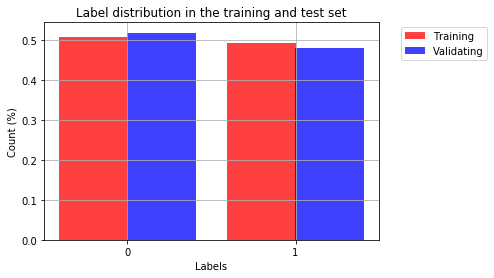

 Build Time: [0.07802870000000439]
lie_cnt_vec_unigram_v1 Naive Bayes with CV Predict Time: [0.0008459000000016204]


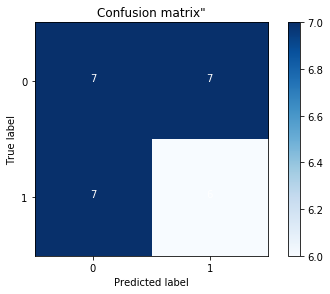

   id                                     word_frequency
0   0  [and:1, at:1, dining:1, dishes:1, good:1, high...
1   1  [and:1, around:1, back:1, be:1, bite:1, but:2,...
2   7  [almost:1, and:2, any:1, at:1, bit:1, but:3, c...
3   8  [amount:1, and:4, as:2, at:2, average:1, bread...
4  14  [all:1, also:1, and:5, at:1, ate:1, bad:1, bef...
   id  True_Label  Predicted_Label  \
0  86           1                0   
1  84           1                1   
2  50           0                1   
3  60           0                1   
4  71           1                1   

                                      word_frequency  
0  [after:1, all:2, american:1, an:1, and:1, any:...  
1  [add:1, always:1, and:2, are:1, as:2, at:1, be...  
2  [ago:1, and:4, best:1, both:1, could:1, days:1...  
3  [and:3, believe:1, best:2, better:1, but:1, ch...  
4  [about:1, always:2, and:5, been:1, best:1, can...  
   id  True_Label  Predicted_Label  \
0  86           1                0   
1  84           1      

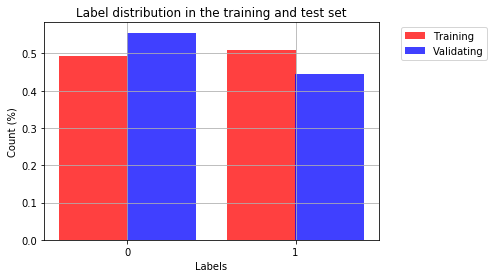

 Build Time: [0.10435739999999782]
lie_cnt_vec_unigram_v2 Naive Bayes with CV Predict Time: [0.001352499999995871]


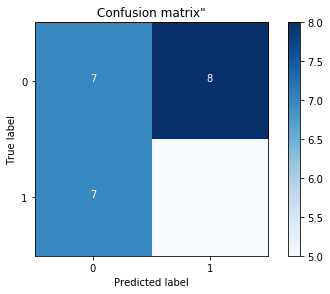

   id                                     word_frequency
0  11  [also:3, american:1, and:2, are:1, area:1, bac...
1  13  [about:1, all:1, an:2, and:3, asked:1, at:2, b...
2  14  [all:1, also:1, and:5, at:1, ate:1, bad:1, bef...
3  15  [and:2, are:1, bar:1, dirty:1, expectations:1,...
4  18  [all:1, and:5, anywhere:1, are:1, at:1, been:1...
   id  True_Label  Predicted_Label  \
0  25           1                1   
1  73           1                1   
2  63           0                0   
3  78           1                0   
4  74           1                1   

                                      word_frequency  
0  [and:2, at:1, been:1, before:1, buffet:1, by:1...  
1  [after:1, and:3, at:1, awesome:2, bar:1, be:1,...  
2  [about:2, always:1, and:3, at:1, away:1, back:...  
3  [after:1, again:1, also:1, and:1, applebee:1, ...  
4  [and:3, are:3, cafe:1, coffee:2, doing:1, ever...  
   id  True_Label  Predicted_Label  \
0  25           1                1   
1  73           1      

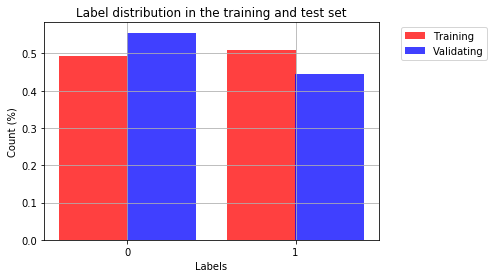

 Build Time: [0.0858923000000118]
lie_cnt_vec_unigram_v3 Naive Bayes with CV Predict Time: [0.0011681999999950676]


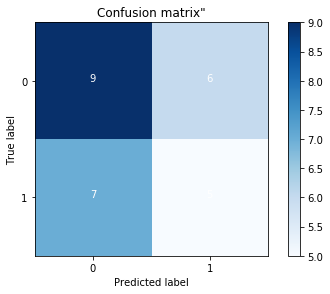

   id                                     word_frequency
0   3  [away:1, began:1, came:1, entered:1, even:2, e...
1   5  [asked:1, average:1, call:2, came:2, come:2, c...
2   6  [bad:1, cooked:1, could:1, diner:1, dish:2, do...
3   8  [amount:1, average:1, bread:2, cold:2, comfort...
4   9  [average:1, beer:1, bread:1, cooked:2, could:1...
   id  True_Label  Predicted_Label  \
0  58           0                0   
1  41           1                0   
2  80           1                1   
3  54           0                0   
4  66           0                0   

                                      word_frequency  
0  [also:1, always:1, clean:1, costed:1, definite...  
1  [always:1, atmosphere:1, back:1, best:1, comin...  
2  [already:1, always:1, ask:1, big:1, cannot:1, ...  
3  [along:2, amazing:3, appetizer:1, attentive:1,...  
4  [ago:1, bland:1, came:1, cold:1, completely:1,...  
   id  True_Label  Predicted_Label  \
0  58           0                0   
1  41           1      

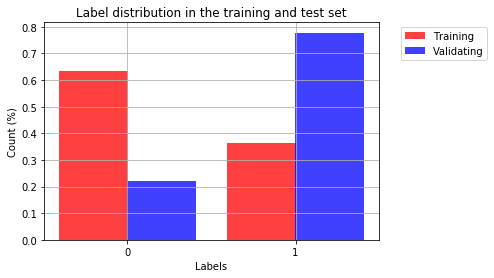

 Build Time: [0.07072610000000168]
lie_cnt_vec_unigram_v4 Naive Bayes with CV Predict Time: [0.0013849999999990814]


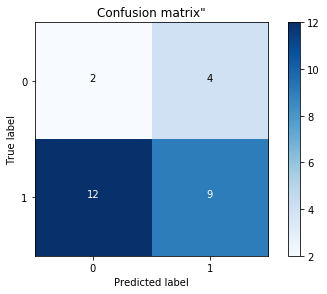

   id                                     word_frequency
0   0  [dine:1, dish:1, good:1, high:1, know:1, least...
1  15  [bar:1, decor:1, dirti:1, expect:1, go:1, low:...
2  20  [actual:1, ask:2, back:2, bad:1, bill:1, came:...
3  22  [dinner:1, dish:1, found:1, friend:1, one:1, r...
4  24  [alreadi:1, bit:1, came:1, chop:1, dine:1, dis...
   id  True_Label  Predicted_Label  \
0  22           0                0   
1  89           1                1   
2  77           1                0   
3  40           1                0   
4  25           1                0   

                                      word_frequency  
0  [dinner:1, dish:1, found:1, friend:1, one:1, r...  
1  [attend:2, busi:1, call:1, clearli:1, drink:2,...  
2  [appet:1, arriv:1, bare:1, beer:1, bring:1, co...  
3  [awesom:1, bar:1, bring:1, cicero:1, dessert:1...  
4  [buffet:1, citi:2, day:1, disappoint:1, favori...  
   id  True_Label  Predicted_Label  \
0  22           0                0   
1  89           1      

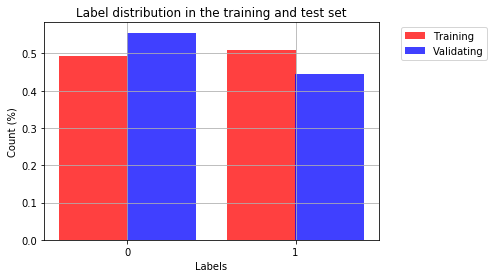

 Build Time: [0.08866609999998332]
lie_tfidf_vec_unigram_v1 Naive Bayes with CV Predict Time: [0.000826700000004621]


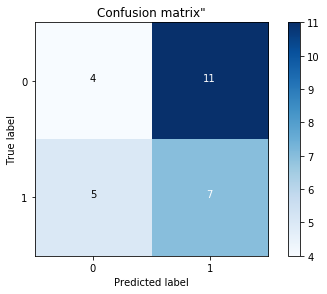

   id                                     word_frequency
0   0  [and:0.05147042779568504, at:0.095620878752801...
1   4  [again:0.06145453285111985, although:0.0896089...
2  11  [also:0.3910774104870967, american:0.153482795...
3  17  [any:0.2043006867388172, did:0.278474758729229...
4  20  [and:0.07827072096125207, asked:0.242799655313...
   id  True_Label  Predicted_Label  \
0  44           1                0   
1  11           0                1   
2  70           1                1   
3  61           0                1   
4  54           0                1   

                                      word_frequency  
0  [after:0.11584906927960573, and:0.039753406165...  
1  [also:0.3910774104870967, american:0.153482795...  
2  [and:0.04944970178983959, as:0.237610465453058...  
3  [again:0.0756549457086832, all:0.0736537160167...  
4  [all:0.15859897151487376, along:0.158361442454...  
   id  True_Label  Predicted_Label  \
0  44           1                0   
1  11           0      

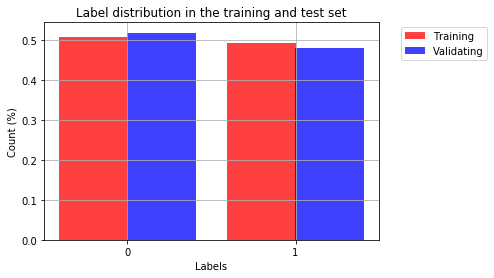

 Build Time: [0.08964379999997618]
lie_tfidf_vec_unigram_v2 Naive Bayes with CV Predict Time: [0.0011403000000029806]


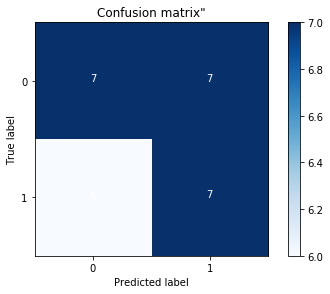

   id                                     word_frequency
0   7  [almost:0.16340118885289598, and:0.07911909255...
1  10  [about:0.05359119529150222, after:0.1102644238...
2  11  [also:0.3910774104870967, american:0.153482795...
3  15  [and:0.11300952352698568, are:0.13046125462631...
4  17  [any:0.2043006867388172, did:0.278474758729229...
   id  True_Label  Predicted_Label  \
0  56           0                0   
1  11           0                1   
2  64           0                1   
3  15           0                0   
4  40           1                0   

                                      word_frequency  
0  [all:0.12338463107457902, and:0.13422046923183...  
1  [also:0.3910774104870967, american:0.153482795...  
2  [amazing:0.1351755156883392, ambiance:0.166139...  
3  [and:0.11300952352698568, are:0.13046125462631...  
4  [and:0.1826363991799784, are:0.140560270402126...  
   id  True_Label  Predicted_Label  \
0  56           0                0   
1  11           0      

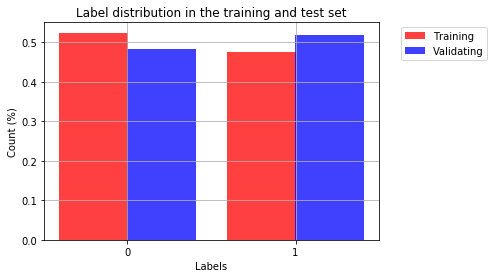

 Build Time: [0.08932370000002265]
lie_tfidf_vec_unigram_v3 Naive Bayes with CV Predict Time: [0.0012228000000220618]


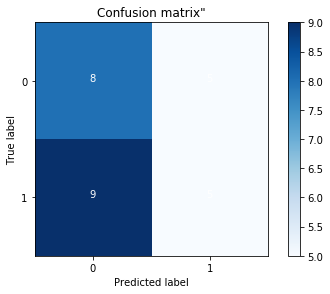

   id                                     word_frequency
0   6  [bad:0.16225604639068558, cooked:0.16758457460...
1  11  [also:0.4335722475605553, american:0.170160379...
2  12  [asked:0.1524902707508294, best:0.103669970393...
3  15  [bar:0.20963835289294638, dirty:0.251985346099...
4  16  [come:0.2790257052342813, extremely:0.34534302...
   id  True_Label  Predicted_Label  \
0  60           0                0   
1  74           1                1   
2  20           0                0   
3  16           0                0   
4  52           0                0   

                                      word_frequency  
0  [believe:0.15727480858983667, best:0.181627571...  
1  [cafe:0.2820999157832463, coffee:0.60355190168...  
2  [asked:0.340714870173327, back:0.2815547260648...  
3  [come:0.2790257052342813, extremely:0.34534302...  
4  [also:0.2193146572914012, applebee:0.292026885...  
   id  True_Label  Predicted_Label  \
0  60           0                0   
1  74           1      

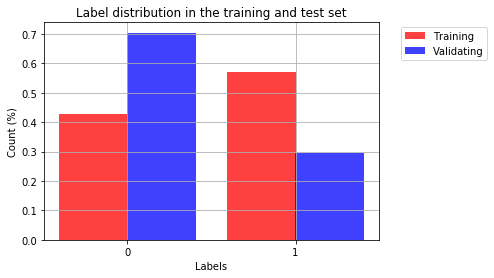

 Build Time: [0.08444780000002083]
lie_tfidf_vec_unigram_v4 Naive Bayes with CV Predict Time: [0.000894300000027215]


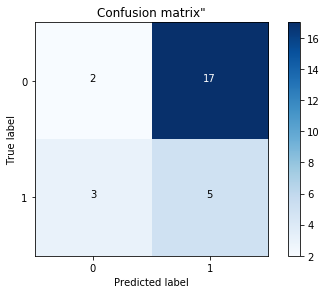

   id                                     word_frequency
0   2  [began:0.17915280194177283, believ:0.169460436...
1   3  [away:0.16741136729180467, began:0.17698653524...
2   4  [although:0.10732964937113897, bland:0.0904685...
3   8  [amount:0.18369208814678706, averag:0.17171521...
4  10  [ambianc:0.10334100824405067, back:0.076087134...
   id  True_Label  Predicted_Label  \
0  12           0                1   
1   8           0                1   
2  53           0                1   
3  17           0                1   
4  50           0                1   

                                      word_frequency  
0  [ask:0.1167553347504558, best:0.09158781778760...  
1  [amount:0.18369208814678706, averag:0.17171521...  
2  [ask:0.18005776405396198, comfort:0.2151448492...  
3  [dish:0.23389784760127408, ever:0.273959119864...  
4  [ago:0.20125814723570992, best:0.1027564591953...  
   id  True_Label  Predicted_Label  \
0  12           0                1   
1   8           0      

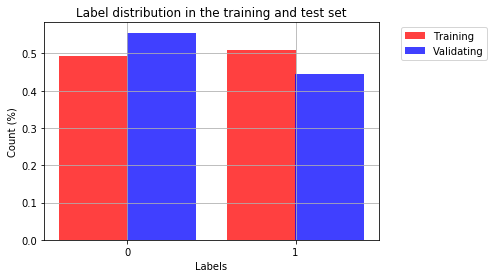

 Build Time: [0.09778069999998706]
lie_cnt_vec_bigram_v1 Naive Bayes with CV Predict Time: [0.0015549999999961983]


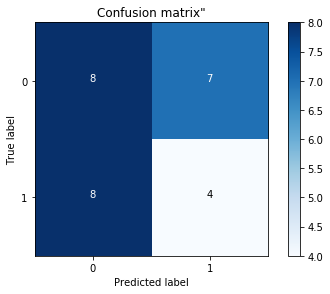

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   2  [and:2, any:2, any_more:1, at:2, began:1, bega...
2   4  [again:1, although:1, and:5, and_my:1, and_the...
3   6  [again:1, an:1, an_hour:1, and:1, and_when:1, ...
4   9  [and:3, and_the:2, and_we:1, at:1, average:1, ...
   id  True_Label  Predicted_Label  \
0  16           0                0   
1  39           1                0   
2  41           1                0   
3  26           1                0   
4   2           0                0   

                                      word_frequency  
0  [and:1, and_the:1, at:1, at_this:1, come:1, ex...  
1  [add:1, also:2, also_the:1, and:4, and_had:1, ...  
2  [always:1, and:1, and_the:1, as:1, as_well:1, ...  
3  [and:1, back:1, bar:1, bar_the:1, be:1, believ...  
4  [and:2, any:2, any_more:1, at:2, began:1, bega...  
   id  True_Label  Predicted_Label  \
0  16           0                0   
1  39           1      

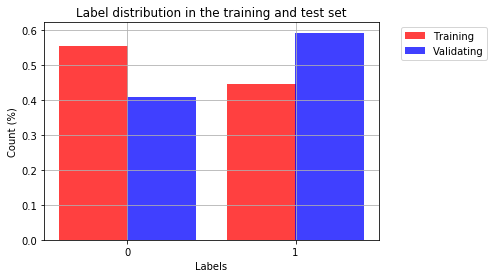

 Build Time: [0.1034349999999904]
lie_cnt_vec_bigram_v2 Naive Bayes with CV Predict Time: [0.000940300000024763]


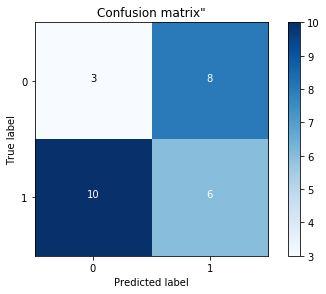

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   1  [and:1, around:1, back:1, back_for:1, be:1, bi...
2   2  [and:2, any:2, any_more:1, at:2, began:1, bega...
3   5  [about:1, again:1, and:7, and_my:1, and_servic...
4  12  [and:3, and_it:1, and_then:2, any:1, asked:1, ...
   id  True_Label  Predicted_Label  \
0  46           0                0   
1   0           0                1   
2  40           1                0   
3   2           0                1   
4  87           1                0   

                                      word_frequency  
0  [along:1, along_with:1, and:3, by:1, champagne...  
1  [and:1, and_the:1, at:1, at_least:1, dining:1,...  
2  [and:3, and_high:1, are:1, awesome:1, bar:1, b...  
3  [and:2, any:2, any_more:1, at:2, began:1, bega...  
4  [amazing:1, amazing_experience:1, ambiance:1, ...  
   id  True_Label  Predicted_Label  \
0  46           0                0   
1   0           0      

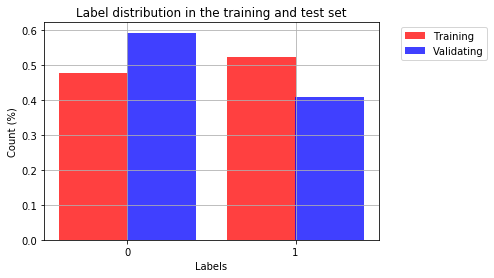

 Build Time: [0.09548889999999233]
lie_cnt_vec_bigram_v3 Naive Bayes with CV Predict Time: [0.0008798000000069806]


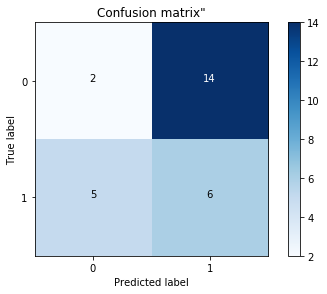

   id                                     word_frequency
0   0  [dining:1, dishes:1, good:1, high:1, know:1, l...
1   1  [around:1, back:1, bite:1, called:1, come:1, d...
2   7  [almost:1, bit:1, bit_salty:1, chop:1, costed:...
3   9  [average:1, beer:1, bread:1, cooked:2, could:1...
4  12  [asked:1, best:1, city:1, different:1, find:2,...
   id  True_Label  Predicted_Label  \
0  12           0                1   
1   1           0                1   
2   0           0                1   
3  33           1                0   
4  68           0                1   

                                      word_frequency  
0  [asked:1, best:1, city:1, different:1, find:2,...  
1  [around:1, back:1, bite:1, called:1, come:1, d...  
2  [dining:1, dishes:1, good:1, high:1, know:1, l...  
3  [cold:1, eat:1, expect:1, food:1, food_good:1,...  
4  [awesome:1, favorite:1, like:1, much:1, pork:1...  
   id  True_Label  Predicted_Label  \
0  12           0                1   
1   1           0      

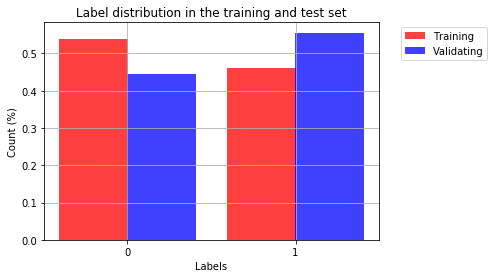

 Build Time: [0.09481149999999161]
lie_cnt_vec_bigram_v4 Naive Bayes with CV Predict Time: [0.0008318000000144821]


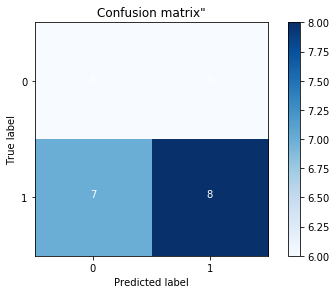

   id                                     word_frequency
0   2  [began:1, believ:1, chicken:2, dinner:1, exper...
1   3  [away:1, began:1, came:1, enter:1, enter_resta...
2   4  [although:1, bland:1, brew:1, brought:1, buffa...
3   8  [amount:1, averag:1, bread:2, cold:2, comfort:...
4  10  [ambianc:1, back:1, back_price:1, bread:1, cal...
   id  True_Label  Predicted_Label  \
0  42           1                0   
1  63           0                1   
2  32           1                0   
3  10           0                1   
4  33           1                1   

                                      word_frequency  
0  [area:1, best:1, favorit:1, favorit_restaur:1,...  
1  [alway:1, away:1, back:1, best:1, call:1, cons...  
2  [almost:1, back:1, clearli:1, easi:1, food:1, ...  
3  [ambianc:1, back:1, back_price:1, bread:1, cal...  
4  [cold:1, disappoint:1, eat:1, expect:1, food:1...  
   id  True_Label  Predicted_Label  \
0  42           1                0   
1  63           0      

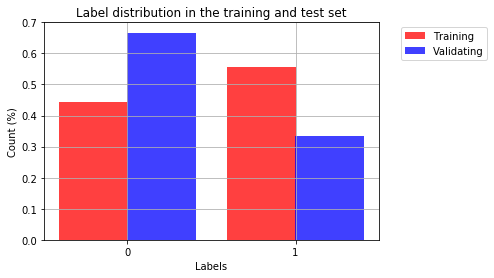

 Build Time: [0.09824860000000513]
lie_tfidf_vec_bigram_v1 Naive Bayes with CV Predict Time: [0.0011824000000046908]


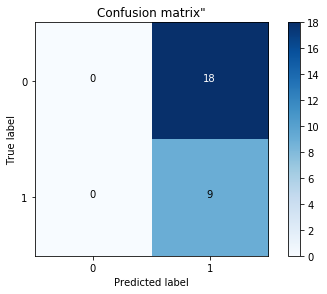

   id                                     word_frequency
0   0  [and:0.044965519521846894, and_the:0.084792812...
1   1  [and:0.043023510142936885, around:0.1292175254...
2   5  [about:0.05205486639839098, again:0.0520548663...
3   8  [amount:0.11093316456387481, amount_of:0.11093...
4   9  [and:0.09152340934543361, and_the:0.1150589363...
   id  True_Label  Predicted_Label  \
0  35           1                1   
1  48           0                1   
2  14           0                1   
3  52           0                1   
4  74           1                1   

                                      word_frequency  
0  [about:0.06638034840314586, after:0.0682891175...  
1  [an:0.12650625575134616, and:0.141167480643829...  
2  [all:0.05447462886459094, also:0.0612744529963...  
3  [again:0.10481606636313122, also:0.11478109378...  
4  [and:0.11964354680237299, and_good:0.164729710...  
   id  True_Label  Predicted_Label  \
0  35           1                1   
1  48           0      

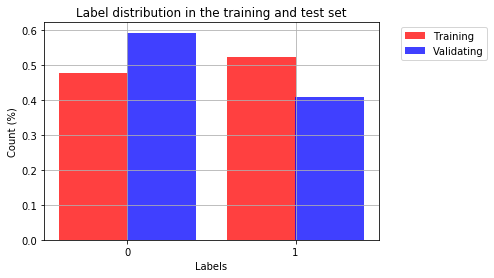

 Build Time: [0.10168559999999616]
lie_tfidf_vec_bigram_v2 Naive Bayes with CV Predict Time: [0.001378200000004881]


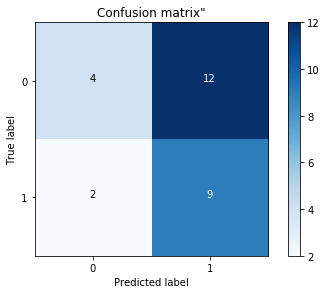

   id                                     word_frequency
0   1  [and:0.043023510142936885, around:0.1292175254...
1   4  [again:0.050284938648994824, although:0.073322...
2   7  [almost:0.13778140413659556, and:0.06671395564...
3   8  [amount:0.11093316456387481, amount_of:0.11093...
4  14  [all:0.05447462886459094, also:0.0612744529963...
   id  True_Label  Predicted_Label  \
0  79           1                1   
1  55           0                0   
2  84           1                1   
3   8           0                1   
4  48           0                1   

                                      word_frequency  
0  [all:0.12993900020636878, and:0.14135045367743...  
1  [about:0.1377088239003206, about_it:0.10039901...  
2  [add:0.09024425920436963, always:0.07250134715...  
3  [amount:0.11093316456387481, amount_of:0.11093...  
4  [an:0.12650625575134616, and:0.141167480643829...  
   id  True_Label  Predicted_Label  \
0  79           1                1   
1  55           0      

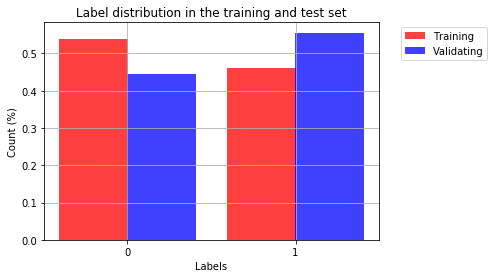

 Build Time: [0.07853880000001823]
lie_tfidf_vec_bigram_v3 Naive Bayes with CV Predict Time: [0.0010505999999850246]


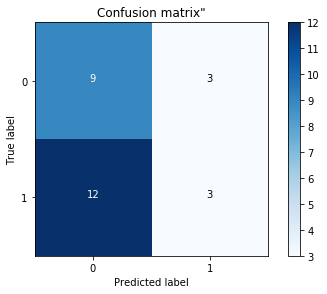

   id                                     word_frequency
0   2  [began:0.16328862597772126, believe:0.15445453...
1   5  [asked:0.10826302264173758, average:0.13475772...
2   6  [bad:0.15836121043394027, cooked:0.16356183127...
3   7  [almost:0.18722576756593426, bit:0.17501849671...
4  11  [also:0.39501006895676777, american:0.15502621...
   id  True_Label  Predicted_Label  \
0  36           1                0   
1  46           0                0   
2  71           1                0   
3  69           1                1   
4   6           0                0   

                                      word_frequency  
0  [around:0.1090920689305477, around_pm:0.150031...  
1  [along:0.20992177707218737, champagne:0.209921...  
2  [always:0.2777358038294171, best:0.09440885119...  
3  [amazing:0.17646218825718576, best:0.131372662...  
4  [bad:0.15836121043394027, cooked:0.16356183127...  
   id  True_Label  Predicted_Label  \
0  36           1                0   
1  46           0      

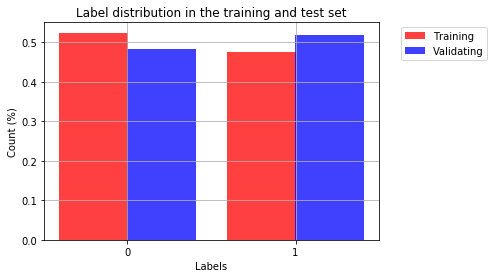

 Build Time: [0.08369770000001608]
lie_tfidf_vec_bigram_v4 Naive Bayes with CV Predict Time: [0.0009304999999812935]


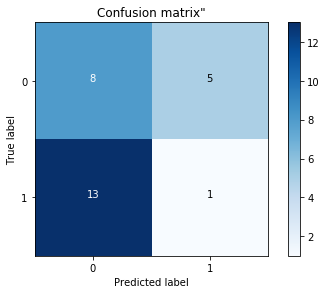

   id                                     word_frequency
0   0  [dine:0.14729467904239663, dish:0.141372482555...
1   4  [although:0.09238122376615351, bland:0.0778684...
2   6  [bad:0.1622456883034083, cook:0.16224568830340...
3  13  [arriv:0.1771269808447157, ask:0.1233278251758...
4  15  [bar:0.2068136124458599, decor:0.2659287779799...
   id  True_Label  Predicted_Label  \
0  64           0                1   
1  55           0                0   
2  83           1                0   
3  41           1                0   
4  67           0                0   

                                      word_frequency  
0  [amaz:0.13253040729006296, ambianc:0.162888804...  
1  [alreadi:0.1276160246813127, appet:0.133872149...  
2  [amaz:0.17704547867826598, bake:0.241324186159...  
3  [alway:0.23206002669854922, atmospher:0.273223...  
4  [chicken:0.19816317605159142, friend:0.1585182...  
   id  True_Label  Predicted_Label  \
0  64           0                1   
1  55           0      

In [62]:
# MultinomialNB
# loop over each of the Vecotirization models and run MNB on each
#-----------------LIE--------------------------------#
reportPath_lie_mnb = f'{outputDir}/lie_mnb_models_report.txt'
#lie_mnb_feature_vec_files
i=0
for m,v in X_train_lie_dfs_mnb.items():
    # instantiate niave bayes models
    mnb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    #logger.info(f'{m}')
    #logger.info(f'{v}')
    #break
    build_test_validate_models(logger,'mnb',mnb,m,v,y_lie,reportPath_lie_mnb,f'{outputDir}',f'{m}.txt')
    i+=1
    #break   

Model Name:             lie_cnt_vec_unigram_bool_v1


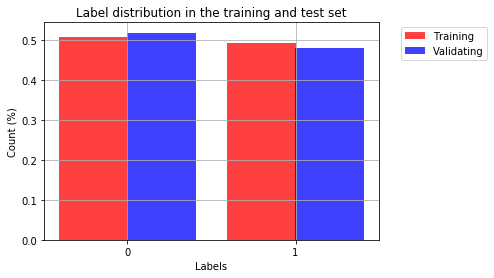

 Build Time: [0.12938610000000494]
lie_cnt_vec_unigram_bool_v1 Naive Bayes with CV Predict Time: [0.001484200000021474]


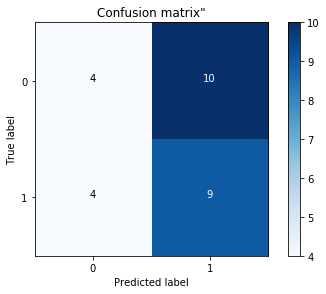

   id                                     word_frequency
0   6  [again:1, an:1, and:1, any:1, are:1, at:1, bad...
1   8  [amount:1, and:1, as:1, at:1, average:1, bread...
2  10  [about:1, after:1, again:1, all:1, am:1, ambia...
3  12  [and:1, any:1, asked:1, best:1, by:1, can:1, c...
4  13  [about:1, all:1, an:1, and:1, asked:1, at:1, b...
   id  True_Label  Predicted_Label  \
0  67           0                0   
1   6           0                0   
2   8           0                1   
3  45           1                1   
4  31           1                1   

                                      word_frequency  
0  [and:1, as:1, chicken:1, friendly:1, friends:1...  
1  [again:1, an:1, and:1, any:1, are:1, at:1, bad...  
2  [amount:1, and:1, as:1, at:1, average:1, bread...  
3  [and:1, best:1, ever:1, every:1, excellent:1, ...  
4  [and:1, are:1, bad:1, can:1, cannot:1, dishes:...  
   id  True_Label  Predicted_Label  \
0  67           0                0   
1   6           0      

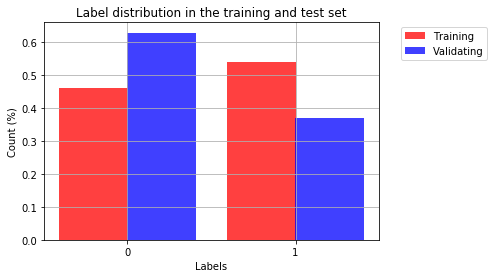

 Build Time: [0.12034420000000523]
lie_cnt_vec_unigram_bool_v2 Naive Bayes with CV Predict Time: [0.001315599999998085]


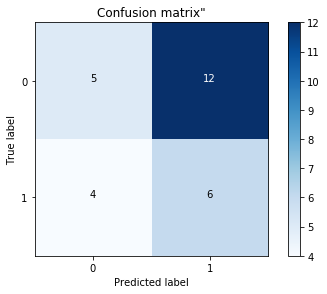

   id                                     word_frequency
0   0  [and:1, at:1, dining:1, dishes:1, good:1, high...
1   4  [again:1, although:1, and:1, at:1, before:1, b...
2   6  [again:1, an:1, and:1, any:1, are:1, at:1, bad...
3   8  [amount:1, and:1, as:1, at:1, average:1, bread...
4  12  [and:1, any:1, asked:1, best:1, by:1, can:1, c...
   id  True_Label  Predicted_Label  \
0  39           1                0   
1  33           1                0   
2  68           0                1   
3  26           1                0   
4  63           0                1   

                                      word_frequency  
0  [add:1, also:1, and:1, as:1, bite:1, bland:1, ...  
1  [and:1, at:1, cold:1, don:1, eat:1, expect:1, ...  
2  [and:1, awesome:1, does:1, favorite:1, is:1, l...  
3  [and:1, back:1, bar:1, be:1, believe:1, can:1,...  
4  [about:1, always:1, and:1, at:1, away:1, back:...  
   id  True_Label  Predicted_Label  \
0  39           1                0   
1  33           1      

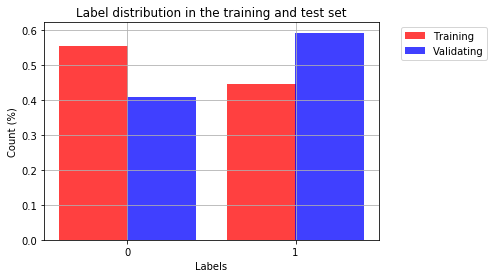

 Build Time: [0.09385370000001103]
lie_cnt_vec_unigram_bool_v3 Naive Bayes with CV Predict Time: [0.0011417000000051303]


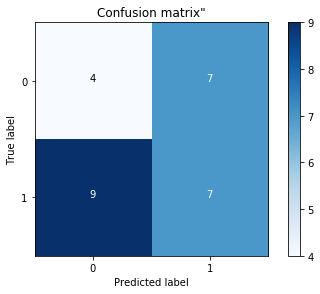

   id                                     word_frequency
0   3  [away:1, began:1, came:1, entered:1, even:1, e...
1   5  [asked:1, average:1, call:1, came:1, come:1, c...
2   8  [amount:1, average:1, bread:1, cold:1, comfort...
3   9  [average:1, beer:1, bread:1, cooked:1, could:1...
4  11  [also:1, american:1, area:1, back:1, buffet:1,...
   id  True_Label  Predicted_Label  \
0  16           0                0   
1  55           0                1   
2  73           1                0   
3   8           0                1   
4  11           0                1   

                                      word_frequency  
0  [come:1, extremely:1, food:1, good:1, hour:1, ...  
1  [already:1, appetizer:1, asked:1, back:1, bad:...  
2  [awesome:1, bar:1, beer:1, best:1, day:1, deli...  
3  [amount:1, average:1, bread:1, cold:1, comfort...  
4  [also:1, american:1, area:1, back:1, buffet:1,...  
   id  True_Label  Predicted_Label  \
0  16           0                0   
1  55           0      

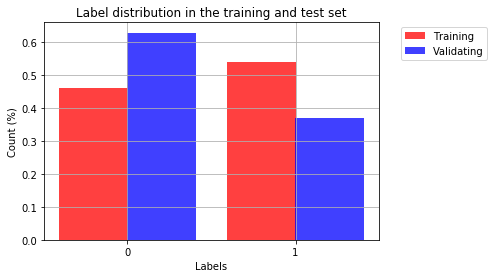

 Build Time: [0.11053190000001223]
lie_cnt_vec_unigram_bool_v4 Naive Bayes with CV Predict Time: [0.001820199999997385]


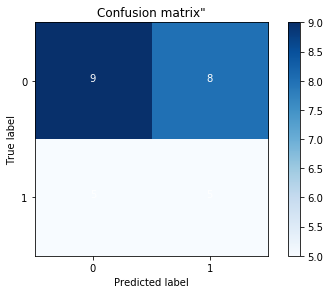

   id                                     word_frequency
0   1  [around:1, back:1, bite:1, call:1, come:1, del...
1   2  [began:1, believ:1, chicken:1, dinner:1, exper...
2   5  [ask:1, averag:1, call:1, came:1, come:1, cook...
3   6  [bad:1, cook:1, could:1, diner:1, dish:1, done...
4   9  [averag:1, beer:1, bread:1, cook:1, could:1, d...
   id  True_Label  Predicted_Label  \
0   1           0                1   
1   5           0                0   
2  54           0                0   
3  25           1                0   
4   6           0                0   

                                      word_frequency  
0  [around:1, back:1, bite:1, call:1, come:1, del...  
1  [ask:1, averag:1, call:1, came:1, come:1, cook...  
2  [along:1, amaz:1, appet:1, attent:1, back:1, b...  
3  [buffet:1, citi:1, day:1, disappoint:1, favori...  
4  [bad:1, cook:1, could:1, diner:1, dish:1, done...  
   id  True_Label  Predicted_Label  \
0   1           0                1   
1   5           0      

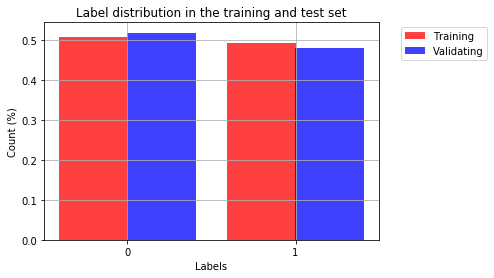

 Build Time: [0.22624700000000075]
lie_tfidf_vec_unigram_bool_v1 Naive Bayes with CV Predict Time: [0.002766000000008262]


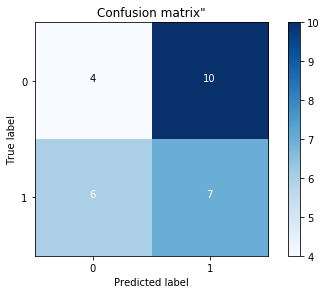

   id                                     word_frequency
0   1  [and:0.057284278433967425, around:0.1720485540...
1   3  [an:0.11703229544856113, and:0.043531850669663...
2  10  [about:0.08712736704214416, after:0.0896327174...
3  12  [and:0.051073174978692605, any:0.1446768640151...
4  16  [and:0.07188972532640854, at:0.133555499796817...
   id  True_Label  Predicted_Label  \
0  20           0                0   
1  32           1                0   
2  84           1                1   
3  21           0                1   
4   1           0                1   

                                      word_frequency  
0  [and:0.05724111249757581, asked:0.177564767686...  
1  [about:0.13516022903265154, again:0.1351602290...  
2  [add:0.16606483070618863, always:0.13341484596...  
3  [and:0.059440929569172504, big:0.2295132866694...  
4  [and:0.057284278433967425, around:0.1720485540...  
   id  True_Label  Predicted_Label  \
0  20           0                0   
1  32           1      

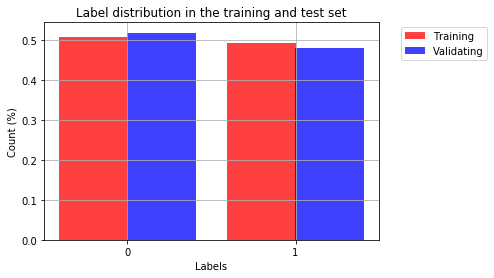

 Build Time: [0.12463329999999928]
lie_tfidf_vec_unigram_bool_v2 Naive Bayes with CV Predict Time: [0.0022098999999968783]


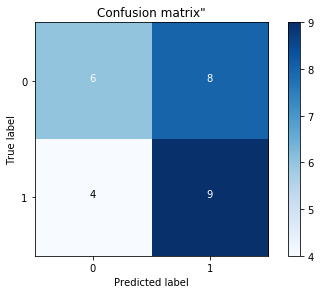

   id                                     word_frequency
0   7  [almost:0.20540290812857484, and:0.04972819296...
1   8  [amount:0.21127808307849238, and:0.05115057707...
2  12  [and:0.051073174978692605, any:0.1446768640151...
3  14  [all:0.12034908270483499, also:0.1353717201026...
4  16  [and:0.07188972532640854, at:0.133555499796817...
   id  True_Label  Predicted_Label  \
0   7           0                1   
1  24           1                0   
2  47           0                0   
3  69           1                1   
4  73           1                1   

                                      word_frequency  
0  [almost:0.20540290812857484, and:0.04972819296...  
1  [about:0.1154341981233774, already:0.141876410...  
2  [amazing:0.1656320583368487, ambiance:0.203572...  
3  [after:0.15931469537653412, amazing:0.15486164...  
4  [after:0.13893350522469325, and:0.047674790117...  
   id  True_Label  Predicted_Label  \
0   7           0                1   
1  24           1      

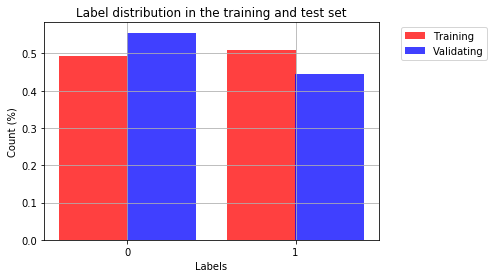

 Build Time: [0.12840249999999287]
lie_tfidf_vec_unigram_bool_v3 Naive Bayes with CV Predict Time: [0.001904100000018616]


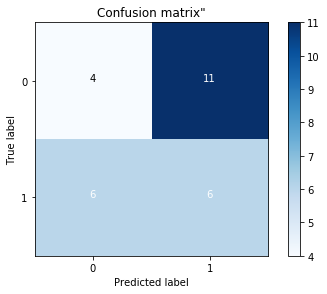

   id                                     word_frequency
0   0  [dining:0.19738913597595872, dishes:0.18679644...
1   1  [around:0.19879196661905826, back:0.1696694746...
2   6  [bad:0.19708272385768064, cooked:0.20355496866...
3   8  [amount:0.23671585901345818, average:0.2212817...
4  11  [also:0.17168966560807686, american:0.20214470...
   id  True_Label  Predicted_Label  \
0  66           0                0   
1  34           1                1   
2  11           0                1   
3  84           1                0   
4  80           1                0   

                                      word_frequency  
0  [ago:0.2531415006830533, bland:0.2133739380742...  
1  [add:0.23245316634197846, around:0.18081264803...  
2  [also:0.17168966560807686, american:0.20214470...  
3  [add:0.19905234295548582, always:0.15991668772...  
4  [already:0.21426116347767832, always:0.1909019...  
   id  True_Label  Predicted_Label  \
0  66           0                0   
1  34           1      

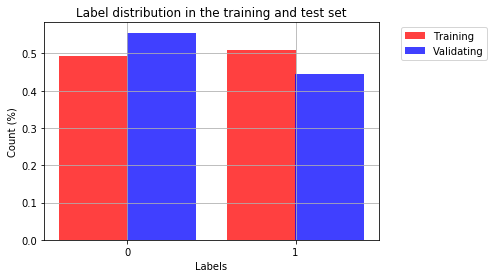

 Build Time: [0.11186270000001741]
lie_tfidf_vec_unigram_bool_v4 Naive Bayes with CV Predict Time: [0.0016219999999975698]


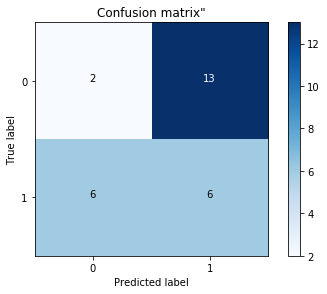

   id                                     word_frequency
0   5  [ask:0.13195209023656107, averag:0.18951339915...
1   8  [amount:0.24743209400798402, averag:0.23129932...
2   9  [averag:0.27435368691853784, beer:0.2371297252...
3  15  [bar:0.23305695844938906, decor:0.299673466495...
4  21  [big:0.2427930826751118, bland:0.2189253244886...
   id  True_Label  Predicted_Label  \
0  38           1                0   
1  67           0                1   
2  75           1                1   
3   5           0                0   
4  21           0                0   

                                      word_frequency  
0  [actual:0.12080760836419226, alreadi:0.1018291...  
1  [chicken:0.24229680838189874, friend:0.1938224...  
2  [atmospher:0.22275383693210332, bar:0.19591871...  
3  [ask:0.13195209023656107, averag:0.18951339915...  
4  [big:0.2427930826751118, bland:0.2189253244886...  
   id  True_Label  Predicted_Label  \
0  38           1                0   
1  67           0      

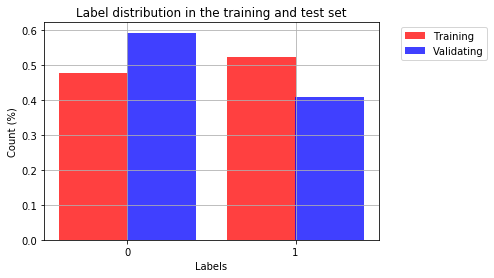

 Build Time: [0.11853320000000167]
lie_cnt_vec_bigram_bool_v1 Naive Bayes with CV Predict Time: [0.0016602999999975054]


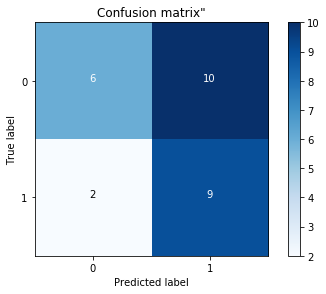

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   1  [and:1, around:1, back:1, back_for:1, be:1, bi...
2   4  [again:1, although:1, and:1, and_my:1, and_the...
3   7  [almost:1, and:1, any:1, any_more:1, at:1, bit...
4   9  [and:1, and_the:1, and_we:1, at:1, average:1, ...
   id  True_Label  Predicted_Label  \
0  44           1                1   
1  23           1                1   
2  69           1                1   
3  64           0                0   
4  10           0                0   

                                      word_frequency  
0  [after:1, and:1, are:1, are_not:1, asked:1, as...  
1  [after:1, and:1, and_it:1, and_there:1, any:1,...  
2  [after:1, amazing:1, and:1, and_it:1, and_the:...  
3  [amazing:1, ambiance:1, and:1, and_the:1, and_...  
4  [about:1, about_the:1, after:1, again:1, again...  
   id  True_Label  Predicted_Label  \
0  44           1                1   
1  23           1      

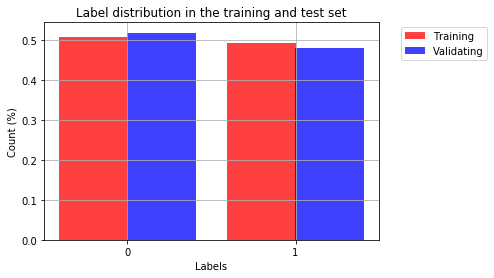

 Build Time: [0.11811560000001009]
lie_cnt_vec_bigram_bool_v2 Naive Bayes with CV Predict Time: [0.0018445999999983087]


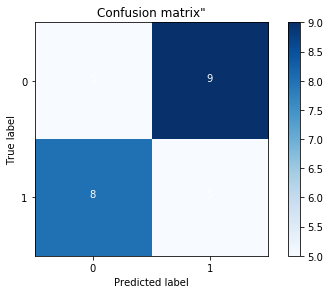

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   4  [again:1, although:1, and:1, and_my:1, and_the...
2   6  [again:1, an:1, an_hour:1, and:1, and_when:1, ...
3  12  [and:1, and_it:1, and_then:1, any:1, asked:1, ...
4  21  [and:1, and_the:1, and_was:1, big:1, bland:1, ...
   id  True_Label  Predicted_Label  \
0  32           1                0   
1  34           1                0   
2   6           0                0   
3  12           0                1   
4   4           0                0   

                                      word_frequency  
0  [about:1, about_the:1, again:1, almost:1, at:1...  
1  [add:1, all:1, all_the:1, and:1, are:1, around...  
2  [again:1, an:1, an_hour:1, and:1, and_when:1, ...  
3  [and:1, and_it:1, and_then:1, any:1, asked:1, ...  
4  [again:1, although:1, and:1, and_my:1, and_the...  
   id  True_Label  Predicted_Label  \
0  32           1                0   
1  34           1      

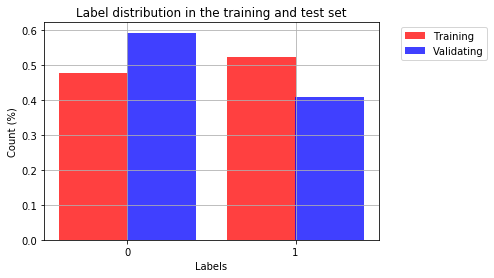

 Build Time: [0.10911130000002345]
lie_cnt_vec_bigram_bool_v3 Naive Bayes with CV Predict Time: [0.0017243000000064512]


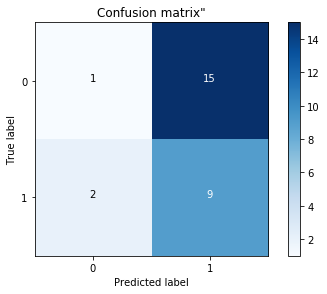

   id                                     word_frequency
0   0  [dining:1, dishes:1, good:1, high:1, know:1, l...
1   1  [around:1, back:1, bite:1, called:1, come:1, d...
2   6  [bad:1, cooked:1, could:1, diner:1, dish:1, do...
3   7  [almost:1, bit:1, bit_salty:1, chop:1, costed:...
4   8  [amount:1, average:1, bread:1, cold:1, comfort...
   id  True_Label  Predicted_Label  \
0   8           0                1   
1  22           0                1   
2  42           1                1   
3  48           0                1   
4  18           0                1   

                                      word_frequency  
0  [amount:1, average:1, bread:1, cold:1, comfort...  
1  [dinner:1, dishes:1, found:1, friend:1, one:1,...  
2  [area:1, best:1, favorite:1, friends:1, love:1...  
3  [beer:1, beer_list:1, best:1, cold:1, deliciou...  
4  [anywhere:1, cheese:1, cool:1, dead:1, diner:1...  
   id  True_Label  Predicted_Label  \
0   8           0                1   
1  22           0      

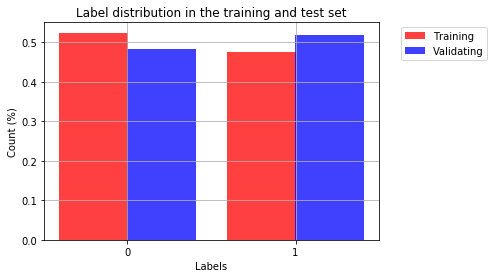

 Build Time: [0.09977980000002162]
lie_cnt_vec_bigram_bool_v4 Naive Bayes with CV Predict Time: [0.0017159000000219748]


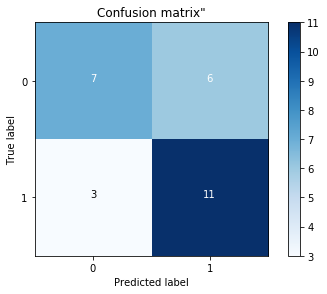

   id                                     word_frequency
0   3  [away:1, began:1, came:1, enter:1, enter_resta...
1   4  [although:1, bland:1, brew:1, brought:1, buffa...
2   6  [bad:1, cook:1, could:1, diner:1, dish:1, done...
3  11  [also:1, american:1, area:1, back:1, buffet:1,...
4  15  [bar:1, decor:1, dirti:1, expect:1, go:1, low:...
   id  True_Label  Predicted_Label  \
0  44           1                1   
1   4           0                0   
2  68           0                1   
3   3           0                1   
4  46           0                0   

                                      word_frequency  
0  [ask:1, bring:1, bring_us:1, check:1, disast:1...  
1  [although:1, bland:1, brew:1, brought:1, buffa...  
2  [awesom:1, favorit:1, like:1, much:1, pork:1, ...  
3  [away:1, began:1, came:1, enter:1, enter_resta...  
4  [along:1, champagn:1, chicken:1, chocol:1, coo...  
   id  True_Label  Predicted_Label  \
0  44           1                1   
1   4           0      

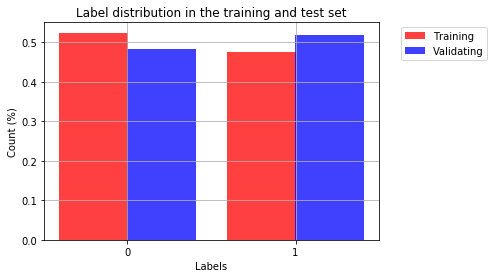

 Build Time: [0.12142140000000268]
lie_tfidf_vec_bigram_bool_v1 Naive Bayes with CV Predict Time: [0.0019405000000176642]


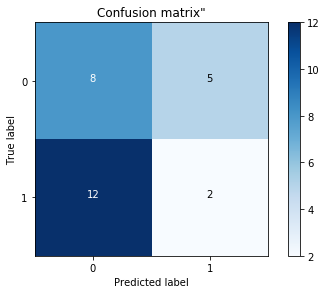

   id                                     word_frequency
0   0  [and:0.04913793900418312, and_the:0.0926608673...
1   1  [and:0.0469885324727854, around:0.141126139456...
2   2  [and:0.03987769362964518, any:0.11296301161817...
3   6  [again:0.10354763051521819, an:0.0982726185126...
4  10  [about:0.059713902723623064, about_the:0.07035...
   id  True_Label  Predicted_Label  \
0   2           0                0   
1  71           1                1   
2  80           1                0   
3  82           1                1   
4   0           0                0   

                                      word_frequency  
0  [and:0.03987769362964518, any:0.11296301161817...  
1  [about:0.11231937786594187, about_the:0.132326...  
2  [already:0.14638117953280658, always:0.1304223...  
3  [and:0.041302655082879454, and_there:0.1438003...  
4  [and:0.04913793900418312, and_the:0.0926608673...  
   id  True_Label  Predicted_Label  \
0   2           0                0   
1  71           1      

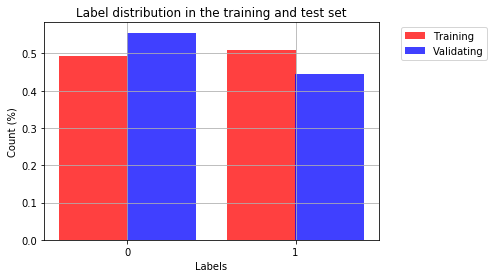

 Build Time: [0.13443479999997976]
lie_tfidf_vec_bigram_bool_v2 Naive Bayes with CV Predict Time: [0.0016045000000133314]


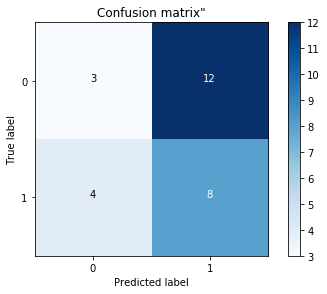

   id                                     word_frequency
0   1  [and:0.0469885324727854, around:0.141126139456...
1   2  [and:0.03987769362964518, any:0.11296301161817...
2   8  [amount:0.14919804537546338, amount_of:0.14919...
3   9  [and:0.03860290223329426, and_the:0.0727946364...
4  12  [and:0.036411689727841326, and_it:0.1061106650...
   id  True_Label  Predicted_Label  \
0   9           0                1   
1  58           0                1   
2  68           0                1   
3  40           1                0   
4  51           0                1   

                                      word_frequency  
0  [and:0.03860290223329426, and_the:0.0727946364...  
1  [again:0.09739306991004269, also:0.10665238144...  
2  [and:0.0718900288744469, awesome:0.27758174250...  
3  [and:0.048061377097645915, and_high:0.19851810...  
4  [and:0.05554323993447069, and_the:0.1047395331...  
   id  True_Label  Predicted_Label  \
0   9           0                1   
1  58           0      

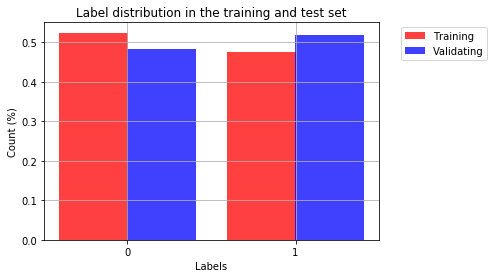

 Build Time: [0.10953960000000507]
lie_tfidf_vec_bigram_bool_v3 Naive Bayes with CV Predict Time: [0.0018371999999828859]


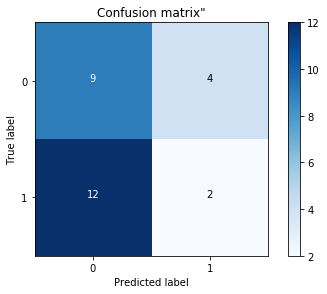

   id                                     word_frequency
0   2  [began:0.24551870589626643, believe:0.23223587...
1   5  [asked:0.13362669483208334, average:0.16632852...
2   7  [almost:0.20995598346411012, bit:0.19626668423...
3   9  [average:0.24797921945893078, beer:0.234563268...
4  10  [ambiance:0.10670563210527509, back:0.07856441...
   id  True_Label  Predicted_Label  \
0  81           1                0   
1  51           0                0   
2  80           1                0   
3  21           0                1   
4  54           0                0   

                                      word_frequency  
0  [much:0.5237158805792229, say:0.61661483214781...  
1  [best:0.1777211793104714, birthday:0.348083571...  
2  [already:0.21426116347767832, always:0.1909019...  
3  [big:0.2215329480403693, bland:0.1997551660051...  
4  [along:0.14596852866827423, amazing:0.10010633...  
   id  True_Label  Predicted_Label  \
0  81           1                0   
1  51           0      

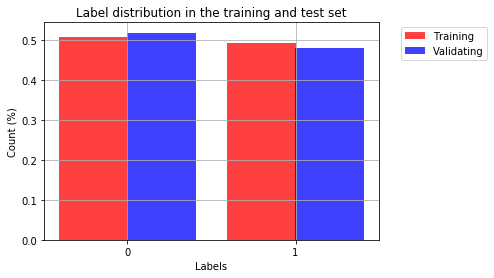

 Build Time: [0.10514820000000213]
lie_tfidf_vec_bigram_bool_v4 Naive Bayes with CV Predict Time: [0.0017432999999869025]


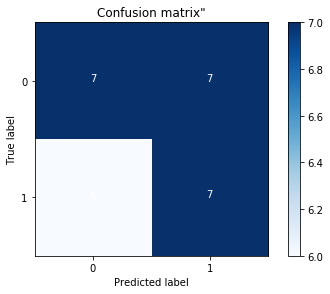

   id                                     word_frequency
0   0  [dine:0.1645836656195367, dish:0.1579663403190...
1   2  [began:0.25028877919002407, believ:0.236747878...
2   4  [although:0.14028875154615075, bland:0.1182499...
3   5  [ask:0.11570739691523019, averag:0.16618230190...
4   7  [almost:0.21009841669885737, bit:0.19639983070...
   id  True_Label  Predicted_Label  \
0  42           1                0   
1   2           0                0   
2  40           1                1   
3  55           0                0   
4  70           1                1   

                                      word_frequency  
0  [area:0.3897794692776066, best:0.2250668719320...  
1  [began:0.25028877919002407, believ:0.236747878...  
2  [awesom:0.20533308857400964, bar:0.17082616568...  
3  [alreadi:0.15433737602160189, appet:0.16190346...  
4  [atmospher:0.2145458157669976, best:0.12388327...  
   id  True_Label  Predicted_Label  \
0  42           1                0   
1   2           0      

In [63]:
# BernoulliNB
reportPath_lie_bnb = f'{outputDir}/lie_bnb_models_report.txt'
#lie_bnb_feature_vec_files
i=0
for m,v in X_train_lie_dfs_bnb.items():
    bnb = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None)
    build_test_validate_models(logger,'bnb',bnb,m,v,y_lie,reportPath_lie_bnb,f'{outputDir}',f'{m}.txt')
    i+=1
    #break   

Model Name:             sent_cnt_vec_unigram_v1


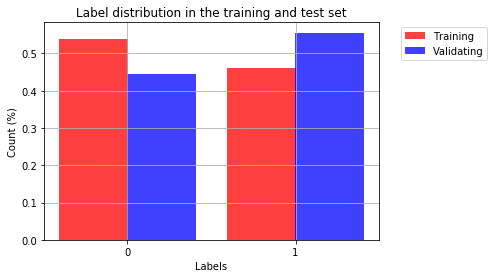

 Build Time: [0.08655760000002033]
sent_cnt_vec_unigram_v1 Naive Bayes with CV Predict Time: [0.0008186000000023341]


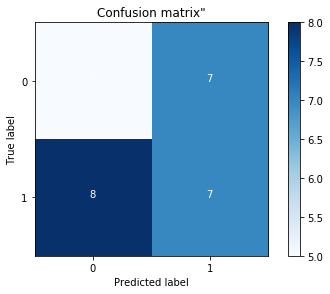

   id                                     word_frequency
0   0  [and:1, at:1, dining:1, dishes:1, good:1, high...
1   6  [again:1, an:1, and:1, any:1, are:2, at:1, bad...
2   8  [amount:1, and:4, as:2, at:2, average:1, bread...
3   9  [and:3, at:1, average:1, be:1, beer:1, before:...
4  12  [and:3, any:1, asked:1, best:1, by:1, can:2, c...
   id  True_Label  Predicted_Label  \
0  35           1                0   
1  46           0                0   
2   8           0                1   
3   6           0                0   
4   9           0                0   

                                      word_frequency  
0  [about:1, all:1, also:1, although:1, am:1, and...  
1  [along:1, and:3, by:1, champagne:1, chicken:1,...  
2  [amount:1, and:4, as:2, at:2, average:1, bread...  
3  [again:1, an:1, and:1, any:1, are:2, at:1, bad...  
4  [and:3, at:1, average:1, be:1, beer:1, before:...  
   id  True_Label  Predicted_Label  \
0  35           1                0   
1  46           0      

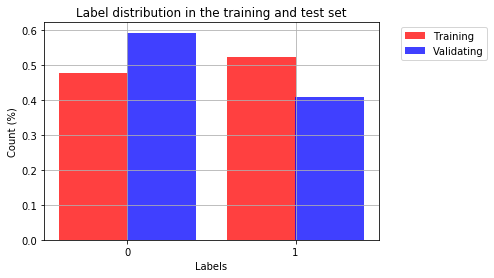

 Build Time: [0.11518940000001976]
sent_cnt_vec_unigram_v2 Naive Bayes with CV Predict Time: [0.0010528999999905864]


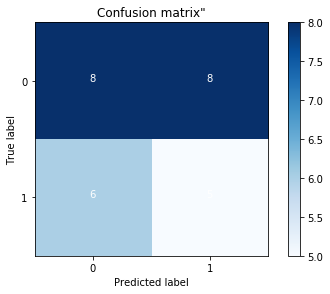

   id                                     word_frequency
0   0  [and:1, at:1, dining:1, dishes:1, good:1, high...
1   1  [and:1, around:1, back:1, be:1, bite:1, but:2,...
2   2  [and:2, any:2, at:2, began:1, believe:1, but:1...
3   4  [again:1, although:1, and:5, at:1, before:1, b...
4   5  [about:1, again:1, and:7, as:1, asked:1, at:2,...
   id  True_Label  Predicted_Label  \
0  23           1                1   
1  21           0                0   
2  38           1                1   
3  36           1                0   
4  14           0                0   

                                      word_frequency  
0  [after:1, and:2, any:1, appetizer:1, arrived:1...  
1  [and:2, big:1, bland:1, disappointed:1, food:1...  
2  [already:1, american:1, amount:1, an:2, and:10...  
3  [and:1, are:1, around:1, at:3, before:1, bhart...  
4  [all:1, also:1, and:5, at:1, ate:1, bad:1, bef...  
   id  True_Label  Predicted_Label  \
0  23           1                1   
1  21           0      

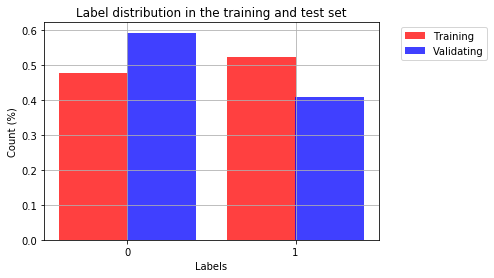

 Build Time: [0.10498889999999506]
sent_cnt_vec_unigram_v3 Naive Bayes with CV Predict Time: [0.0014319999999941047]


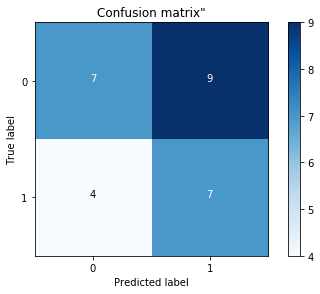

   id                                     word_frequency
0   2  [began:1, believe:1, cant:1, chicken:2, dinner...
1   4  [although:1, bland:1, brewed:1, brought:1, buf...
2   8  [amount:1, average:1, bread:2, cold:2, comfort...
3  13  [asked:1, bad:1, believe:1, best:1, cold:1, do...
4  14  [also:1, ate:1, bad:1, black:1, burger:2, busy...
   id  True_Label  Predicted_Label  \
0  57           0                1   
1  65           0                1   
2  83           1                0   
3  48           0                1   
4  42           1                1   

                                      word_frequency  
0  [also:1, always:1, ask:1, bring:1, felt:1, goo...  
1  [attentive:1, bar:1, big:1, check:1, cicero:1,...  
2  [amazing:1, baked:1, bread:2, cheese:1, cooked...  
3  [beer:2, best:1, cold:1, delicious:1, food:1, ...  
4  [area:1, best:1, favorite:1, friends:1, love:1...  
   id  True_Label  Predicted_Label  \
0  57           0                1   
1  65           0      

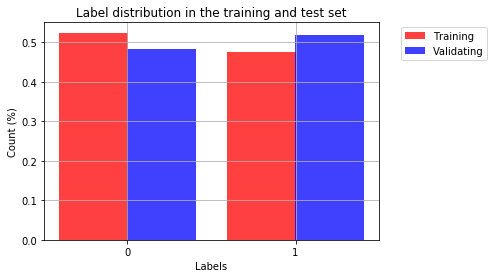

 Build Time: [0.08473319999998807]
sent_cnt_vec_unigram_v4 Naive Bayes with CV Predict Time: [0.0012700999999992746]


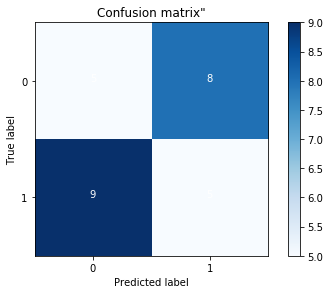

   id                                     word_frequency
0   2  [began:1, believ:1, cant:1, chicken:2, dinner:...
1   7  [almost:1, bit:1, chop:1, cost:1, didnt:2, dri...
2   8  [amount:1, averag:1, bread:2, cold:2, comfort:...
3  10  [ambianc:1, back:1, bread:1, call:1, campu:1, ...
4  11  [also:3, american:1, area:1, back:1, buffet:1,...
   id  True_Label  Predicted_Label  \
0  68           0                1   
1  83           1                0   
2  64           0                0   
3  10           0                0   
4  39           1                0   

                                      word_frequency  
0  [awesom:1, favorit:1, like:1, much:1, pork:1, ...  
1  [amaz:1, bake:1, bread:2, chees:1, comfort:1, ...  
2  [amaz:1, ambianc:1, ate:1, bean:1, black:1, ca...  
3  [ambianc:1, back:1, bread:1, call:1, campu:1, ...  
4  [add:1, also:2, bite:2, bland:1, bread:1, burg...  
   id  True_Label  Predicted_Label  \
0  68           0                1   
1  83           1      

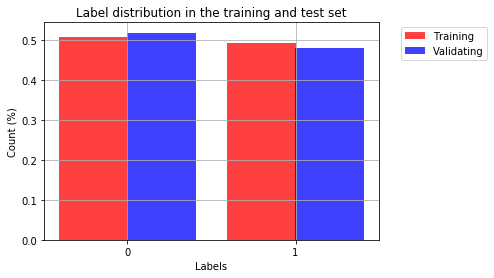

 Build Time: [0.07361519999997768]
sent_tfidf_vec_unigram_v1 Naive Bayes with CV Predict Time: [0.0008311999999932596]


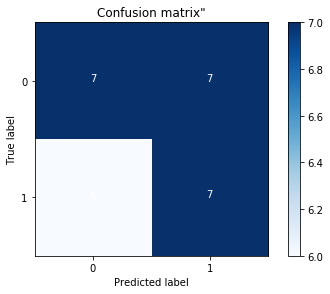

   id                                     word_frequency
0   1  [and:0.051901306109056654, around:0.1558812454...
1   5  [about:0.06701868371823314, again:0.0670186837...
2  10  [about:0.05456063353032709, after:0.1194955966...
3  13  [about:0.10813416714442672, all:0.105273794911...
4  15  [and:0.12002555912411304, are:0.13856075613678...
   id  True_Label  Predicted_Label  \
0  41           1                1   
1  13           0                0   
2  88           1                0   
3  42           1                1   
4  38           1                0   

                                      word_frequency  
0  [always:0.23046245464452975, and:0.07429360826...  
1  [about:0.10813416714442672, all:0.105273794911...  
2  [and:0.18332339456450705, came:0.1298267331004...  
3  [and:0.07326609022990453, area:0.2675900570229...  
4  [already:0.04438861241247735, american:0.04656...  
   id  True_Label  Predicted_Label  \
0  41           1                1   
1  13           0      

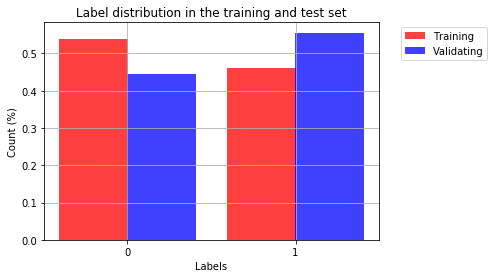

 Build Time: [0.10375019999997903]
sent_tfidf_vec_unigram_v2 Naive Bayes with CV Predict Time: [0.0008958999999890693]


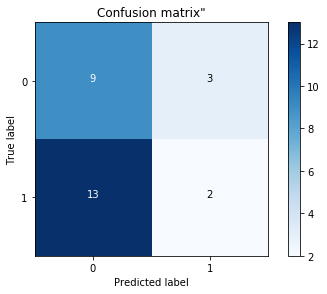

   id                                     word_frequency
0   0  [and:0.052013255954879045, at:0.09662933560495...
1  16  [and:0.06330192809954267, at:0.117601237270703...
2  17  [any:0.21248984451701083, did:0.28963709877262...
3  25  [and:0.07693588557897811, at:0.071465084921089...
4  26  [and:0.04866153478925936, back:0.1247401515839...
   id  True_Label  Predicted_Label  \
0  63           0                0   
1  76           1                0   
2  74           1                0   
3  47           0                0   
4  84           1                1   

                                      word_frequency  
0  [about:0.18268470729080943, always:0.100026414...  
1  [always:0.1257872031762867, an:0.1090150157239...  
2  [and:0.1462575149237947, are:0.337687272717845...  
3  [amazing:0.15674575258283924, ambiance:0.19265...  
4  [add:0.10679311169945947, always:0.08579653191...  
   id  True_Label  Predicted_Label  \
0  63           0                0   
1  76           1      

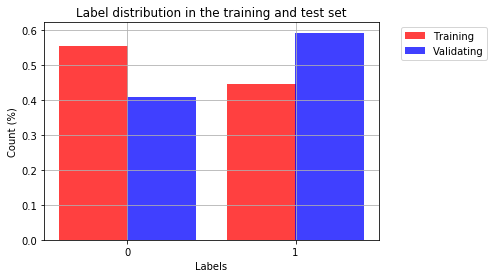

 Build Time: [0.11200759999999832]
sent_tfidf_vec_unigram_v3 Naive Bayes with CV Predict Time: [0.0008783000000107677]


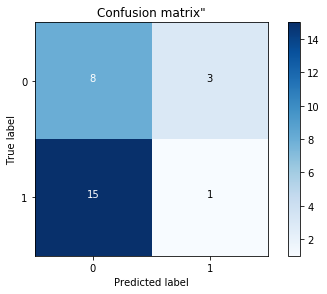

   id                                     word_frequency
0   9  [average:0.22923249118274325, beer:0.216830759...
1  17  [dishes:0.26741316574020996, ever:0.2674131657...
2  19  [calling:0.4883546540255209, dirty:0.244177327...
3  20  [asked:0.34003214564913753, back:0.28099054664...
4  21  [big:0.24952359494082607, bland:0.224994194184...
   id  True_Label  Predicted_Label  \
0  71           1                0   
1  29           1                0   
2  34           1                0   
3  67           0                0   
4   9           0                0   

                                      word_frequency  
0  [always:0.31486614771630395, best:0.1070303175...  
1  [already:0.12031813624009853, american:0.12621...  
2  [add:0.2170238394021207, around:0.168811015594...  
3  [chicken:0.2602189195729342, friendly:0.252488...  
4  [average:0.22923249118274325, beer:0.216830759...  
   id  True_Label  Predicted_Label  \
0  71           1                0   
1  29           1      

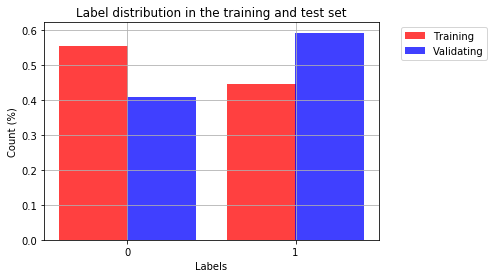

 Build Time: [0.08538199999998142]
sent_tfidf_vec_unigram_v4 Naive Bayes with CV Predict Time: [0.0016480999999828327]


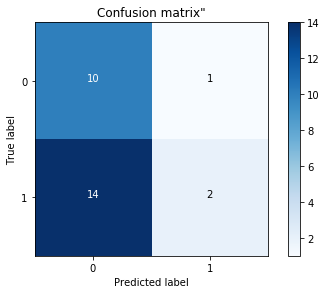

   id                                     word_frequency
0   2  [began:0.17698458516327714, believ:0.167409522...
1   3  [away:0.16697141425743867, began:0.17652141890...
2   4  [although:0.10728048947666342, bland:0.0904271...
3   8  [amount:0.1836666564789305, averag:0.171691442...
4  13  [arriv:0.19222051468902313, ask:0.133836967794...
   id  True_Label  Predicted_Label  \
0  39           1                0   
1  59           0                0   
2  37           1                0   
3  89           1                0   
4  72           1                0   

                                      word_frequency  
0  [add:0.14087675436780162, also:0.2263579880675...  
1  [around:0.2017043649087785, better:0.277398192...  
2  [call:0.18125184846293557, chicken:0.212362367...  
3  [attend:0.44402545056059634, busi:0.1963093176...  
4  [amaz:0.19128460111725992, definit:0.196784996...  
   id  True_Label  Predicted_Label  \
0  39           1                0   
1  59           0      

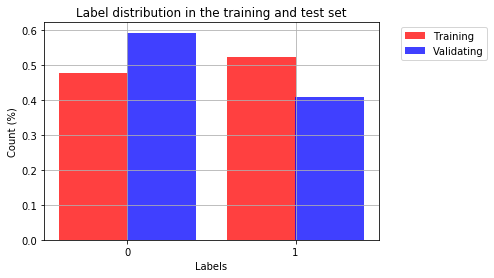

 Build Time: [0.10973200000000816]
sent_cnt_vec_bigram_v1 Naive Bayes with CV Predict Time: [0.001323799999994435]


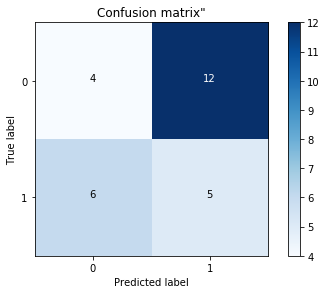

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   2  [and:2, any:2, any_more:1, at:2, began:1, bega...
2   3  [an:1, and:6, and_the:1, and_waited:1, away:1,...
3   8  [amount:1, amount_of:1, and:4, and_the:1, and_...
4  17  [any:1, any_of:1, did:1, did_not:1, dishes:1, ...
   id  True_Label  Predicted_Label  \
0  18           0                1   
1   0           0                1   
2  53           0                1   
3  52           0                1   
4  43           1                1   

                                      word_frequency  
0  [all:1, and:5, and_it:1, and_there:1, anywhere...  
1  [and:1, and_the:1, at:1, at_least:1, dining:1,...  
2  [and:3, by:1, dining:1, into:1, into_the:1, it...  
3  [again:1, also:1, and:3, and_my:1, and_talked:...  
4  [again:1, amazing:1, and:1, atmosphere:1, atmo...  
   id  True_Label  Predicted_Label  \
0  18           0                1   
1   0           0      

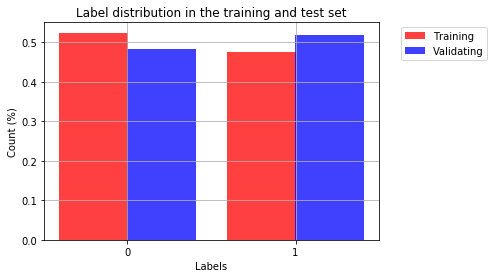

 Build Time: [0.07946060000000443]
sent_cnt_vec_bigram_v2 Naive Bayes with CV Predict Time: [0.0014277999999876556]


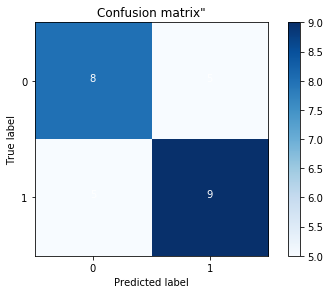

   id                                     word_frequency
0  10  [about:1, about_the:1, after:2, again:2, again...
1  12  [and:3, and_it:1, and_then:2, any:1, asked:1, ...
2  14  [all:1, also:1, also_not:1, and:5, and_had:1, ...
3  15  [and:2, and_the:1, are:1, bar:1, bar_the:1, di...
4  17  [any:1, any_of:1, did:1, did_not:1, dishes:1, ...
   id  True_Label  Predicted_Label  \
0  31           1                0   
1  78           1                0   
2  71           1                1   
3  10           0                0   
4  50           0                1   

                                      word_frequency  
0  [and:1, are:1, are_not:1, bad:2, can:2, can_no...  
1  [after:1, again:1, also:1, also_the:1, and:1, ...  
2  [about:1, about_the:1, always:2, and:5, and_th...  
3  [about:1, about_the:1, after:2, again:2, again...  
4  [ago:1, and:4, and_the:2, best:1, both:1, both...  
   id  True_Label  Predicted_Label  \
0  31           1                0   
1  78           1      

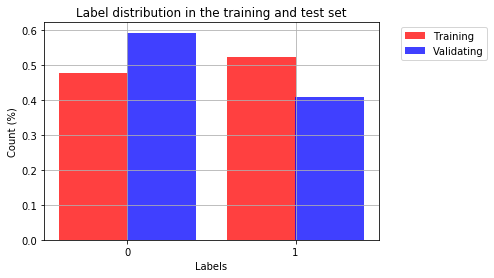

 Build Time: [0.08328929999998991]
sent_cnt_vec_bigram_v3 Naive Bayes with CV Predict Time: [0.0013172999999824242]


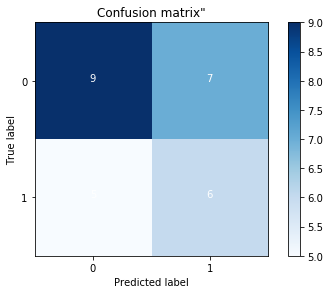

   id                                     word_frequency
0   3  [away:1, began:1, came:1, entered:1, entered_r...
1   4  [although:1, bland:1, brewed:1, brought:1, buf...
2  14  [also:1, ate:1, ate_restaurant:1, bad:1, bad_e...
3  16  [come:1, extremely:1, food:1, good:1, hour:1, ...
4  18  [anywhere:1, cheese:1, cool:1, dead:1, diner:1...
   id  True_Label  Predicted_Label  \
0  78           1                1   
1  16           0                1   
2  57           0                1   
3  69           1                1   
4  62           0                0   

                                      word_frequency  
0  [also:1, applebee:1, best:1, best_restaurant:1...  
1  [come:1, extremely:1, food:1, good:1, hour:1, ...  
2  [also:1, always:1, ask:1, bring:1, felt:1, fel...  
3  [amazing:1, best:1, cafe:1, die:1, different:1...  
4  [amazing:1, best:1, choose:2, customer:1, dini...  
   id  True_Label  Predicted_Label  \
0  78           1                1   
1  16           0      

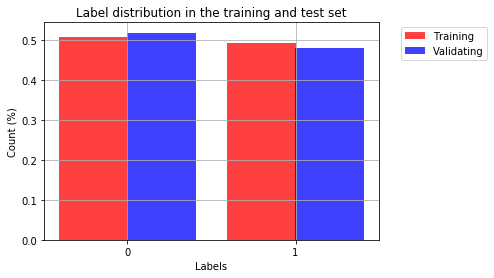

 Build Time: [0.09372559999999908]
sent_cnt_vec_bigram_v4 Naive Bayes with CV Predict Time: [0.0009203000000184147]


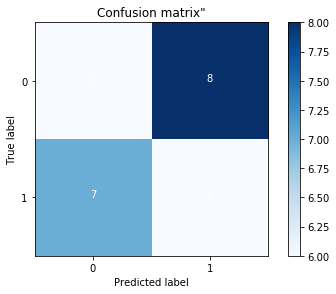

   id                                     word_frequency
0   2  [began:1, believ:1, cant:1, cant_believ:1, chi...
1   6  [bad:1, cook:1, could:1, diner:1, dish:2, done...
2  10  [ambianc:1, back:1, back_price:1, bread:1, cal...
3  14  [also:1, ate:1, ate_restaur:1, bad:1, bad_expe...
4  15  [bar:1, decor:1, dirti:1, expect:1, go:1, low:...
   id  True_Label  Predicted_Label  \
0  21           0                1   
1  34           1                1   
2  74           1                1   
3  72           1                0   
4  15           0                0   

                                      word_frequency  
0  [big:1, bland:1, disappoint:1, food:1, fun:1, ...  
1  [add:1, around:1, bake:1, bharta:1, buffet:1, ...  
2  [bean:1, cafe:1, coffe:2, cup:1, everi:1, fres...  
3  [amaz:1, definit:1, even:1, expect:1, food:1, ...  
4  [bar:1, decor:1, dirti:1, expect:1, go:1, low:...  
   id  True_Label  Predicted_Label  \
0  21           0                1   
1  34           1      

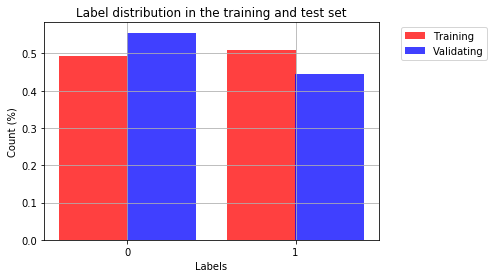

 Build Time: [0.09660119999998074]
sent_tfidf_vec_bigram_v1 Naive Bayes with CV Predict Time: [0.0016294000000129927]


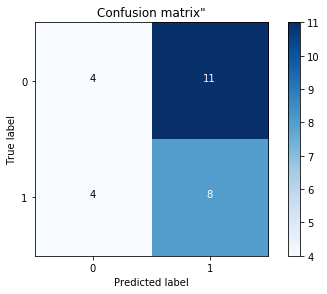

   id                                     word_frequency
0   1  [and:0.043814157584988134, around:0.1315921691...
1   2  [and:0.05635200251737034, any:0.15963039322678...
2   5  [about:0.05195407732027311, again:0.0519540773...
3   6  [again:0.08601706161466878, an:0.0816351068544...
4  10  [about:0.04442814099404069, about_the:0.052341...
   id  True_Label  Predicted_Label  \
0  22           0                1   
1  39           1                0   
2  83           1                0   
3  30           1                1   
4  56           0                1   

                                      word_frequency  
0  [dinner:0.2044657479080993, dishes:0.193493299...  
1  [add:0.100654087737631, also:0.161729001305482...  
2  [amazing:0.12172061995276799, and:0.3007848555...  
3  [all:0.21967394162108617, and:0.07965535433276...  
4  [all:0.09145578120859622, and:0.09948757605282...  
   id  True_Label  Predicted_Label  \
0  22           0                1   
1  39           1      

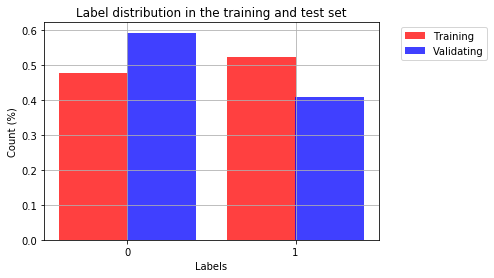

 Build Time: [0.08924909999998931]
sent_tfidf_vec_bigram_v2 Naive Bayes with CV Predict Time: [0.0015601000000060594]


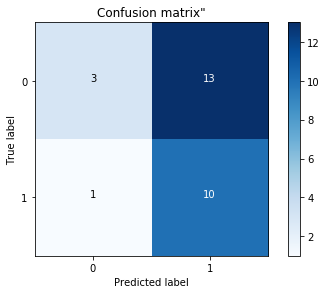

   id                                     word_frequency
0   0  [and:0.04532609739035845, and_the:0.0854727647...
1   2  [and:0.05635200251737034, any:0.15963039322678...
2   3  [an:0.07529758771059362, and:0.168048144220712...
3   4  [again:0.05059848380643895, although:0.0737794...
4   5  [about:0.05195407732027311, again:0.0519540773...
   id  True_Label  Predicted_Label  \
0  51           0                1   
1  49           0                1   
2  48           0                0   
3  53           0                1   
4  77           1                1   

                                      word_frequency  
0  [and:0.08587822511209103, and_the:0.0809715567...  
1  [and:0.05399887645319455, are:0.12467553088679...  
2  [an:0.1262692172035066, and:0.1409029709212453...  
3  [and:0.1622175656058449, by:0.1355419981754205...  
4  [an:0.08167698290119493, and:0.182285592665296...  
   id  True_Label  Predicted_Label  \
0  51           0                1   
1  49           0      

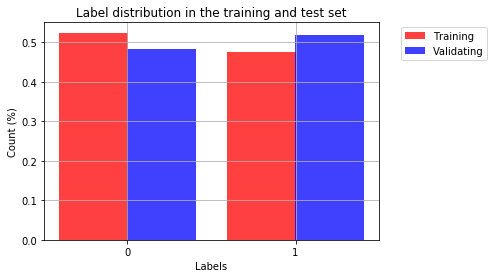

 Build Time: [0.07281190000000493]
sent_tfidf_vec_bigram_v3 Naive Bayes with CV Predict Time: [0.0008356000000162567]


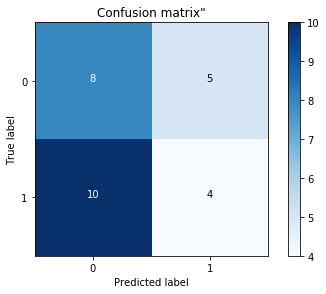

   id                                     word_frequency
0   3  [away:0.14601141260962158, began:0.15436260059...
1   7  [almost:0.1802346457536577, bit:0.168483201680...
2  10  [ambiance:0.09265844472272798, back:0.06822185...
3  14  [also:0.08626114167610666, ate:0.0968162824453...
4  24  [already:0.14285827337757828, bit:0.1584330212...
   id  True_Label  Predicted_Label  \
0  45           1                0   
1  82           1                1   
2  48           0                0   
3  10           0                0   
4  63           0                1   

                                      word_frequency  
0  [best:0.13471533851758694, best_experience:0.2...  
1  [around:0.3158880780310651, cafe:0.20305322870...  
2  [beer:0.44701979415628607, beer_list:0.2527747...  
3  [ambiance:0.09265844472272798, back:0.06822185...  
4  [always:0.13500405072619356, away:0.1589516437...  
   id  True_Label  Predicted_Label  \
0  45           1                0   
1  82           1      

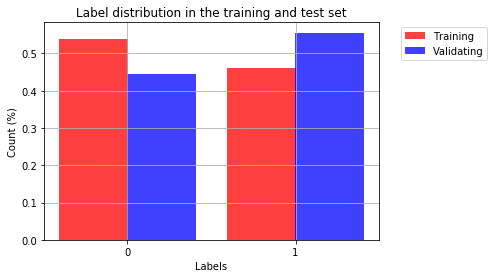

 Build Time: [0.10139909999998054]
sent_tfidf_vec_bigram_v4 Naive Bayes with CV Predict Time: [0.0009216999999921427]


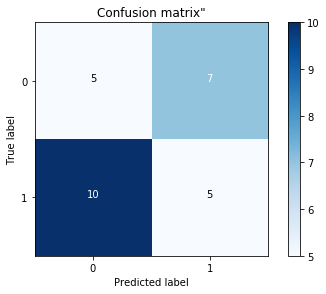

   id                                     word_frequency
0   2  [began:0.16055886664171437, believ:0.151872453...
1   3  [away:0.14639479215130954, began:0.15476790770...
2  10  [ambianc:0.08945304466043012, back:0.065861809...
3  18  [anywher:0.19099659461465898, chees:0.14853862...
4  19  [call:0.28663267167284445, dirti:0.21587257438...
   id  True_Label  Predicted_Label  \
0  34           1                1   
1  64           0                1   
2  19           0                1   
3  43           1                0   
4  26           1                1   

                                      word_frequency  
0  [add:0.19064853508587676, around:0.14829510397...  
1  [amaz:0.13197704749006664, ambianc:0.162208687...  
2  [call:0.28663267167284445, dirti:0.21587257438...  
3  [amaz:0.20848406947791442, atmospher:0.2688026...  
4  [back:0.13613833441035028, bar:0.1772382302615...  
   id  True_Label  Predicted_Label  \
0  34           1                1   
1  64           0      

In [64]:
#sent_mnb_feature_vec_files
#-----------------SENTIMENT MultinomialNB--------------------------------#
reportPath_sent_mnb = f'{outputDir}/sent_mnb_models_report.txt'
    
i=0
for m,v in X_train_sent_dfs_mnb.items():
    # instantiate niave bayes models
    mnb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    build_test_validate_models(logger,'mnb',mnb,m,v,y_lie,reportPath_sent_mnb,f'{outputDir}',f'{m}.txt')
    i+=1
    #break

Model Name:             sent_cnt_vec_unigram_bool_v1


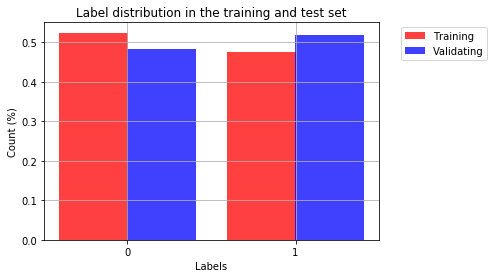

 Build Time: [0.1246489999999767]
sent_cnt_vec_unigram_bool_v1 Naive Bayes with CV Predict Time: [0.0016502000000002681]


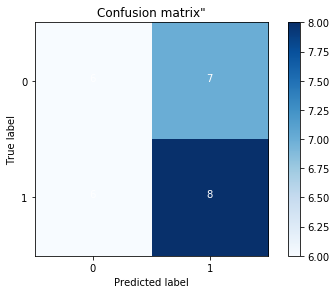

   id                                     word_frequency
0   1  [and:1, around:1, back:1, be:1, bite:1, but:1,...
1   2  [and:1, any:1, at:1, began:1, believe:1, but:1...
2   6  [again:1, an:1, and:1, any:1, are:1, at:1, bad...
3  10  [about:1, after:1, again:1, all:1, am:1, ambia...
4  11  [also:1, american:1, and:1, are:1, area:1, bac...
   id  True_Label  Predicted_Label  \
0  71           1                0   
1  51           0                1   
2  11           0                1   
3  60           0                0   
4  25           1                1   

                                      word_frequency  
0  [about:1, always:1, and:1, been:1, best:1, can...  
1  [and:1, are:1, best:1, birthday:1, cake:1, cel...  
2  [also:1, american:1, and:1, are:1, area:1, bac...  
3  [and:1, believe:1, best:1, better:1, but:1, ch...  
4  [and:1, at:1, been:1, before:1, buffet:1, by:1...  
   id  True_Label  Predicted_Label  \
0  71           1                0   
1  51           0      

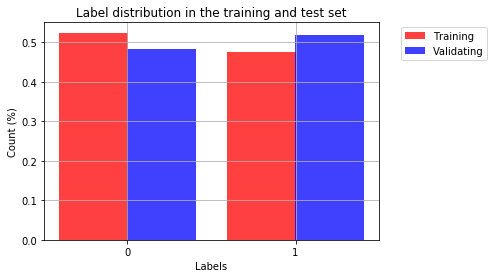

 Build Time: [0.10122450000000072]
sent_cnt_vec_unigram_bool_v2 Naive Bayes with CV Predict Time: [0.0010446999999942364]


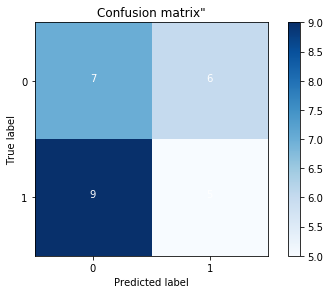

   id                                     word_frequency
0   3  [an:1, and:1, away:1, began:1, but:1, by:1, ca...
1   5  [about:1, again:1, and:1, as:1, asked:1, at:1,...
2   7  [almost:1, and:1, any:1, at:1, bit:1, but:1, c...
3  11  [also:1, american:1, and:1, are:1, area:1, bac...
4  14  [all:1, also:1, and:1, at:1, ate:1, bad:1, bef...
   id  True_Label  Predicted_Label  \
0  74           1                1   
1  61           0                0   
2  81           1                0   
3   7           0                0   
4  80           1                1   

                                      word_frequency  
0  [and:1, are:1, cafe:1, coffee:1, doing:1, ever...  
1  [again:1, all:1, amazing:1, ambiance:1, and:1,...  
2  [about:1, if:1, it:1, just:1, much:1, say:1, t...  
3  [almost:1, and:1, any:1, at:1, bit:1, but:1, c...  
4  [already:1, always:1, and:1, ask:1, big:1, can...  
   id  True_Label  Predicted_Label  \
0  74           1                1   
1  61           0      

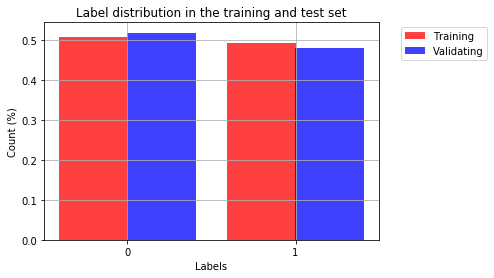

 Build Time: [0.10651770000001193]
sent_cnt_vec_unigram_bool_v3 Naive Bayes with CV Predict Time: [0.0015075999999965006]


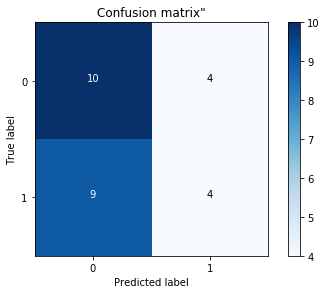

   id                                     word_frequency
0   4  [although:1, bland:1, brewed:1, brought:1, buf...
1   6  [bad:1, cooked:1, could:1, diner:1, dish:1, do...
2   9  [average:1, beer:1, bread:1, cooked:1, could:1...
3  10  [ambiance:1, back:1, bread:1, called:1, campus...
4  11  [also:1, american:1, area:1, back:1, buffet:1,...
   id  True_Label  Predicted_Label  \
0  87           1                0   
1   6           0                0   
2  40           1                0   
3  28           1                0   
4  14           0                0   

                                      word_frequency  
0  [amazing:1, ambiance:1, ate:1, best:1, called:...  
1  [bad:1, cooked:1, could:1, diner:1, dish:1, do...  
2  [awesome:1, bar:1, bring:1, cicero:1, dishes:1...  
3  [away:1, back:1, calling:1, decided:1, dish:1,...  
4  [also:1, ate:1, bad:1, black:1, burger:1, busy...  
   id  True_Label  Predicted_Label  \
0  87           1                0   
1   6           0      

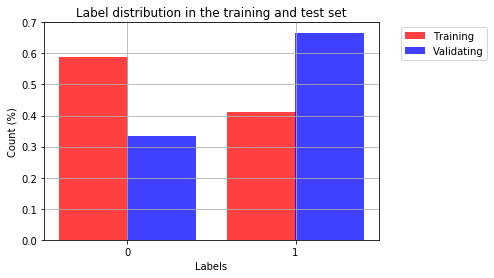

 Build Time: [0.10519570000002432]
sent_cnt_vec_unigram_bool_v4 Naive Bayes with CV Predict Time: [0.0014639000000045144]


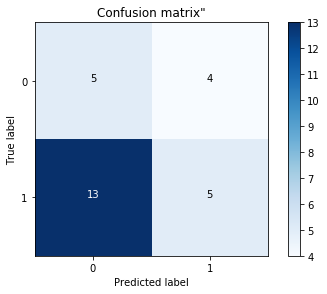

   id                                     word_frequency
0   0  [dine:1, dish:1, good:1, high:1, know:1, least...
1   5  [ask:1, averag:1, call:1, came:1, come:1, cook...
2  10  [ambianc:1, back:1, bread:1, call:1, campu:1, ...
3  12  [ask:1, best:1, citi:1, differ:1, find:1, foll...
4  13  [arriv:1, ask:1, bad:1, believ:1, best:1, cold...
   id  True_Label  Predicted_Label  \
0  10           0                1   
1  79           1                1   
2   5           0                0   
3  13           0                1   
4  29           1                0   

                                      word_frequency  
0  [ambianc:1, back:1, bread:1, call:1, campu:1, ...  
1  [around:1, ate:1, busi:1, comfort:1, environ:1...  
2  [ask:1, averag:1, call:1, came:1, come:1, cook...  
3  [arriv:1, ask:1, bad:1, believ:1, best:1, cold...  
4  [alreadi:1, american:1, area:1, around:1, atte...  
   id  True_Label  Predicted_Label  \
0  10           0                1   
1  79           1      

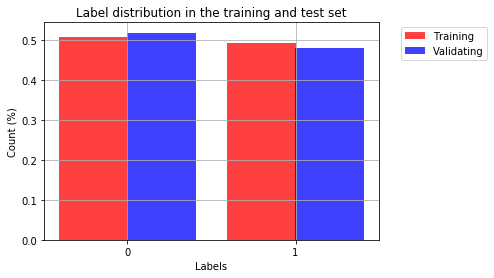

 Build Time: [0.11435849999998027]
sent_tfidf_vec_unigram_bool_v1 Naive Bayes with CV Predict Time: [0.001704300000000103]


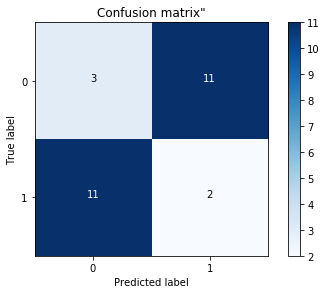

   id                                     word_frequency
0   1  [and:0.05934923463600971, around:0.17825047778...
1   3  [an:0.11675956635705563, and:0.043430405149526...
2   5  [about:0.11775818725430706, again:0.1177581872...
3  11  [also:0.15562608381731402, american:0.18323170...
4  12  [and:0.053036513877354675, any:0.1502384864319...
   id  True_Label  Predicted_Label  \
0  83           1                0   
1  64           0                0   
2  44           1                0   
3   1           0                1   
4  12           0                1   

                                      word_frequency  
0  [amazing:0.19767155550239737, and:0.0697811223...  
1  [amazing:0.14625345104984566, ambiance:0.17975...  
2  [after:0.15219489547652917, and:0.049062689896...  
3  [and:0.05934923463600971, around:0.17825047778...  
4  [and:0.053036513877354675, any:0.1502384864319...  
   id  True_Label  Predicted_Label  \
0  83           1                0   
1  64           0      

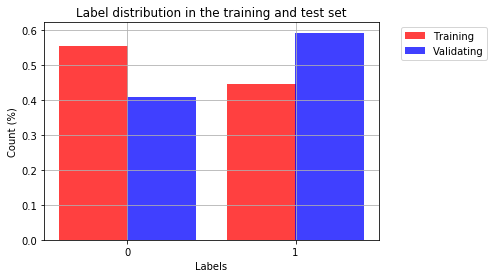

 Build Time: [0.09909940000000006]
sent_tfidf_vec_unigram_bool_v2 Naive Bayes with CV Predict Time: [0.0016548000000113916]


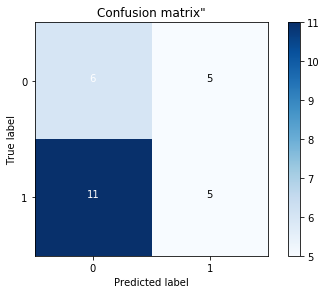

   id                                     word_frequency
0   6  [again:0.1538740671174698, an:0.14603528271565...
1   8  [amount:0.21107291190046212, and:0.05110090498...
2   9  [and:0.05718548012160772, at:0.106238205029790...
3  11  [also:0.15562608381731402, american:0.18323170...
4  12  [and:0.053036513877354675, any:0.1502384864319...
   id  True_Label  Predicted_Label  \
0  28           1                0   
1  11           0                1   
2   6           0                0   
3   9           0                0   
4  59           0                0   

                                      word_frequency  
0  [after:0.20586173251455592, again:0.1879892960...  
1  [also:0.15562608381731402, american:0.18323170...  
2  [again:0.1538740671174698, an:0.14603528271565...  
3  [and:0.05718548012160772, at:0.106238205029790...  
4  [and:0.0580293793226286, any:0.164381960288313...  
   id  True_Label  Predicted_Label  \
0  28           1                0   
1  11           0      

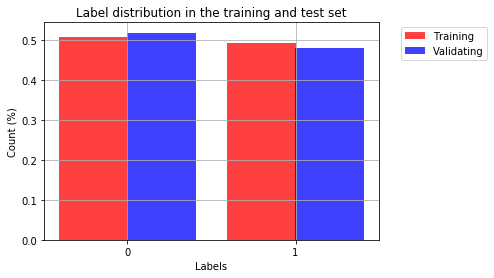

 Build Time: [0.10800419999998212]
sent_tfidf_vec_unigram_bool_v3 Naive Bayes with CV Predict Time: [0.0012638000000038119]


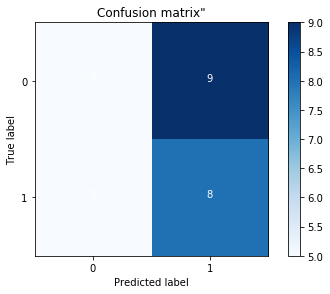

   id                                     word_frequency
0   0  [dining:0.20216609303432126, dishes:0.19131705...
1   1  [around:0.1939857219524029, back:0.16556733200...
2   4  [although:0.16558256611802685, bland:0.1395701...
3   5  [asked:0.1506790013198504, average:0.187553961...
4   6  [bad:0.19286284713899662, cooked:0.19919651016...
   id  True_Label  Predicted_Label  \
0  54           0                0   
1  56           0                1   
2  38           1                0   
3  40           1                0   
4  60           0                1   

                                      word_frequency  
0  [along:0.16533784517658084, amazing:0.11338995...  
1  [area:0.23498004468386327, around:0.1932322480...  
2  [already:0.09990994335532986, american:0.10480...  
3  [awesome:0.2625329970347749, bar:0.22691285168...  
4  [believe:0.2556851955648448, best:0.1476380150...  
   id  True_Label  Predicted_Label  \
0  54           0                0   
1  56           0      

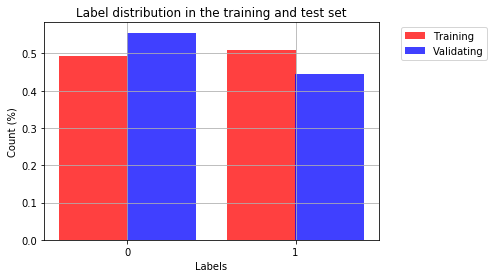

 Build Time: [0.11460260000001199]
sent_tfidf_vec_unigram_bool_v4 Naive Bayes with CV Predict Time: [0.001256600000004937]


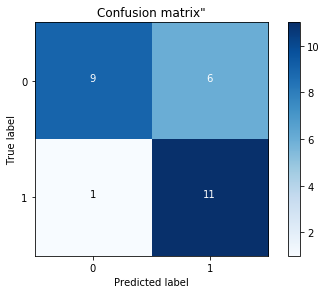

   id                                     word_frequency
0   0  [dine:0.16848870539298658, dish:0.161714372297...
1   2  [began:0.26313558111781904, believ:0.248899654...
2   4  [although:0.165466828100851, bland:0.139472621...
3   5  [ask:0.13194480998042923, averag:0.18950294304...
4   6  [bad:0.19802703042831407, cook:0.1980270304283...
   id  True_Label  Predicted_Label  \
0   4           0                1   
1  69           1                1   
2  42           1                1   
3  49           0                1   
4  23           1                1   

                                      word_frequency  
0  [although:0.165466828100851, bland:0.139472621...  
1  [amaz:0.18545141631604714, best:0.138064967602...  
2  [area:0.43410661843714743, best:0.250662301115...  
3  [food:0.2021669864178677, great:0.354951493012...  
4  [appet:0.2151318964196868, applebe:0.227436461...  
   id  True_Label  Predicted_Label  \
0   4           0                1   
1  69           1      

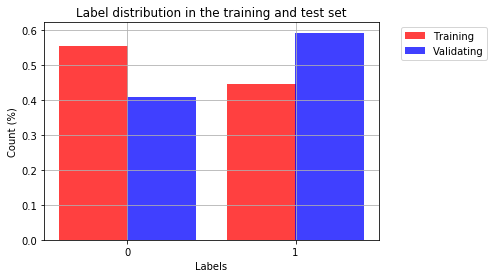

 Build Time: [0.1198219999999992]
sent_cnt_vec_bigram_bool_v1 Naive Bayes with CV Predict Time: [0.002341199999989385]


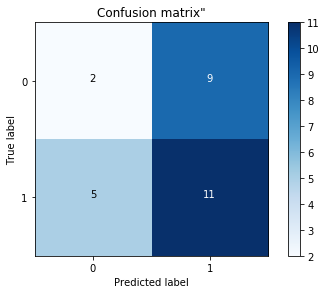

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   1  [and:1, around:1, back:1, back_for:1, be:1, bi...
2   6  [again:1, an:1, an_hour:1, and:1, and_when:1, ...
3  11  [also:1, american:1, and:1, are:1, area:1, bac...
4  20  [and:1, asked:1, asked_him:1, back:1, back_to:...
   id  True_Label  Predicted_Label  \
0   0           0                1   
1  29           1                1   
2  31           1                1   
3  74           1                1   
4  72           1                0   

                                      word_frequency  
0  [and:1, and_the:1, at:1, at_least:1, dining:1,...  
1  [already:1, american:1, an:1, and:1, and_chees...  
2  [and:1, are:1, are_not:1, bad:1, can:1, can_no...  
3  [and:1, and_good:1, and_they:1, are:1, cafe:1,...  
4  [amazing:1, and:1, be:1, but:1, even:1, expect...  
   id  True_Label  Predicted_Label  \
0   0           0                1   
1  29           1      

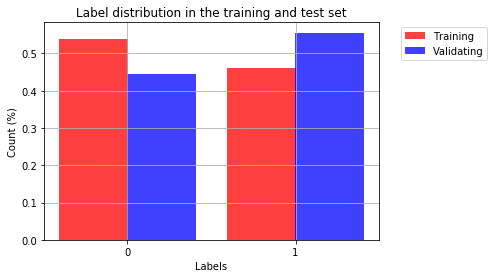

 Build Time: [0.1012280000000203]
sent_cnt_vec_bigram_bool_v2 Naive Bayes with CV Predict Time: [0.0013012000000003354]


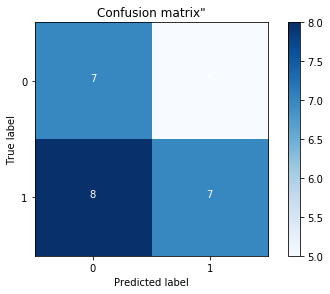

   id                                     word_frequency
0   0  [and:1, and_the:1, at:1, at_least:1, dining:1,...
1   3  [an:1, and:1, and_the:1, and_waited:1, away:1,...
2   6  [again:1, an:1, an_hour:1, and:1, and_when:1, ...
3   7  [almost:1, and:1, any:1, any_more:1, at:1, bit...
4   8  [amount:1, amount_of:1, and:1, and_the:1, and_...
   id  True_Label  Predicted_Label  \
0  10           0                0   
1  36           1                1   
2  79           1                1   
3  50           0                1   
4  45           1                1   

                                      word_frequency  
0  [about:1, about_the:1, after:1, again:1, again...  
1  [and:1, are:1, around:1, around_pm:1, at:1, at...  
2  [all:1, and:1, and_it:1, and_talked:1, and_the...  
3  [ago:1, and:1, and_the:1, best:1, both:1, both...  
4  [and:1, and_the:1, best:1, best_experience:1, ...  
   id  True_Label  Predicted_Label  \
0  10           0                0   
1  36           1      

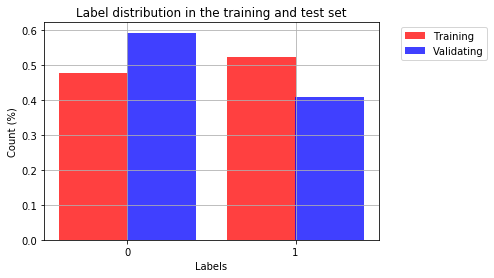

 Build Time: [0.1143114000000196]
sent_cnt_vec_bigram_bool_v3 Naive Bayes with CV Predict Time: [0.0016037999999980457]


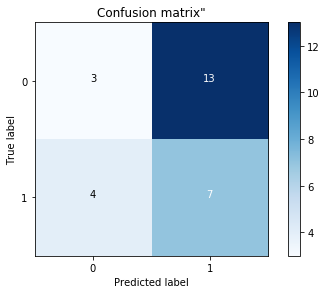

   id                                     word_frequency
0   1  [around:1, back:1, bite:1, called:1, come:1, d...
1   6  [bad:1, cooked:1, could:1, diner:1, dish:1, do...
2   8  [amount:1, average:1, bread:1, cold:1, comfort...
3  12  [asked:1, best:1, city:1, different:1, find:1,...
4  13  [asked:1, bad:1, believe:1, best:1, cold:1, do...
   id  True_Label  Predicted_Label  \
0  60           0                1   
1  12           0                1   
2  18           0                1   
3  53           0                1   
4  47           0                1   

                                      word_frequency  
0  [believe:1, best:1, better:1, chocolate:1, cre...  
1  [asked:1, best:1, city:1, different:1, find:1,...  
2  [anywhere:1, cheese:1, cool:1, dead:1, diner:1...  
3  [dining:1, kept:1, kind:1, light:1, need:1, ni...  
4  [amazing:1, ambiance:1, best:1, birthday:1, de...  
   id  True_Label  Predicted_Label  \
0  60           0                1   
1  12           0      

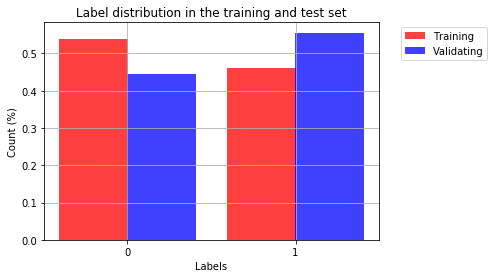

 Build Time: [0.10264189999998052]
sent_cnt_vec_bigram_bool_v4 Naive Bayes with CV Predict Time: [0.0014835000000061882]


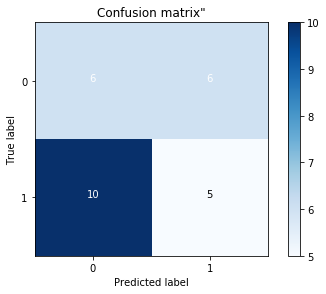

   id                                     word_frequency
0   4  [although:1, bland:1, brew:1, brought:1, buffa...
1   5  [ask:1, averag:1, call:1, came:1, come:1, cook...
2   8  [amount:1, averag:1, bread:1, cold:1, comfort:...
3   9  [averag:1, beer:1, bread:1, cook:1, could:1, d...
4  11  [also:1, american:1, area:1, back:1, buffet:1,...
   id  True_Label  Predicted_Label  \
0   9           0                1   
1  74           1                1   
2  86           1                0   
3  38           1                1   
4  75           1                0   

                                      word_frequency  
0  [averag:1, beer:1, bread:1, cook:1, could:1, d...  
1  [bean:1, cafe:1, coffe:1, cup:1, everi:1, fres...  
2  [american:1, anywher:1, ask:1, authent:1, bad:...  
3  [actual:1, alreadi:1, american:1, amount:1, as...  
4  [atmospher:1, bar:1, best:1, best_dine:1, danc...  
   id  True_Label  Predicted_Label  \
0   9           0                1   
1  74           1      

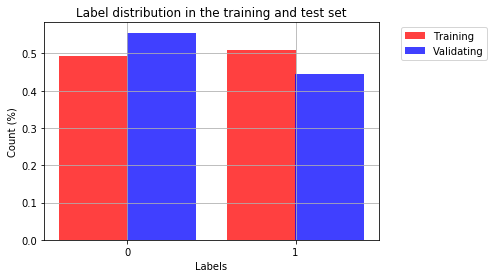

 Build Time: [0.16497160000000122]
sent_tfidf_vec_bigram_bool_v1 Naive Bayes with CV Predict Time: [0.00157029999999736]


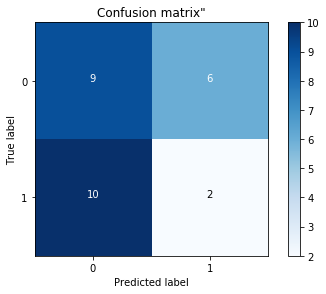

   id                                     word_frequency
0   0  [and:0.04968526392262141, and_the:0.0936929742...
1   1  [and:0.04802408242423117, around:0.14423632739...
2   3  [an:0.0906474350620617, and:0.0337176212052007...
3   4  [again:0.07388800109388356, although:0.1077386...
4   9  [and:0.03873267250148942, and_the:0.0730393480...
   id  True_Label  Predicted_Label  \
0  27           1                0   
1  22           0                1   
2   4           0                0   
3  45           1                0   
4   1           0                1   

                                      word_frequency  
0  [asked:0.11895338610000308, asked_the:0.158391...  
1  [dinner:0.21421008640524047, dishes:0.20271471...  
2  [again:0.07388800109388356, although:0.1077386...  
3  [and:0.050741791397411334, and_the:0.095685299...  
4  [and:0.04802408242423117, around:0.14423632739...  
   id  True_Label  Predicted_Label  \
0  27           1                0   
1  22           0      

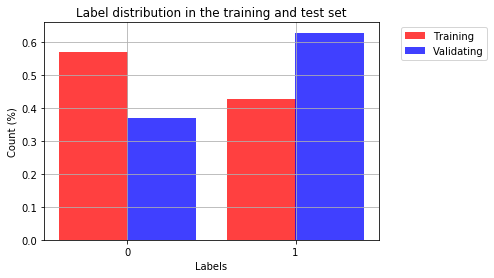

 Build Time: [0.2589360000000056]
sent_tfidf_vec_bigram_bool_v2 Naive Bayes with CV Predict Time: [0.004449899999997342]


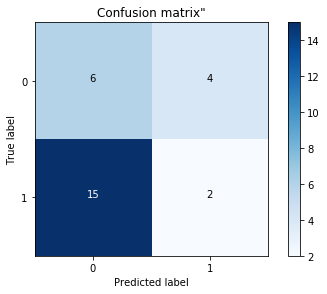

   id                                     word_frequency
0   3  [an:0.0906474350620617, and:0.0337176212052007...
1  13  [about:0.0968872572379514, all:0.0943243890190...
2  15  [and:0.050164578088873826, and_the:0.094596831...
3  17  [any:0.16509402473544987, any_of:0.24072934570...
4  20  [and:0.041294880325026664, asked:0.12809876523...
   id  True_Label  Predicted_Label  \
0  15           0                0   
1  13           0                0   
2  29           1                0   
3  85           1                0   
4  42           1                0   

                                      word_frequency  
0  [and:0.050164578088873826, and_the:0.094596831...  
1  [about:0.0968872572379514, all:0.0943243890190...  
2  [already:0.11164312817916217, american:0.11711...  
3  [amazing:0.17588774834615464, and:0.0620911008...  
4  [and:0.06463078009923581, area:0.2360512766263...  
   id  True_Label  Predicted_Label  \
0  15           0                0   
1  13           0      

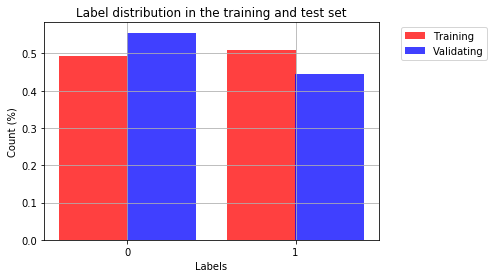

 Build Time: [0.18039880000000608]
sent_tfidf_vec_bigram_bool_v3 Naive Bayes with CV Predict Time: [0.002142300000002706]


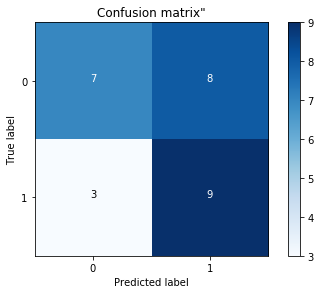

   id                                     word_frequency
0   4  [although:0.14147047980880378, bland:0.1192460...
1  12  [asked:0.19201109235708752, best:0.13053806096...
2  14  [also:0.1213449453509578, ate:0.13619303285505...
3  15  [bar:0.228048934456, dirty:0.2638474189074877,...
4  17  [dishes:0.2520723219248183, ever:0.25207232192...
   id  True_Label  Predicted_Label  \
0  78           1                1   
1  76           1                1   
2  14           0                0   
3  17           0                0   
4  56           0                0   

                                      word_frequency  
0  [also:0.16436717804364212, applebee:0.21886195...  
1  [always:0.16654597665143892, back:0.1376277084...  
2  [also:0.1213449453509578, ate:0.13619303285505...  
3  [dishes:0.2520723219248183, ever:0.25207232192...  
4  [area:0.20543273174723087, around:0.1689344668...  
   id  True_Label  Predicted_Label  \
0  78           1                1   
1  76           1      

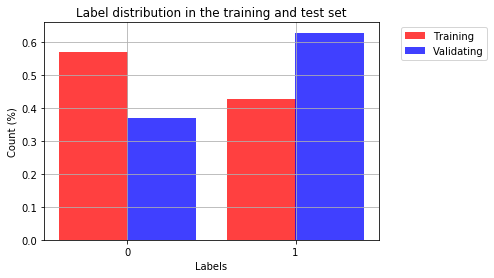

 Build Time: [0.13708710000000224]
sent_tfidf_vec_bigram_bool_v4 Naive Bayes with CV Predict Time: [0.0011631000000136282]


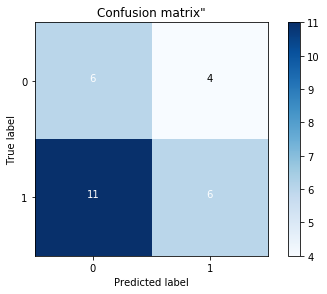

   id                                     word_frequency
0   6  [bad:0.18479465302532275, cook:0.1847946530253...
1  11  [also:0.15267761684335998, american:0.17976022...
2  14  [also:0.11873130471920038, ate:0.1332595802633...
3  20  [actual:0.2641705963815527, ask:0.171940885518...
4  24  [alreadi:0.1454144983386929, bit:0.16126793188...
   id  True_Label  Predicted_Label  \
0  40           1                1   
1  25           1                0   
2  11           0                1   
3  38           1                1   
4  24           1                0   

                                      word_frequency  
0  [awesom:0.20509579110310153, bar:0.17726865328...  
1  [buffet:0.21486889766441952, citi:0.2032442518...  
2  [also:0.15267761684335998, american:0.17976022...  
3  [actual:0.11021306164952713, alreadi:0.0928990...  
4  [alreadi:0.1454144983386929, bit:0.16126793188...  
   id  True_Label  Predicted_Label  \
0  40           1                1   
1  25           1      

In [65]:
#sent_bnb_feature_vec_files
#-----------------SENTIMENT BernoulliNB--------------------------------#
reportPath_sent_bnb = f'{outputDir}/sent_bnb_models_report.txt'
    
i=0
for m,v in X_train_sent_dfs_bnb.items():
    bnb = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None)
    build_test_validate_models(logger,'bnb',bnb,m,v,y_lie,reportPath_sent_bnb,f'{outputDir}',f'{m}.txt')
    i+=1
    #break

#### --------------------------------------------------------------------------------------------
#### --------------------------------------------------------------------------------------------

In [66]:
# build summary report df
summary_report_df = pd.DataFrame()

summary_report_df['Model_Type'] = model_types
summary_report_df['Category'] = categories
summary_report_df['Vectorizer'] = vectorizers
summary_report_df['N_Gram'] = ngrams
summary_report_df['Experiment_Model_Name'] = exp_model_names
summary_report_df['Dataset_Version'] = dataset_versions
summary_report_df['Cross_Folds'] = cross_folds
summary_report_df['Prediction_Accuracy'] = prediction_accuracys
summary_report_df['Total_Prediction_Points'] = total_prediction_points
summary_report_df['Test_Recall_Score_Avg'] = test_recall_score_avgs
summary_report_df['Test_Precision_Score_Avg'] = test_precision_score_avgs
summary_report_df['Train_Recall_Score_Avg'] = train_recall_score_avgs
summary_report_df['Train_Precision_Score_Avg'] = train_precision_score_avgs
summary_report_df['Total_Build_Time'] = total_build_times
summary_report_df['Total_Predict_Time'] = total_predict_time
summary_report_df['Confusion_Matrix'] = confusion_matrixs

summary_report_df.head(10)

Model_Type Category Vectorizer   N_Gram  \
0  Multinomial Naive Bayes      lie      count  unigram   
1  Multinomial Naive Bayes      lie      count  unigram   
2  Multinomial Naive Bayes      lie      count  unigram   
3  Multinomial Naive Bayes      lie      count  unigram   
4  Multinomial Naive Bayes      lie      tfidf  unigram   
5  Multinomial Naive Bayes      lie      tfidf  unigram   
6  Multinomial Naive Bayes      lie      tfidf  unigram   
7  Multinomial Naive Bayes      lie      tfidf  unigram   
8  Multinomial Naive Bayes      lie      count   bigram   
9  Multinomial Naive Bayes      lie      count   bigram   

      Experiment_Model_Name Dataset_Version  Cross_Folds  Prediction_Accuracy  \
0    lie_cnt_vec_unigram_v1              v1           10                48.15   
1    lie_cnt_vec_unigram_v2              v2           10                44.44   
2    lie_cnt_vec_unigram_v3              v3           10                51.85   
3    lie_cnt_vec_unigram_v4              v4           10                40.74   
4  lie_tfidf_vec_unigram_v1              v1           10                40.74   
5  lie_tfidf_vec_unigram_v2              v2           10                51.85   
6  lie_tfidf_vec_unigram_v3              v3           10                48.15   
7  lie_tfidf_vec_unigram_v4              v4           10                25.93   
8     lie_cnt_vec_bigram_v1              v1           10                44.44   
9     lie_cnt_vec_bigram_v2              v2           10                33.33   

   Total_Prediction_Points  Test_Recall_Score_Avg  Test_Precision_Score_Avg  \
0                       27                 0.4000                    0.3742   
1                       27                 0.4583                    0.4583   
2                       27                 0.4750                    0.4933   
3                       27                 0.4333                    0.3892   
4                       27                 0.4542                    0.4225   
5                       27                 0.4500                    0.4358   
6                       27                 0.5042                    0.5100   
7                       27                 0.4417                    0.3088   
8                       27                 0.4125                    0.3631   
9                       27                 0.4708                    0.4875   

   Train_Recall_Score_Avg  Train_Precision_Score_Avg  Total_Build_Time  \
0                  0.9687                     0.9699            0.0780   
1                  0.9752                     0.9758            0.1044   
2                  0.9576                     0.9583            0.0859   
3                  0.9609                     0.9748            0.0707   
4                  0.9964                     0.9966            0.0887   
5                  0.9911                     0.9918            0.0896   
6                  0.9759                     0.9792            0.0893   
7                  0.9569                     0.9700            0.0844   
8                  0.9875                     0.9884            0.0978   
9                  0.9905                     0.9887            0.1034   

   Total_Predict_Time     Confusion_Matrix  
0              0.0008      [[7 7]\n [7 6]]  
1              0.0014      [[7 8]\n [7 5]]  
2              0.0012      [[9 6]\n [7 5]]  
3              0.0014  [[ 2  4]\n [12  9]]  
4              0.0008  [[ 4 11]\n [ 5  7]]  
5              0.0011      [[7 7]\n [6 7]]  
6              0.0012      [[8 5]\n [9 5]]  
7              0.0009  [[ 2 17]\n [ 3  5]]  
8              0.0016      [[8 7]\n [8 4]]  
9              0.0009  [[ 3  8]\n [10  6]]

In [67]:
sorted_summary_report = summary_report_df.sort_values(by=['Prediction_Accuracy','Experiment_Model_Name'], ascending=False)
sorted_summary_report.head(10)

Model_Type   Category Vectorizer   N_Gram  \
55     Benoulli Naive Bayes  sentiment      tfidf  unigram   
27     Benoulli Naive Bayes        lie      count   bigram   
41  Multinomial Naive Bayes  sentiment      count   bigram   
62     Benoulli Naive Bayes  sentiment      tfidf   bigram   
42  Multinomial Naive Bayes  sentiment      count   bigram   
21     Benoulli Naive Bayes        lie      tfidf  unigram   
24     Benoulli Naive Bayes        lie      count   bigram   
36  Multinomial Naive Bayes  sentiment      tfidf  unigram   
34  Multinomial Naive Bayes  sentiment      count  unigram   
50     Benoulli Naive Bayes  sentiment      count  unigram   

             Experiment_Model_Name Dataset_Version  Cross_Folds  \
55  sent_tfidf_vec_unigram_bool_v4              v4           10   
27      lie_cnt_vec_bigram_bool_v4              v4           10   
41          sent_cnt_vec_bigram_v2              v2           10   
62   sent_tfidf_vec_bigram_bool_v3              v3           10   
42          sent_cnt_vec_bigram_v3              v3           10   
21   lie_tfidf_vec_unigram_bool_v2              v2           10   
24      lie_cnt_vec_bigram_bool_v1              v1           10   
36       sent_tfidf_vec_unigram_v1              v1           10   
34         sent_cnt_vec_unigram_v3              v3           10   
50    sent_cnt_vec_unigram_bool_v3              v3           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
55                74.07                       27                 0.3333   
27                66.67                       27                 0.4625   
41                62.96                       27                 0.4208   
62                59.26                       27                 0.4958   
42                55.56                       27                 0.4500   
21                55.56                       27                 0.4333   
24                55.56                       27                 0.4000   
36                51.85                       27                 0.4958   
34                51.85                       27                 0.5500   
50                51.85                       27                 0.5292   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
55                    0.2983                  0.9751   
27                    0.4014                  0.9576   
41                    0.4175                  0.9864   
62                    0.4256                  0.9659   
42                    0.4152                  0.9798   
21                    0.4133                  0.9808   
24                    0.3227                  0.9519   
36                    0.4683                  0.9856   
34                    0.5517                  0.9873   
50                    0.4958                  0.9844   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
55                     0.9762            0.1146              0.0013   
27                     0.9577            0.0998              0.0017   
41                     0.9857            0.0795              0.0014   
62                     0.9688            0.1804              0.0021   
42                     0.9789            0.0833              0.0013   
21                     0.9813            0.1246              0.0022   
24                     0.9600            0.1185              0.0017   
36                     0.9866            0.0736              0.0008   
34                     0.9882            0.1050              0.0014   
50                     0.9848            0.1065              0.0015   

       Confusion_Matrix  
55  [[ 9  6]\n [ 1 11]]  
27  [[ 7  6]\n [ 3 11]]  
41      [[8 5]\n [5 9]]  
62      [[7 8]\n [3 9]]  
42      [[9 7]\n [5 6]]  
21      [[6 8]\n [4 9]]  
24  [[ 6 10]\n [ 2  9]]  
36      [[7 7]\n [6 7]]  
34      [[7 9]\n [4 7]]  
50  [[10  4]\n [ 9  4]]

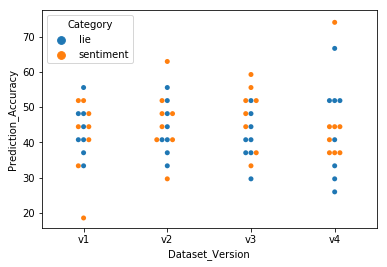

In [88]:
sns.swarmplot(x='Dataset_Version',y='Prediction_Accuracy',hue='Category',data=summary_report_df)

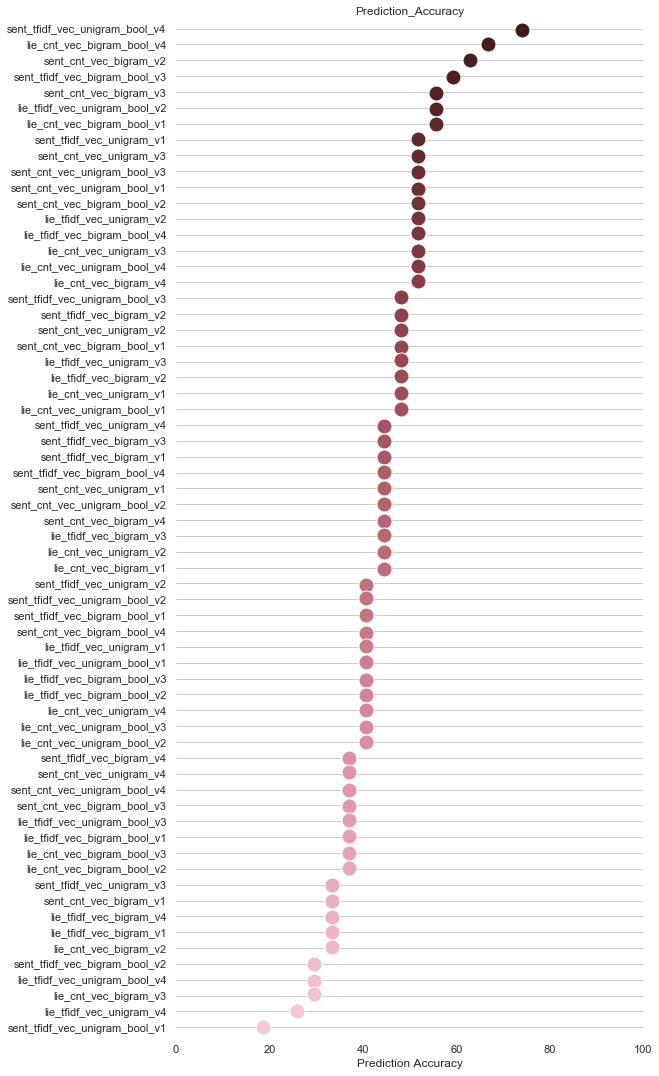

In [93]:
sns.set(style="whitegrid")
g = sns.PairGrid(sorted_summary_report,x_vars='Prediction_Accuracy', 
                 y_vars=['Experiment_Model_Name'], height=15, aspect=.50)

#Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 100), xlabel="Prediction Accuracy", ylabel="")


# Use semantically meaningful titles for the columns
titles = ["Prediction_Accuracy"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [101]:
sorted_summary_report_v1 = summary_report_df.sort_values(by=['Dataset_Version','Prediction_Accuracy'], ascending=False)
sorted_summary_report_v1.head(10)

Model_Type   Category Vectorizer   N_Gram  \
55     Benoulli Naive Bayes  sentiment      tfidf  unigram   
27     Benoulli Naive Bayes        lie      count   bigram   
11  Multinomial Naive Bayes        lie      count   bigram   
19     Benoulli Naive Bayes        lie      count  unigram   
31     Benoulli Naive Bayes        lie      tfidf   bigram   
39  Multinomial Naive Bayes  sentiment      tfidf  unigram   
43  Multinomial Naive Bayes  sentiment      count   bigram   
63     Benoulli Naive Bayes  sentiment      tfidf   bigram   
3   Multinomial Naive Bayes        lie      count  unigram   
59     Benoulli Naive Bayes  sentiment      count   bigram   

             Experiment_Model_Name Dataset_Version  Cross_Folds  \
55  sent_tfidf_vec_unigram_bool_v4              v4           10   
27      lie_cnt_vec_bigram_bool_v4              v4           10   
11           lie_cnt_vec_bigram_v4              v4           10   
19     lie_cnt_vec_unigram_bool_v4              v4           10   
31    lie_tfidf_vec_bigram_bool_v4              v4           10   
39       sent_tfidf_vec_unigram_v4              v4           10   
43          sent_cnt_vec_bigram_v4              v4           10   
63   sent_tfidf_vec_bigram_bool_v4              v4           10   
3           lie_cnt_vec_unigram_v4              v4           10   
59     sent_cnt_vec_bigram_bool_v4              v4           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
55                74.07                       27                 0.3333   
27                66.67                       27                 0.4625   
11                51.85                       27                 0.4292   
19                51.85                       27                 0.4083   
31                51.85                       27                 0.4125   
39                44.44                       27                 0.4833   
43                44.44                       27                 0.4792   
63                44.44                       27                 0.5667   
3                 40.74                       27                 0.4333   
59                40.74                       27                 0.5500   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
55                    0.2983                  0.9751   
27                    0.4014                  0.9576   
11                    0.4283                  0.9752   
19                    0.3661                  0.9474   
31                    0.3783                  0.9895   
39                    0.4238                  0.9722   
43                    0.4533                  0.9717   
63                    0.5786                  0.9773   
3                     0.3892                  0.9609   
59                    0.5758                  0.9788   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
55                     0.9762            0.1146              0.0013   
27                     0.9577            0.0998              0.0017   
11                     0.9756            0.0948              0.0008   
19                     0.9507            0.1105              0.0018   
31                     0.9897            0.1051              0.0017   
39                     0.9790            0.0854              0.0016   
43                     0.9720            0.0937              0.0009   
63                     0.9837            0.1371              0.0012   
3                      0.9748            0.0707              0.0014   
59                     0.9828            0.1026              0.0015   

       Confusion_Matrix  
55  [[ 9  6]\n [ 1 11]]  
27  [[ 7  6]\n [ 3 11]]  
11      [[6 6]\n [7 8]]  
19      [[9 8]\n [5 5]]  
31      [[7 7]\n [6 7]]  
39  [[10  1]\n [14  2]]  
43      [[6 8]\n [7 6]]  
63  [[ 6  4]\n [11  6]]  
3   [[ 2  4]\n [12  9]]  
59  [[ 6  6]\n [10  5]]

In [112]:
# avg prediciton by data version
v4_avg = summary_report_df[summary_report_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = summary_report_df[summary_report_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = summary_report_df[summary_report_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = summary_report_df[summary_report_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = summary_report_df[summary_report_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = summary_report_df[summary_report_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')



V4 Avg Prediciton Accuracy: 44.44375000000001
V3 Avg Prediciton Accuracy: 44.444374999999994
V2 Avg Prediciton Accuracy: 44.906875
V1 Avg Prediciton Accuracy: 42.591875
unigram_avg Prediciton Accuracy: 44.2125
bigram_avg Prediciton Accuracy: 43.9809375


In [76]:
mnb_df = summary_report_df[summary_report_df['Model_Type']=='Multinomial Naive Bayes']
mnb_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

Model_Type   Category Vectorizer   N_Gram  \
41  Multinomial Naive Bayes  sentiment      count   bigram   
42  Multinomial Naive Bayes  sentiment      count   bigram   
2   Multinomial Naive Bayes        lie      count  unigram   
5   Multinomial Naive Bayes        lie      tfidf  unigram   
11  Multinomial Naive Bayes        lie      count   bigram   

       Experiment_Model_Name Dataset_Version  Cross_Folds  \
41    sent_cnt_vec_bigram_v2              v2           10   
42    sent_cnt_vec_bigram_v3              v3           10   
2     lie_cnt_vec_unigram_v3              v3           10   
5   lie_tfidf_vec_unigram_v2              v2           10   
11     lie_cnt_vec_bigram_v4              v4           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
41                62.96                       27                 0.4208   
42                55.56                       27                 0.4500   
2                 51.85                       27                 0.4750   
5                 51.85                       27                 0.4500   
11                51.85                       27                 0.4292   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
41                    0.4175                  0.9864   
42                    0.4152                  0.9798   
2                     0.4933                  0.9576   
5                     0.4358                  0.9911   
11                    0.4283                  0.9752   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
41                     0.9857            0.0795              0.0014   
42                     0.9789            0.0833              0.0013   
2                      0.9583            0.0859              0.0012   
5                      0.9918            0.0896              0.0011   
11                     0.9756            0.0948              0.0008   

   Confusion_Matrix  
41  [[8 5]\n [5 9]]  
42  [[9 7]\n [5 6]]  
2   [[9 6]\n [7 5]]  
5   [[7 7]\n [6 7]]  
11  [[6 6]\n [7 8]]

In [95]:
# Top 5 lie prediction models multinomial
mnb_lie_df = mnb_df[mnb_df['Category']=='lie']
mnb_lie_t5 = mnb_lie_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

mnb_lie_t5 = mnb_lie_t5[['Experiment_Model_Name','Prediction_Accuracy','Total_Build_Time']]
mnb_lie_t5

Experiment_Model_Name  Prediction_Accuracy  Total_Build_Time
2     lie_cnt_vec_unigram_v3                51.85            0.0859
5   lie_tfidf_vec_unigram_v2                51.85            0.0896
11     lie_cnt_vec_bigram_v4                51.85            0.0948
0     lie_cnt_vec_unigram_v1                48.15            0.0780
6   lie_tfidf_vec_unigram_v3                48.15            0.0893

In [116]:
# avg prediciton by data version
v4_avg = mnb_lie_df[mnb_lie_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = mnb_lie_df[mnb_lie_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = mnb_lie_df[mnb_lie_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = mnb_lie_df[mnb_lie_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg =mnb_lie_df[mnb_lie_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = mnb_lie_df[mnb_lie_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')

V4 Avg Prediciton Accuracy: 37.962500000000006
V3 Avg Prediciton Accuracy: 43.5175
V2 Avg Prediciton Accuracy: 44.4425
V1 Avg Prediciton Accuracy: 41.66499999999999
unigram_avg Prediciton Accuracy: 43.98125
bigram_avg Prediciton Accuracy: 39.81249999999999


In [79]:
# Top 5 sentiment prediction models multinomial
mnb_sent_df = mnb_df[mnb_df['Category']=='sentiment']
mnb_sent_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

Model_Type   Category Vectorizer   N_Gram  \
41  Multinomial Naive Bayes  sentiment      count   bigram   
42  Multinomial Naive Bayes  sentiment      count   bigram   
34  Multinomial Naive Bayes  sentiment      count  unigram   
36  Multinomial Naive Bayes  sentiment      tfidf  unigram   
33  Multinomial Naive Bayes  sentiment      count  unigram   

        Experiment_Model_Name Dataset_Version  Cross_Folds  \
41     sent_cnt_vec_bigram_v2              v2           10   
42     sent_cnt_vec_bigram_v3              v3           10   
34    sent_cnt_vec_unigram_v3              v3           10   
36  sent_tfidf_vec_unigram_v1              v1           10   
33    sent_cnt_vec_unigram_v2              v2           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
41                62.96                       27                 0.4208   
42                55.56                       27                 0.4500   
34                51.85                       27                 0.5500   
36                51.85                       27                 0.4958   
33                48.15                       27                 0.4667   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
41                    0.4175                  0.9864   
42                    0.4152                  0.9798   
34                    0.5517                  0.9873   
36                    0.4683                  0.9856   
33                    0.4667                  0.9707   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
41                     0.9857            0.0795              0.0014   
42                     0.9789            0.0833              0.0013   
34                     0.9882            0.1050              0.0014   
36                     0.9866            0.0736              0.0008   
33                     0.9737            0.1152              0.0011   

   Confusion_Matrix  
41  [[8 5]\n [5 9]]  
42  [[9 7]\n [5 6]]  
34  [[7 9]\n [4 7]]  
36  [[7 7]\n [6 7]]  
33  [[8 8]\n [6 5]]

In [96]:
mnb_sent_df = mnb_df[mnb_df['Category']=='sentiment']
mnb_sent_t5=mnb_sent_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

mnb_sent_t5 = mnb_sent_t5[['Experiment_Model_Name','Prediction_Accuracy','Total_Build_Time']]
mnb_sent_t5

Experiment_Model_Name  Prediction_Accuracy  Total_Build_Time
41     sent_cnt_vec_bigram_v2                62.96            0.0795
42     sent_cnt_vec_bigram_v3                55.56            0.0833
34    sent_cnt_vec_unigram_v3                51.85            0.1050
36  sent_tfidf_vec_unigram_v1                51.85            0.0736
33    sent_cnt_vec_unigram_v2                48.15            0.1152

In [113]:
# avg prediciton by data version
v4_avg = mnb_sent_df[mnb_sent_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = mnb_sent_df[mnb_sent_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = mnb_sent_df[mnb_sent_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = mnb_sent_df[mnb_sent_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = mnb_sent_df[mnb_sent_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = mnb_sent_df[mnb_sent_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')

V4 Avg Prediciton Accuracy: 40.739999999999995
V3 Avg Prediciton Accuracy: 46.295
V2 Avg Prediciton Accuracy: 50.0
V1 Avg Prediciton Accuracy: 43.515
unigram_avg Prediciton Accuracy: 43.98
bigram_avg Prediciton Accuracy: 46.295


In [77]:
# top 5 Benoulli prediction models
bnb_df = summary_report_df[summary_report_df['Model_Type']=='Benoulli Naive Bayes']
bnb_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

Model_Type   Category Vectorizer   N_Gram  \
55  Benoulli Naive Bayes  sentiment      tfidf  unigram   
27  Benoulli Naive Bayes        lie      count   bigram   
62  Benoulli Naive Bayes  sentiment      tfidf   bigram   
21  Benoulli Naive Bayes        lie      tfidf  unigram   
24  Benoulli Naive Bayes        lie      count   bigram   

             Experiment_Model_Name Dataset_Version  Cross_Folds  \
55  sent_tfidf_vec_unigram_bool_v4              v4           10   
27      lie_cnt_vec_bigram_bool_v4              v4           10   
62   sent_tfidf_vec_bigram_bool_v3              v3           10   
21   lie_tfidf_vec_unigram_bool_v2              v2           10   
24      lie_cnt_vec_bigram_bool_v1              v1           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
55                74.07                       27                 0.3333   
27                66.67                       27                 0.4625   
62                59.26                       27                 0.4958   
21                55.56                       27                 0.4333   
24                55.56                       27                 0.4000   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
55                    0.2983                  0.9751   
27                    0.4014                  0.9576   
62                    0.4256                  0.9659   
21                    0.4133                  0.9808   
24                    0.3227                  0.9519   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
55                     0.9762            0.1146              0.0013   
27                     0.9577            0.0998              0.0017   
62                     0.9688            0.1804              0.0021   
21                     0.9813            0.1246              0.0022   
24                     0.9600            0.1185              0.0017   

       Confusion_Matrix  
55  [[ 9  6]\n [ 1 11]]  
27  [[ 7  6]\n [ 3 11]]  
62      [[7 8]\n [3 9]]  
21      [[6 8]\n [4 9]]  
24  [[ 6 10]\n [ 2  9]]

In [80]:
# Top 5 lie prediction models ben
bnb_lie_df = bnb_df[bnb_df['Category']=='lie']
bnb_lie_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

Model_Type Category Vectorizer   N_Gram  \
27  Benoulli Naive Bayes      lie      count   bigram   
21  Benoulli Naive Bayes      lie      tfidf  unigram   
24  Benoulli Naive Bayes      lie      count   bigram   
19  Benoulli Naive Bayes      lie      count  unigram   
31  Benoulli Naive Bayes      lie      tfidf   bigram   

            Experiment_Model_Name Dataset_Version  Cross_Folds  \
27     lie_cnt_vec_bigram_bool_v4              v4           10   
21  lie_tfidf_vec_unigram_bool_v2              v2           10   
24     lie_cnt_vec_bigram_bool_v1              v1           10   
19    lie_cnt_vec_unigram_bool_v4              v4           10   
31   lie_tfidf_vec_bigram_bool_v4              v4           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
27                66.67                       27                 0.4625   
21                55.56                       27                 0.4333   
24                55.56                       27                 0.4000   
19                51.85                       27                 0.4083   
31                51.85                       27                 0.4125   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
27                    0.4014                  0.9576   
21                    0.4133                  0.9808   
24                    0.3227                  0.9519   
19                    0.3661                  0.9474   
31                    0.3783                  0.9895   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
27                     0.9577            0.0998              0.0017   
21                     0.9813            0.1246              0.0022   
24                     0.9600            0.1185              0.0017   
19                     0.9507            0.1105              0.0018   
31                     0.9897            0.1051              0.0017   

       Confusion_Matrix  
27  [[ 7  6]\n [ 3 11]]  
21      [[6 8]\n [4 9]]  
24  [[ 6 10]\n [ 2  9]]  
19      [[9 8]\n [5 5]]  
31      [[7 7]\n [6 7]]

In [114]:
# avg prediciton by data version
v4_avg = bnb_lie_df[bnb_lie_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = bnb_lie_df[bnb_lie_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = bnb_lie_df[bnb_lie_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = bnb_lie_df[bnb_lie_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = bnb_lie_df[bnb_lie_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = bnb_lie_df[bnb_lie_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')

V4 Avg Prediciton Accuracy: 50.0
V3 Avg Prediciton Accuracy: 38.89
V2 Avg Prediciton Accuracy: 43.52
V1 Avg Prediciton Accuracy: 45.372499999999995
unigram_avg Prediciton Accuracy: 43.05625
bigram_avg Prediciton Accuracy: 45.835


In [97]:
# Top 5 lie prediction models ben
bnb_lie_df = bnb_df[bnb_df['Category']=='lie']
bnb_lie_t5=bnb_lie_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

bnb_lie_t5 = bnb_lie_t5[['Experiment_Model_Name','Prediction_Accuracy','Total_Build_Time']]
bnb_lie_t5

Experiment_Model_Name  Prediction_Accuracy  Total_Build_Time
27     lie_cnt_vec_bigram_bool_v4                66.67            0.0998
21  lie_tfidf_vec_unigram_bool_v2                55.56            0.1246
24     lie_cnt_vec_bigram_bool_v1                55.56            0.1185
19    lie_cnt_vec_unigram_bool_v4                51.85            0.1105
31   lie_tfidf_vec_bigram_bool_v4                51.85            0.1051

In [81]:
# Top 5 lie prediction models ben
bnb_sent_df = bnb_df[bnb_df['Category']=='sentiment']
bnb_sent_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

Model_Type   Category Vectorizer   N_Gram  \
55  Benoulli Naive Bayes  sentiment      tfidf  unigram   
62  Benoulli Naive Bayes  sentiment      tfidf   bigram   
48  Benoulli Naive Bayes  sentiment      count  unigram   
50  Benoulli Naive Bayes  sentiment      count  unigram   
57  Benoulli Naive Bayes  sentiment      count   bigram   

             Experiment_Model_Name Dataset_Version  Cross_Folds  \
55  sent_tfidf_vec_unigram_bool_v4              v4           10   
62   sent_tfidf_vec_bigram_bool_v3              v3           10   
48    sent_cnt_vec_unigram_bool_v1              v1           10   
50    sent_cnt_vec_unigram_bool_v3              v3           10   
57     sent_cnt_vec_bigram_bool_v2              v2           10   

    Prediction_Accuracy  Total_Prediction_Points  Test_Recall_Score_Avg  \
55                74.07                       27                 0.3333   
62                59.26                       27                 0.4958   
48                51.85                       27                 0.4625   
50                51.85                       27                 0.5292   
57                51.85                       27                 0.4125   

    Test_Precision_Score_Avg  Train_Recall_Score_Avg  \
55                    0.2983                  0.9751   
62                    0.4256                  0.9659   
48                    0.4292                  0.9758   
50                    0.4958                  0.9844   
57                    0.3298                  0.9660   

    Train_Precision_Score_Avg  Total_Build_Time  Total_Predict_Time  \
55                     0.9762            0.1146              0.0013   
62                     0.9688            0.1804              0.0021   
48                     0.9760            0.1246              0.0017   
50                     0.9848            0.1065              0.0015   
57                     0.9729            0.1012              0.0013   

       Confusion_Matrix  
55  [[ 9  6]\n [ 1 11]]  
62      [[7 8]\n [3 9]]  
48      [[6 7]\n [6 8]]  
50  [[10  4]\n [ 9  4]]  
57      [[7 5]\n [8 7]]

In [115]:
# avg prediciton by data version
v4_avg = bnb_sent_df[bnb_sent_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = bnb_sent_df[bnb_sent_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = bnb_sent_df[bnb_sent_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = bnb_sent_df[bnb_sent_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = bnb_sent_df[bnb_sent_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = bnb_sent_df[bnb_sent_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')

V4 Avg Prediciton Accuracy: 49.0725
V3 Avg Prediciton Accuracy: 49.074999999999996
V2 Avg Prediciton Accuracy: 41.665
V1 Avg Prediciton Accuracy: 39.815000000000005
unigram_avg Prediciton Accuracy: 45.832499999999996
bigram_avg Prediciton Accuracy: 43.98125


In [98]:
# Top 5 lie prediction models ben
bnb_sent_df = bnb_df[bnb_df['Category']=='sentiment']
bnb_sent_t5=bnb_sent_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

bnb_sent_t5 = bnb_sent_t5[['Experiment_Model_Name','Prediction_Accuracy','Total_Build_Time']]
bnb_sent_t5

Experiment_Model_Name  Prediction_Accuracy  Total_Build_Time
55  sent_tfidf_vec_unigram_bool_v4                74.07            0.1146
62   sent_tfidf_vec_bigram_bool_v3                59.26            0.1804
48    sent_cnt_vec_unigram_bool_v1                51.85            0.1246
50    sent_cnt_vec_unigram_bool_v3                51.85            0.1065
57     sent_cnt_vec_bigram_bool_v2                51.85            0.1012

In [68]:
# save summary report
save_as = f'{outputDir}/summary_report.csv'
summary_report_df.to_csv(save_as,index=False)

#### Model Validation
Perform model validations

### iNterpret
Interpret the model results, make knowledge based recommendations

In [69]:
# perform interpretation steps

# Report Generation
Execute the below cell to create an HTML report

In [70]:
# for report auto generation
# testing markup report generation
#from nbconvert import HTMLExporter
#import codecs
#import os
#import datetime

#stamp = datetime.date.today().strftime("%m-%d-%Y")
#exporter = HTMLExporter(template_file='report.tpl')
#output, resources = exporter.from_filename(notebook_file_name)
#new_fnw = report_file_name
#codecs.open(new_fnw, 'w',encoding='utf-8').write(output)